## Defining Dataset Class and Other Functions

In [184]:
import random
import os
import os.path as osp
import numpy as np
import scipy
import regex as re
import math

import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

# Normalization parameters for pre-trained PyTorch models
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])


def denormalize(tensors):
    for c in range(3):
        tensors[:, c].mul_(std[c]).add_(mean[c])
    return torch.clamp(tensors, 0, 255)

def get_full_list(data_dir):
    data_list = []
    data_list += sorted(
        osp.join(data_dir, img_name) for img_name in
            os.listdir(data_dir)
    )
    return data_list

def get_full_list_within_folders(root_dir):
    data_list = []
    for name_dir in os.listdir(root_dir):
        data_dir = osp.join(root_dir, name_dir)
        for img_name in os.listdir(data_dir):
            data_list.append(osp.join(data_dir, img_name))
    random.shuffle(data_list) 
    return data_list

def visualize_dataset(img_paths, nrows=2, ncols=12, dataset_name='Dataset', **kwargs):
    title = f'{dataset_name} images'
    if 'title' in kwargs:
        title = kwargs['title']        
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8))
    fig.suptitle(title, fontsize=16)
    for i in range(nrows):
        for j in range(ncols):
            img_path = img_paths[i*(ncols)+j]
            pic = plt.imread(img_path)
            axes[i][j].axis('off')
            axes[i][j].imshow(pic)
            if 'axis_titles' in kwargs:
                assert nrows*ncols == len(kwargs['axis_titles']), "Number of images don't match the number of axis titles"
                axis_titles = kwargs['axis_titles']
                axes[i][j].set_title(axis_titles[i*(ncols)+j])

def visualize_training_images(dataset_name, num_images=10, **kwargs):
    if 'nrows' in kwargs:
        nrows = kwargs['nrows']
        if 'ncols' in kwargs:
            ncols = kwargs['ncols']
            assert num_images == nrows + ncols, "nrows and ncols don't agree with num_images"
        else:
            ncols = math.ceil(num_images/nrows)
    else:
        nrows = 2
        ncols = math.ceil(num_images/nrows)
             
    full_img_paths = []
    root_path = f"images/{dataset_name}/training/"

    img_paths = os.listdir(root_path)
    img_paths.sort(key=lambda x: int(re.findall(r'\d+', x)[0]))
    for img_path in img_paths:
        full_img_paths.append(osp.join(root_path, img_path))

    iteration_numbers = np.arange(0, num_images, 1)*int(len(full_img_paths)/(num_images-1))
    chosen_img_paths = [full_img_paths[i] for i in iteration_numbers]
    img_numbers = chosen_img_paths[0].split("/")[-1][:-4]
    
    visualize_dataset(
        chosen_img_paths,
        nrows=nrows, ncols=ncols, title="Training Results",
        axis_titles=[f'Iteration: {i}' for i in iteration_numbers]
    )                
                
class ImgDataset(Dataset):
    def __init__(self, datalist, hr_shape):
        hr_height, hr_width = hr_shape
        # Transforms for low resolution images and high resolution images
        self.lr_transform = transforms.Compose(
            [
                transforms.Resize((hr_height // 4, hr_height // 4), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ]
        )
        self.hr_transform = transforms.Compose(
            [
                transforms.Resize((hr_height, hr_height), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ]
        )

        self.datalist = datalist
        self.dataset_name = datalist[0].split('/')[2]
        
    def visualize_dataset(self, nrows=2, ncols=12, **kwargs):
        title = f'{dataset_name} images'
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8))
        fig.suptitle(title, fontsize=16)
        for i in range(nrows):
            for j in range(ncols):
                img_path = self.datalist[i*(ncols)+j]
                pic = plt.imread(img_path)
                axes[i][j].axis('off')
                axes[i][j].imshow(pic)
                if 'axis_titles' in kwargs:
                    assert nrows*ncols == len(kwargs['axis_titles']), "Number of images don't match the number of axis titles"
                    axis_titles = kwargs['axis_titles']
                    axes[i][j].set_title(axis_titles[i*(ncols)+j])
        

    def __getitem__(self, index):
        img = Image.open(self.datalist[index % len(self.datalist)])
        img_lr = self.lr_transform(img)
        img_hr = self.hr_transform(img)

        return {"lr": img_lr, "hr": img_hr}
    
    def __getdegradeditem__(self, index):
        img = Image.open(self.datalist[index % len(self.datalist)])
        img + numpy.random.normal(0., 0.5, img.shape)
        img_lr = self.lr_transform(img)
        img_hr = self.hr_transform(img)

        return {"lr": img_lr, "hr": img_hr}

    def __len__(self):
        return len(self.datalist)

## Defining Model

In [185]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from torchvision.models import vgg19
import math


class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19_model = vgg19(pretrained=True)
        self.vgg19_54 = nn.Sequential(*list(vgg19_model.features.children())[:35])

    def forward(self, img):
        return self.vgg19_54(img)


class DenseResidualBlock(nn.Module):
    def __init__(self, filters, res_scale=0.2):
        super(DenseResidualBlock, self).__init__()
        self.res_scale = res_scale


        self.block1 = nn.Sequential(
            nn.Conv2d(1 * filters, filters, 3, 1, 1, bias=True),
            nn.LeakyReLU()
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(2 * filters, filters, 3, 1, 1, bias=True),
            nn.LeakyReLU()
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(3 * filters, filters, 3, 1, 1, bias=True),
            nn.LeakyReLU()
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(4 * filters, filters, 3, 1, 1, bias=True),
            nn.LeakyReLU()
        )
        self.block5 = nn.Sequential(
            nn.Conv2d(5 * filters, filters, 3, 1, 1, bias=True),
        )

    def forward(self, x):
        inputs = x
        out = self.block1(inputs)
        inputs = torch.cat([inputs, out], 1)
        
        out = self.block2(inputs)
        inputs = torch.cat([inputs, out], 1)
        
        out = self.block3(inputs)
        inputs = torch.cat([inputs, out], 1)
        
        out = self.block4(inputs)
        inputs = torch.cat([inputs, out], 1)
        
        out = self.block5(inputs)
        inputs = torch.cat([inputs, out], 1)
        
        return out.mul(self.res_scale) + x


class ResidualInResidualDenseBlock(nn.Module):
    def __init__(self, filters, res_scale=0.2):
        super(ResidualInResidualDenseBlock, self).__init__()
        self.res_scale = res_scale
        self.dense_blocks = nn.Sequential(
            DenseResidualBlock(filters), DenseResidualBlock(filters), DenseResidualBlock(filters)
        )

    def forward(self, x):
        return self.dense_blocks(x).mul(self.res_scale) + x


class GeneratorRRDB(nn.Module):
    def __init__(self, channels, filters=64, num_res_blocks=16, num_upsample=2):
        super(GeneratorRRDB, self).__init__()

        self.conv1 = nn.Conv2d(channels, filters, kernel_size=3, stride=1, padding=1)
        self.res_blocks = nn.Sequential(*[ResidualInResidualDenseBlock(filters) for i in range(num_res_blocks)])
        self.conv2 = nn.Conv2d(filters, filters, kernel_size=3, stride=1, padding=1)
        
        self.upsampling = nn.Sequential(
            nn.Conv2d(filters, filters * 4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.PixelShuffle(upscale_factor=2),
            nn.Conv2d(filters, filters * 4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.PixelShuffle(upscale_factor=2)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(filters, filters, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(filters, channels, kernel_size=3, stride=1, padding=1),
        )

    def forward(self, x):
        out1 = self.conv1(x)
        out = self.res_blocks(out1)
        out2 = self.conv2(out)
        out = torch.add(out1, out2)
        out = self.upsampling(out)
        out = self.conv3(out)
        return out


class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        self.input_shape = input_shape
        in_channels, in_height, in_width = self.input_shape
        patch_h, patch_w = int(in_height / 2 ** 4), int(in_width / 2 ** 4)
        self.output_shape = (1, patch_h, patch_w)

        def discriminator_block(in_filters, out_filters, first_block=False):
            layers = []
            layers.append(nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=1, padding=1))
            if not first_block:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Conv2d(out_filters, out_filters, kernel_size=3, stride=2, padding=1))
            layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = in_channels
        for i, out_filters in enumerate([64, 128, 256, 512]):
            layers.extend(discriminator_block(in_filters, out_filters, first_block=(i == 0)))
            in_filters = out_filters

        layers.append(nn.Conv2d(out_filters, 1, kernel_size=3, stride=1, padding=1))

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)

# Original Dataset Celebrities

## Loading Original Dataset and Creating Parameters

In [186]:
import os
import numpy as np
from torchvision.utils import save_image, make_grid
from torch.autograd import Variable
import torch.nn as nn
import torch

# Parameters
epoch = 0
n_epochs = 5
dataset_name ="img_align_celeba"
batch_size = 2
lr = 0.0002
b1 = 0.9
b2 = 0.999
decay_epoch = 5
n_cpu = 1
hr_height = 256
hr_width = 256
channels = 3
sample_interval = 10
checkpoint_interval = 50
residual_blocks = 23
warmup_batches = 500
lambda_adv = 5e-3
lambda_pixel = 1e-2
hr_shape = (256, 256)

celeb_full_data_list = get_full_list(f"./data/{dataset_name}")

TOTAL_SIZE = len(celeb_full_data_list)
TRAIN_SIZE = int(1/128 * TOTAL_SIZE)
VAL_SIZE = int(1/128 * TOTAL_SIZE)
TEST_SIZE = int(1/128 * TOTAL_SIZE)

os.makedirs(f"images/{dataset_name}/training", exist_ok=True)
os.makedirs(f"saved_models/{dataset_name}", exist_ok=True)

train_dataset = ImgDataset(celeb_full_data_list[:TRAIN_SIZE], hr_shape)
val_dataset = ImgDataset(celeb_full_data_list[TRAIN_SIZE: TRAIN_SIZE + VAL_SIZE], hr_shape)
test_dataset = ImgDataset(celeb_full_data_list[TRAIN_SIZE + VAL_SIZE: TRAIN_SIZE + VAL_SIZE + TEST_SIZE], hr_shape)

print("Training Set Size:", len(train_dataset))
print("Validation Set Size:", len(val_dataset))
print("Test Set Size:", len(test_dataset))

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=1, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=False
)

Training Set Size: 1582
Validation Set Size: 1582
Test Set Size: 1582


## Visualizing Dataset

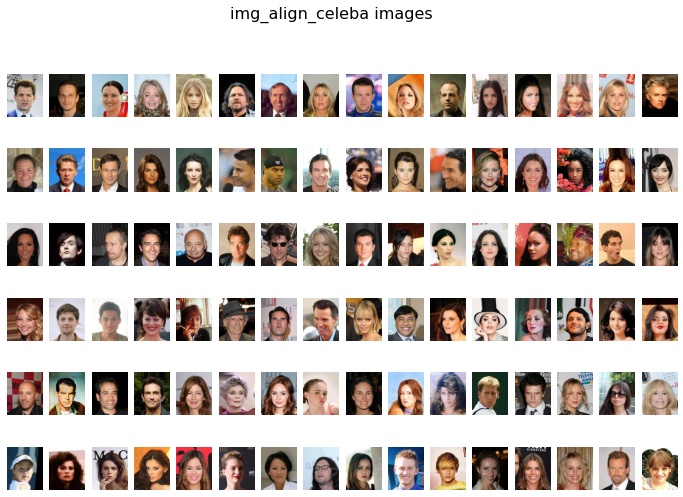

In [187]:
train_dataset.visualize_dataset(nrows=6, ncols=16)

## Instantiating Model

In [188]:
# Load cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize generator and discriminator
generator = GeneratorRRDB(3, filters=64, num_res_blocks=23).to(device)
discriminator = Discriminator(input_shape=(3, *hr_shape)).to(device)
feature_extractor = FeatureExtractor().to(device)

# Set feature extractor to inference mode
feature_extractor.eval()

# Losses
criterion_GAN = torch.nn.BCEWithLogitsLoss().to(device)
criterion_content = torch.nn.L1Loss().to(device)
criterion_pixel = torch.nn.L1Loss().to(device)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.Tensor

## Training Original Model

In [189]:
# ----------
#  Training
# ----------
best_disc_score, best_gen_score = 5, 5
best_disc, best_gen = discriminator.state_dict(), generator.state_dict()
for epoch in range(epoch, n_epochs):
    for i, imgs in enumerate(train_loader):

        batches_done = epoch * len(train_loader) + i

        # Configure model input
        imgs_lr = Variable(imgs["lr"].type(Tensor))
        imgs_hr = Variable(imgs["hr"].type(Tensor))

        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)

        # ------------------
        #  Train Generators
        # ------------------

        optimizer_G.zero_grad()

        # Generate a high resolution image from low resolution input
        # Forward pass for generator
        gen_hr = generator(imgs_lr)

        # Measure pixel-wise loss against ground truth
        loss_pixel = criterion_pixel(gen_hr, imgs_hr)

        if batches_done < warmup_batches:
            # Warm-up (pixel-wise loss only)
            loss_pixel.backward()
            optimizer_G.step()
            print(
                "[Epoch %d/%d] [Batch %d/%d] [G pixel: %f]"
                % (epoch, n_epochs, i, len(train_loader), loss_pixel.item())
            )
            continue

        # Extract validity predictions from discriminator
        pred_real = discriminator(imgs_hr).detach()
        pred_fake = discriminator(gen_hr)

        # Adversarial loss (relativistic average GAN)
        loss_GAN = criterion_GAN(pred_fake - pred_real.mean(0, keepdim=True), valid)

        # Content loss
        gen_features = feature_extractor(gen_hr)
        real_features = feature_extractor(imgs_hr).detach()
        loss_content = criterion_content(gen_features, real_features)

        # Total generator loss
        loss_G = loss_content + lambda_adv * loss_GAN + lambda_pixel * loss_pixel

        loss_G.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        pred_real = discriminator(imgs_hr)
        pred_fake = discriminator(gen_hr.detach())

        # Adversarial loss for real and fake images (relativistic average GAN)
        loss_real = criterion_GAN(pred_real - pred_fake.mean(0, keepdim=True), valid)
        loss_fake = criterion_GAN(pred_fake - pred_real.mean(0, keepdim=True), fake)

        # Total loss
        loss_D = (loss_real + loss_fake) / 2

        loss_D.backward()
        optimizer_D.step()

        # --------------
        #  Log Progress
        # --------------

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, content: %f, adv: %f, pixel: %f]"
            % (
                epoch,
                n_epochs,
                i,
                len(train_loader),
                loss_D.item(),
                loss_G.item(),
                loss_content.item(),
                loss_GAN.item(),
                loss_pixel.item(),
            )
        )

        # Get best discriminator and best generator
        if best_disc_score > loss_D.item():
            best_disc_score = loss_D.item()
            best_disc = discriminator.state_dict()

        if best_gen_score > loss_G.item():
            best_gen_score = loss_G.item()
            best_gen = generator.state_dict()


        if batches_done % sample_interval == 0:
            # Save image grid with upsampled inputs and ESRGAN outputs
            print(f"Saving image after {batches_done} batches done")
            imgs_lr = nn.functional.interpolate(imgs_lr, scale_factor=4)
            img_grid = denormalize(torch.cat((imgs_lr, gen_hr), -1))
            save_image(img_grid, f"images/{dataset_name}/training/{batches_done}.png", nrow=1, normalize=False)

        if batches_done % checkpoint_interval == 0:
            # Save model checkpoints
            print(f"Saving model from epoch {epoch}")
            torch.save(generator.state_dict(), f"saved_models/{dataset_name}/generator_{epoch}.pth")
            torch.save(discriminator.state_dict(), f"saved_models/{dataset_name}/discriminator_{epoch}.pth")

# Save best models
torch.save(best_gen, f"saved_models/{dataset_name}/best_generator.pth")
torch.save(best_disc, f"saved_models/{dataset_name}/best_discriminator.pth")

[Epoch 0/5] [Batch 0/791] [G pixel: 1.738314]
[Epoch 0/5] [Batch 1/791] [G pixel: 1.196643]
[Epoch 0/5] [Batch 2/791] [G pixel: 0.931211]
[Epoch 0/5] [Batch 3/791] [G pixel: 1.012805]
[Epoch 0/5] [Batch 4/791] [G pixel: 1.085254]
[Epoch 0/5] [Batch 5/791] [G pixel: 0.572122]
[Epoch 0/5] [Batch 6/791] [G pixel: 0.801919]
[Epoch 0/5] [Batch 7/791] [G pixel: 0.490687]
[Epoch 0/5] [Batch 8/791] [G pixel: 0.594627]
[Epoch 0/5] [Batch 9/791] [G pixel: 0.540977]
[Epoch 0/5] [Batch 10/791] [G pixel: 0.456794]
[Epoch 0/5] [Batch 11/791] [G pixel: 0.424974]
[Epoch 0/5] [Batch 12/791] [G pixel: 0.416695]
[Epoch 0/5] [Batch 13/791] [G pixel: 0.436638]
[Epoch 0/5] [Batch 14/791] [G pixel: 0.324678]
[Epoch 0/5] [Batch 15/791] [G pixel: 0.443904]
[Epoch 0/5] [Batch 16/791] [G pixel: 0.309980]
[Epoch 0/5] [Batch 17/791] [G pixel: 0.350938]
[Epoch 0/5] [Batch 18/791] [G pixel: 0.286049]
[Epoch 0/5] [Batch 19/791] [G pixel: 0.365784]
[Epoch 0/5] [Batch 20/791] [G pixel: 0.339535]
[Epoch 0/5] [Batch 21/7

[Epoch 0/5] [Batch 173/791] [G pixel: 0.184064]
[Epoch 0/5] [Batch 174/791] [G pixel: 0.205871]
[Epoch 0/5] [Batch 175/791] [G pixel: 0.173707]
[Epoch 0/5] [Batch 176/791] [G pixel: 0.169538]
[Epoch 0/5] [Batch 177/791] [G pixel: 0.176922]
[Epoch 0/5] [Batch 178/791] [G pixel: 0.156309]
[Epoch 0/5] [Batch 179/791] [G pixel: 0.148971]
[Epoch 0/5] [Batch 180/791] [G pixel: 0.138021]
[Epoch 0/5] [Batch 181/791] [G pixel: 0.194670]
[Epoch 0/5] [Batch 182/791] [G pixel: 0.174840]
[Epoch 0/5] [Batch 183/791] [G pixel: 0.183423]
[Epoch 0/5] [Batch 184/791] [G pixel: 0.146523]
[Epoch 0/5] [Batch 185/791] [G pixel: 0.147044]
[Epoch 0/5] [Batch 186/791] [G pixel: 0.148079]
[Epoch 0/5] [Batch 187/791] [G pixel: 0.143163]
[Epoch 0/5] [Batch 188/791] [G pixel: 0.154678]
[Epoch 0/5] [Batch 189/791] [G pixel: 0.121849]
[Epoch 0/5] [Batch 190/791] [G pixel: 0.124778]
[Epoch 0/5] [Batch 191/791] [G pixel: 0.130822]
[Epoch 0/5] [Batch 192/791] [G pixel: 0.168784]
[Epoch 0/5] [Batch 193/791] [G pixel: 0.

[Epoch 0/5] [Batch 344/791] [G pixel: 0.111490]
[Epoch 0/5] [Batch 345/791] [G pixel: 0.148414]
[Epoch 0/5] [Batch 346/791] [G pixel: 0.137442]
[Epoch 0/5] [Batch 347/791] [G pixel: 0.130396]
[Epoch 0/5] [Batch 348/791] [G pixel: 0.121105]
[Epoch 0/5] [Batch 349/791] [G pixel: 0.113148]
[Epoch 0/5] [Batch 350/791] [G pixel: 0.127310]
[Epoch 0/5] [Batch 351/791] [G pixel: 0.164293]
[Epoch 0/5] [Batch 352/791] [G pixel: 0.133500]
[Epoch 0/5] [Batch 353/791] [G pixel: 0.163974]
[Epoch 0/5] [Batch 354/791] [G pixel: 0.128736]
[Epoch 0/5] [Batch 355/791] [G pixel: 0.144683]
[Epoch 0/5] [Batch 356/791] [G pixel: 0.111800]
[Epoch 0/5] [Batch 357/791] [G pixel: 0.119575]
[Epoch 0/5] [Batch 358/791] [G pixel: 0.158117]
[Epoch 0/5] [Batch 359/791] [G pixel: 0.146924]
[Epoch 0/5] [Batch 360/791] [G pixel: 0.113569]
[Epoch 0/5] [Batch 361/791] [G pixel: 0.119378]
[Epoch 0/5] [Batch 362/791] [G pixel: 0.154121]
[Epoch 0/5] [Batch 363/791] [G pixel: 0.198532]
[Epoch 0/5] [Batch 364/791] [G pixel: 0.

[Epoch 0/5] [Batch 506/791] [D loss: 0.681059] [G loss: 2.951222, content: 2.939658, adv: 0.752833, pixel: 0.779980]
[Epoch 0/5] [Batch 507/791] [D loss: 0.658900] [G loss: 3.456591, content: 3.443963, adv: 0.780866, pixel: 0.872422]
[Epoch 0/5] [Batch 508/791] [D loss: 0.565618] [G loss: 2.774632, content: 2.759568, adv: 0.918462, pixel: 1.047088]
[Epoch 0/5] [Batch 509/791] [D loss: 0.548932] [G loss: 2.396653, content: 2.382041, adv: 0.960199, pixel: 0.981108]
[Epoch 0/5] [Batch 510/791] [D loss: 0.595217] [G loss: 2.407627, content: 2.396005, adv: 0.882630, pixel: 0.720923]
Saving image after 510 batches done
[Epoch 0/5] [Batch 511/791] [D loss: 0.494350] [G loss: 2.443925, content: 2.429247, adv: 1.032995, pixel: 0.951332]
[Epoch 0/5] [Batch 512/791] [D loss: 0.404403] [G loss: 2.238407, content: 2.221669, adv: 1.226231, pixel: 1.060667]
[Epoch 0/5] [Batch 513/791] [D loss: 0.497582] [G loss: 2.260293, content: 2.246299, adv: 1.119889, pixel: 0.839417]
[Epoch 0/5] [Batch 514/791] 

[Epoch 0/5] [Batch 574/791] [D loss: 0.002931] [G loss: 1.847111, content: 1.811238, adv: 6.245381, pixel: 0.464692]
[Epoch 0/5] [Batch 575/791] [D loss: 0.003076] [G loss: 1.638277, content: 1.601989, adv: 6.308287, pixel: 0.474654]
[Epoch 0/5] [Batch 576/791] [D loss: 0.002957] [G loss: 1.640717, content: 1.605227, adv: 6.279153, pixel: 0.409448]
[Epoch 0/5] [Batch 577/791] [D loss: 0.003412] [G loss: 1.902551, content: 1.866670, adv: 6.257420, pixel: 0.459371]
[Epoch 0/5] [Batch 578/791] [D loss: 0.001909] [G loss: 2.066536, content: 2.026904, adv: 6.725895, pixel: 0.600279]
[Epoch 0/5] [Batch 579/791] [D loss: 0.003246] [G loss: 1.900611, content: 1.862853, adv: 6.324821, pixel: 0.613432]
[Epoch 0/5] [Batch 580/791] [D loss: 0.005475] [G loss: 2.201324, content: 2.163481, adv: 6.023689, pixel: 0.772521]
Saving image after 580 batches done
[Epoch 0/5] [Batch 581/791] [D loss: 0.002021] [G loss: 2.029276, content: 1.990581, adv: 6.618094, pixel: 0.560472]
[Epoch 0/5] [Batch 582/791] 

[Epoch 0/5] [Batch 642/791] [D loss: 0.001328] [G loss: 1.521945, content: 1.481639, adv: 7.187192, pixel: 0.437002]
[Epoch 0/5] [Batch 643/791] [D loss: 0.001287] [G loss: 1.782130, content: 1.738931, adv: 7.130103, pixel: 0.754894]
[Epoch 0/5] [Batch 644/791] [D loss: 0.000990] [G loss: 1.736079, content: 1.693331, adv: 7.408833, pixel: 0.570463]
[Epoch 0/5] [Batch 645/791] [D loss: 0.001862] [G loss: 1.631030, content: 1.590290, adv: 7.294023, pixel: 0.426953]
[Epoch 0/5] [Batch 646/791] [D loss: 0.000973] [G loss: 1.702816, content: 1.660987, adv: 7.433913, pixel: 0.465938]
[Epoch 0/5] [Batch 647/791] [D loss: 0.002927] [G loss: 1.471417, content: 1.435776, adv: 6.339121, pixel: 0.394517]
[Epoch 0/5] [Batch 648/791] [D loss: 0.000892] [G loss: 1.529018, content: 1.486194, adv: 7.475217, pixel: 0.544808]
[Epoch 0/5] [Batch 649/791] [D loss: 0.000954] [G loss: 1.667737, content: 1.625897, adv: 7.392848, pixel: 0.487618]
[Epoch 0/5] [Batch 650/791] [D loss: 0.001607] [G loss: 1.649564

[Epoch 0/5] [Batch 710/791] [D loss: 0.006772] [G loss: 1.766862, content: 1.735159, adv: 5.523117, pixel: 0.408767]
Saving image after 710 batches done
[Epoch 0/5] [Batch 711/791] [D loss: 0.000441] [G loss: 1.429284, content: 1.386350, adv: 7.965658, pixel: 0.310487]
[Epoch 0/5] [Batch 712/791] [D loss: 0.000528] [G loss: 1.553363, content: 1.510575, adv: 7.874334, pixel: 0.341659]
[Epoch 0/5] [Batch 713/791] [D loss: 0.000827] [G loss: 1.519014, content: 1.478266, adv: 7.508953, pixel: 0.320318]
[Epoch 0/5] [Batch 714/791] [D loss: 0.001030] [G loss: 1.621296, content: 1.581435, adv: 7.367263, pixel: 0.302481]
[Epoch 0/5] [Batch 715/791] [D loss: 0.001138] [G loss: 1.698283, content: 1.658445, adv: 7.152408, pixel: 0.407630]
[Epoch 0/5] [Batch 716/791] [D loss: 0.000580] [G loss: 1.477253, content: 1.434400, adv: 7.808829, pixel: 0.380856]
[Epoch 0/5] [Batch 717/791] [D loss: 0.000627] [G loss: 1.519580, content: 1.476664, adv: 7.829257, pixel: 0.376955]
[Epoch 0/5] [Batch 718/791] 

[Epoch 0/5] [Batch 778/791] [D loss: 0.000389] [G loss: 1.414209, content: 1.369828, adv: 8.169674, pixel: 0.353176]
[Epoch 0/5] [Batch 779/791] [D loss: 0.000243] [G loss: 1.220501, content: 1.174412, adv: 8.536234, pixel: 0.340806]
[Epoch 0/5] [Batch 780/791] [D loss: 0.000257] [G loss: 1.352888, content: 1.306538, adv: 8.508957, pixel: 0.380451]
Saving image after 780 batches done
[Epoch 0/5] [Batch 781/791] [D loss: 0.000345] [G loss: 1.391488, content: 1.346746, adv: 8.254091, pixel: 0.347173]
[Epoch 0/5] [Batch 782/791] [D loss: 0.000365] [G loss: 1.303216, content: 1.258120, adv: 8.247341, pixel: 0.385904]
[Epoch 0/5] [Batch 783/791] [D loss: 0.000370] [G loss: 1.558643, content: 1.514073, adv: 8.238134, pixel: 0.337878]
[Epoch 0/5] [Batch 784/791] [D loss: 0.000295] [G loss: 1.441405, content: 1.396128, adv: 8.400187, pixel: 0.327648]
[Epoch 0/5] [Batch 785/791] [D loss: 0.000326] [G loss: 1.660816, content: 1.615970, adv: 8.326607, pixel: 0.321327]
[Epoch 0/5] [Batch 786/791] 

[Epoch 1/5] [Batch 56/791] [D loss: 0.000585] [G loss: 1.275395, content: 1.232596, adv: 7.902699, pixel: 0.328553]
[Epoch 1/5] [Batch 57/791] [D loss: 0.000255] [G loss: 1.451617, content: 1.405724, adv: 8.567556, pixel: 0.305518]
[Epoch 1/5] [Batch 58/791] [D loss: 0.000308] [G loss: 1.399112, content: 1.354317, adv: 8.434315, pixel: 0.262322]
[Epoch 1/5] [Batch 59/791] [D loss: 0.000275] [G loss: 1.550215, content: 1.504606, adv: 8.529882, pixel: 0.295966]
Saving image after 850 batches done
Saving model from epoch 1
[Epoch 1/5] [Batch 60/791] [D loss: 0.000285] [G loss: 1.413795, content: 1.367864, adv: 8.517766, pixel: 0.334129]
[Epoch 1/5] [Batch 61/791] [D loss: 0.000250] [G loss: 1.221766, content: 1.175945, adv: 8.653238, pixel: 0.255471]
[Epoch 1/5] [Batch 62/791] [D loss: 0.000215] [G loss: 1.553671, content: 1.506062, adv: 8.726678, pixel: 0.397507]
[Epoch 1/5] [Batch 63/791] [D loss: 0.000181] [G loss: 1.363740, content: 1.316142, adv: 8.845491, pixel: 0.337099]
[Epoch 1/5

[Epoch 1/5] [Batch 124/791] [D loss: 0.000288] [G loss: 1.524983, content: 1.479668, adv: 8.509216, pixel: 0.276896]
[Epoch 1/5] [Batch 125/791] [D loss: 0.000224] [G loss: 1.480831, content: 1.433517, adv: 8.813940, pixel: 0.324452]
[Epoch 1/5] [Batch 126/791] [D loss: 0.000688] [G loss: 1.413607, content: 1.371895, adv: 7.767237, pixel: 0.287603]
[Epoch 1/5] [Batch 127/791] [D loss: 0.000244] [G loss: 1.322683, content: 1.276781, adv: 8.659243, pixel: 0.260556]
[Epoch 1/5] [Batch 128/791] [D loss: 0.000209] [G loss: 1.356283, content: 1.309533, adv: 8.798233, pixel: 0.275880]
[Epoch 1/5] [Batch 129/791] [D loss: 0.000200] [G loss: 1.423764, content: 1.376501, adv: 8.827000, pixel: 0.312762]
Saving image after 920 batches done
[Epoch 1/5] [Batch 130/791] [D loss: 0.000212] [G loss: 1.595384, content: 1.548448, adv: 8.797161, pixel: 0.295016]
[Epoch 1/5] [Batch 131/791] [D loss: 0.000278] [G loss: 1.318282, content: 1.271558, adv: 8.609194, pixel: 0.367789]
[Epoch 1/5] [Batch 132/791] 

[Epoch 1/5] [Batch 192/791] [D loss: 0.000191] [G loss: 1.538888, content: 1.490353, adv: 8.890630, pixel: 0.408177]
[Epoch 1/5] [Batch 193/791] [D loss: 0.000214] [G loss: 1.233875, content: 1.186623, adv: 8.819502, pixel: 0.315477]
[Epoch 1/5] [Batch 194/791] [D loss: 0.000262] [G loss: 1.320748, content: 1.274351, adv: 8.615952, pixel: 0.331728]
[Epoch 1/5] [Batch 195/791] [D loss: 0.000177] [G loss: 1.161090, content: 1.113397, adv: 8.914186, pixel: 0.312251]
[Epoch 1/5] [Batch 196/791] [D loss: 0.000324] [G loss: 1.276779, content: 1.231154, adv: 8.565248, pixel: 0.279797]
[Epoch 1/5] [Batch 197/791] [D loss: 0.000222] [G loss: 1.312487, content: 1.265271, adv: 8.782295, pixel: 0.330397]
[Epoch 1/5] [Batch 198/791] [D loss: 0.000509] [G loss: 1.406189, content: 1.362986, adv: 8.094028, pixel: 0.273291]
[Epoch 1/5] [Batch 199/791] [D loss: 0.000301] [G loss: 1.212045, content: 1.166466, adv: 8.538702, pixel: 0.288611]
Saving image after 990 batches done
[Epoch 1/5] [Batch 200/791] 

[Epoch 1/5] [Batch 260/791] [D loss: 0.000180] [G loss: 1.350513, content: 1.302649, adv: 8.917488, pixel: 0.327657]
[Epoch 1/5] [Batch 261/791] [D loss: 0.002623] [G loss: 1.780328, content: 1.743857, adv: 6.479317, pixel: 0.407466]
[Epoch 1/5] [Batch 262/791] [D loss: 0.000206] [G loss: 1.205119, content: 1.157542, adv: 8.870039, pixel: 0.322695]
[Epoch 1/5] [Batch 263/791] [D loss: 0.000409] [G loss: 1.551536, content: 1.506090, adv: 8.224211, pixel: 0.432483]
[Epoch 1/5] [Batch 264/791] [D loss: 0.000290] [G loss: 1.379485, content: 1.334453, adv: 8.480470, pixel: 0.262996]
[Epoch 1/5] [Batch 265/791] [D loss: 0.003396] [G loss: 1.497203, content: 1.463092, adv: 6.152050, pixel: 0.335114]
[Epoch 1/5] [Batch 266/791] [D loss: 0.000256] [G loss: 1.458658, content: 1.412184, adv: 8.633921, pixel: 0.330435]
[Epoch 1/5] [Batch 267/791] [D loss: 0.000288] [G loss: 1.218542, content: 1.172803, adv: 8.470844, pixel: 0.338489]
[Epoch 1/5] [Batch 268/791] [D loss: 0.000151] [G loss: 1.341954

[Epoch 1/5] [Batch 328/791] [D loss: 0.000101] [G loss: 1.465789, content: 1.415284, adv: 9.597176, pixel: 0.251958]
[Epoch 1/5] [Batch 329/791] [D loss: 0.000110] [G loss: 1.309807, content: 1.259396, adv: 9.455843, pixel: 0.313172]
Saving image after 1120 batches done
[Epoch 1/5] [Batch 330/791] [D loss: 0.000263] [G loss: 1.366248, content: 1.319249, adv: 8.729136, pixel: 0.335347]
[Epoch 1/5] [Batch 331/791] [D loss: 0.000139] [G loss: 1.230159, content: 1.180513, adv: 9.368750, pixel: 0.280261]
[Epoch 1/5] [Batch 332/791] [D loss: 0.000148] [G loss: 1.299293, content: 1.250249, adv: 9.233907, pixel: 0.287492]
[Epoch 1/5] [Batch 333/791] [D loss: 0.000182] [G loss: 1.126242, content: 1.077990, adv: 9.112988, pixel: 0.268700]
[Epoch 1/5] [Batch 334/791] [D loss: 0.000206] [G loss: 1.264737, content: 1.217187, adv: 9.007924, pixel: 0.251054]
[Epoch 1/5] [Batch 335/791] [D loss: 0.000262] [G loss: 1.259347, content: 1.212634, adv: 8.798195, pixel: 0.272226]
[Epoch 1/5] [Batch 336/791]

[Epoch 1/5] [Batch 396/791] [D loss: 0.000170] [G loss: 1.270809, content: 1.223633, adv: 9.098797, pixel: 0.168191]
[Epoch 1/5] [Batch 397/791] [D loss: 0.000125] [G loss: 1.354573, content: 1.305297, adv: 9.439938, pixel: 0.207605]
[Epoch 1/5] [Batch 398/791] [D loss: 0.000088] [G loss: 1.363088, content: 1.312582, adv: 9.686103, pixel: 0.207519]
[Epoch 1/5] [Batch 399/791] [D loss: 0.000113] [G loss: 1.456487, content: 1.406638, adv: 9.515965, pixel: 0.226948]
Saving image after 1190 batches done
[Epoch 1/5] [Batch 400/791] [D loss: 0.000067] [G loss: 1.105437, content: 1.053246, adv: 9.886951, pixel: 0.275580]
[Epoch 1/5] [Batch 401/791] [D loss: 0.000077] [G loss: 0.988748, content: 0.937039, adv: 9.794316, pixel: 0.273780]
[Epoch 1/5] [Batch 402/791] [D loss: 0.000055] [G loss: 1.257318, content: 1.203911, adv: 10.045112, pixel: 0.318082]
[Epoch 1/5] [Batch 403/791] [D loss: 0.000087] [G loss: 1.387355, content: 1.335101, adv: 9.785903, pixel: 0.332499]
[Epoch 1/5] [Batch 404/791

[Epoch 1/5] [Batch 464/791] [D loss: 0.000113] [G loss: 1.218184, content: 1.169131, adv: 9.452188, pixel: 0.179184]
[Epoch 1/5] [Batch 465/791] [D loss: 0.000207] [G loss: 1.210814, content: 1.164629, adv: 8.826752, pixel: 0.205103]
[Epoch 1/5] [Batch 466/791] [D loss: 0.000069] [G loss: 1.393330, content: 1.341399, adv: 9.887386, pixel: 0.249381]
[Epoch 1/5] [Batch 467/791] [D loss: 0.000081] [G loss: 1.379083, content: 1.327538, adv: 9.776362, pixel: 0.266323]
[Epoch 1/5] [Batch 468/791] [D loss: 0.000078] [G loss: 1.359760, content: 1.307782, adv: 9.858348, pixel: 0.268565]
[Epoch 1/5] [Batch 469/791] [D loss: 0.000090] [G loss: 1.379711, content: 1.328279, adv: 9.707761, pixel: 0.289383]
Saving image after 1260 batches done
[Epoch 1/5] [Batch 470/791] [D loss: 0.000109] [G loss: 1.178383, content: 1.128288, adv: 9.494657, pixel: 0.262171]
[Epoch 1/5] [Batch 471/791] [D loss: 0.000260] [G loss: 1.359828, content: 1.313674, adv: 8.729279, pixel: 0.250715]
[Epoch 1/5] [Batch 472/791]

[Epoch 1/5] [Batch 532/791] [D loss: 0.000074] [G loss: 1.404035, content: 1.350891, adv: 10.056065, pixel: 0.286433]
[Epoch 1/5] [Batch 533/791] [D loss: 0.000153] [G loss: 1.118317, content: 1.069449, adv: 9.317824, pixel: 0.227897]
[Epoch 1/5] [Batch 534/791] [D loss: 0.000089] [G loss: 1.192725, content: 1.141258, adv: 9.810265, pixel: 0.241579]
[Epoch 1/5] [Batch 535/791] [D loss: 0.000122] [G loss: 1.265788, content: 1.215706, adv: 9.543831, pixel: 0.236316]
[Epoch 1/5] [Batch 536/791] [D loss: 0.000069] [G loss: 1.287376, content: 1.235299, adv: 9.928715, pixel: 0.243382]
[Epoch 1/5] [Batch 537/791] [D loss: 0.000263] [G loss: 1.259259, content: 1.212087, adv: 8.672110, pixel: 0.381097]
[Epoch 1/5] [Batch 538/791] [D loss: 0.000081] [G loss: 1.220143, content: 1.169197, adv: 9.750809, pixel: 0.219242]
[Epoch 1/5] [Batch 539/791] [D loss: 0.000072] [G loss: 1.455005, content: 1.403226, adv: 9.904694, pixel: 0.225550]
Saving image after 1330 batches done
[Epoch 1/5] [Batch 540/791

[Epoch 1/5] [Batch 600/791] [D loss: 0.000064] [G loss: 1.148876, content: 1.095913, adv: 10.018255, pixel: 0.287193]
[Epoch 1/5] [Batch 601/791] [D loss: 0.000116] [G loss: 1.425073, content: 1.374640, adv: 9.598108, pixel: 0.244258]
[Epoch 1/5] [Batch 602/791] [D loss: 0.000056] [G loss: 1.150903, content: 1.098262, adv: 10.059301, pixel: 0.234415]
[Epoch 1/5] [Batch 603/791] [D loss: 0.000054] [G loss: 1.116358, content: 1.062293, adv: 10.221426, pixel: 0.295790]
[Epoch 1/5] [Batch 604/791] [D loss: 0.000079] [G loss: 1.098342, content: 1.046786, adv: 9.776955, pixel: 0.267112]
[Epoch 1/5] [Batch 605/791] [D loss: 0.000113] [G loss: 1.273685, content: 1.222356, adv: 9.697707, pixel: 0.284008]
[Epoch 1/5] [Batch 606/791] [D loss: 0.000106] [G loss: 1.437485, content: 1.386819, adv: 9.467463, pixel: 0.332854]
[Epoch 1/5] [Batch 607/791] [D loss: 0.000074] [G loss: 1.204070, content: 1.151855, adv: 9.846693, pixel: 0.298179]
[Epoch 1/5] [Batch 608/791] [D loss: 0.000076] [G loss: 1.143

[Epoch 1/5] [Batch 668/791] [D loss: 0.000097] [G loss: 1.395629, content: 1.344830, adv: 9.703053, pixel: 0.228371]
[Epoch 1/5] [Batch 669/791] [D loss: 0.000104] [G loss: 1.523828, content: 1.472579, adv: 9.695808, pixel: 0.277038]
Saving image after 1460 batches done
[Epoch 1/5] [Batch 670/791] [D loss: 0.000402] [G loss: 0.958692, content: 0.914846, adv: 8.381884, pixel: 0.193631]
[Epoch 1/5] [Batch 671/791] [D loss: 0.000096] [G loss: 1.343132, content: 1.292739, adv: 9.689323, pixel: 0.194642]
[Epoch 1/5] [Batch 672/791] [D loss: 0.000128] [G loss: 1.344007, content: 1.293554, adv: 9.542381, pixel: 0.274094]
[Epoch 1/5] [Batch 673/791] [D loss: 0.000058] [G loss: 1.042392, content: 0.990515, adv: 10.019019, pixel: 0.178217]
[Epoch 1/5] [Batch 674/791] [D loss: 0.000178] [G loss: 1.258157, content: 1.209749, adv: 9.239306, pixel: 0.221122]
[Epoch 1/5] [Batch 675/791] [D loss: 0.000096] [G loss: 1.393134, content: 1.342577, adv: 9.700752, pixel: 0.205278]
[Epoch 1/5] [Batch 676/791

[Epoch 1/5] [Batch 736/791] [D loss: 0.275826] [G loss: 1.061489, content: 1.050558, adv: 1.776085, pixel: 0.205026]
[Epoch 1/5] [Batch 737/791] [D loss: 0.210274] [G loss: 1.091773, content: 1.079148, adv: 2.122251, pixel: 0.201339]
[Epoch 1/5] [Batch 738/791] [D loss: 0.412089] [G loss: 1.210712, content: 1.201249, adv: 1.442953, pixel: 0.224818]
[Epoch 1/5] [Batch 739/791] [D loss: 0.146171] [G loss: 1.187571, content: 1.172020, adv: 2.681279, pixel: 0.214488]
Saving image after 1530 batches done
[Epoch 1/5] [Batch 740/791] [D loss: 0.126262] [G loss: 1.184281, content: 1.165960, adv: 3.276531, pixel: 0.193847]
[Epoch 1/5] [Batch 741/791] [D loss: 0.101304] [G loss: 1.162707, content: 1.144011, adv: 3.333714, pixel: 0.202759]
[Epoch 1/5] [Batch 742/791] [D loss: 0.115893] [G loss: 1.237314, content: 1.220067, adv: 3.016266, pixel: 0.216632]
[Epoch 1/5] [Batch 743/791] [D loss: 0.185839] [G loss: 1.072799, content: 1.056649, adv: 2.872717, pixel: 0.178675]
[Epoch 1/5] [Batch 744/791]

[Epoch 2/5] [Batch 13/791] [D loss: 0.000918] [G loss: 1.214564, content: 1.167021, adv: 9.065692, pixel: 0.221508]
[Epoch 2/5] [Batch 14/791] [D loss: 0.001310] [G loss: 1.175917, content: 1.131865, adv: 8.382901, pixel: 0.213775]
[Epoch 2/5] [Batch 15/791] [D loss: 0.002449] [G loss: 1.153990, content: 1.109455, adv: 8.373607, pixel: 0.266700]
[Epoch 2/5] [Batch 16/791] [D loss: 0.000968] [G loss: 1.390237, content: 1.343536, adv: 8.852186, pixel: 0.243962]
[Epoch 2/5] [Batch 17/791] [D loss: 0.000588] [G loss: 1.370239, content: 1.320485, adv: 9.404539, pixel: 0.273210]
[Epoch 2/5] [Batch 18/791] [D loss: 0.000345] [G loss: 1.138439, content: 1.088783, adv: 9.405312, pixel: 0.262864]
Saving image after 1600 batches done
Saving model from epoch 2
[Epoch 2/5] [Batch 19/791] [D loss: 0.000546] [G loss: 0.998140, content: 0.949629, adv: 9.318707, pixel: 0.191711]
[Epoch 2/5] [Batch 20/791] [D loss: 0.002031] [G loss: 1.291213, content: 1.248207, adv: 8.203363, pixel: 0.198848]
[Epoch 2/

[Epoch 2/5] [Batch 81/791] [D loss: 0.000440] [G loss: 1.129337, content: 1.079064, adv: 9.626184, pixel: 0.214226]
[Epoch 2/5] [Batch 82/791] [D loss: 0.000213] [G loss: 0.998615, content: 0.947135, adv: 9.874256, pixel: 0.210882]
[Epoch 2/5] [Batch 83/791] [D loss: 0.000304] [G loss: 1.375672, content: 1.326445, adv: 9.325254, pixel: 0.260145]
[Epoch 2/5] [Batch 84/791] [D loss: 0.000279] [G loss: 1.283423, content: 1.231354, adv: 9.998637, pixel: 0.207562]
[Epoch 2/5] [Batch 85/791] [D loss: 0.000262] [G loss: 1.091085, content: 1.041627, adv: 9.540421, pixel: 0.175587]
[Epoch 2/5] [Batch 86/791] [D loss: 0.000532] [G loss: 1.187754, content: 1.139592, adv: 9.083794, pixel: 0.274253]
[Epoch 2/5] [Batch 87/791] [D loss: 0.000878] [G loss: 1.202537, content: 1.156442, adv: 8.764277, pixel: 0.227406]
[Epoch 2/5] [Batch 88/791] [D loss: 0.000782] [G loss: 1.407665, content: 1.362337, adv: 8.568957, pixel: 0.248337]
Saving image after 1670 batches done
[Epoch 2/5] [Batch 89/791] [D loss:

[Epoch 2/5] [Batch 149/791] [D loss: 0.000813] [G loss: 1.212539, content: 1.169321, adv: 8.210462, pixel: 0.216531]
[Epoch 2/5] [Batch 150/791] [D loss: 0.035100] [G loss: 0.956573, content: 0.934873, adv: 3.964351, pixel: 0.187766]
[Epoch 2/5] [Batch 151/791] [D loss: 0.019337] [G loss: 1.075225, content: 1.049190, adv: 4.899230, pixel: 0.153914]
[Epoch 2/5] [Batch 152/791] [D loss: 0.002983] [G loss: 1.161043, content: 1.123699, adv: 7.052999, pixel: 0.207855]
[Epoch 2/5] [Batch 153/791] [D loss: 0.047831] [G loss: 1.054601, content: 1.034357, adv: 3.695895, pixel: 0.176436]
[Epoch 2/5] [Batch 154/791] [D loss: 0.029132] [G loss: 1.212431, content: 1.188955, adv: 4.280231, pixel: 0.207451]
[Epoch 2/5] [Batch 155/791] [D loss: 0.063580] [G loss: 1.007915, content: 0.990550, adv: 3.079424, pixel: 0.196875]
[Epoch 2/5] [Batch 156/791] [D loss: 0.014833] [G loss: 1.097605, content: 1.069721, adv: 5.187735, pixel: 0.194618]
[Epoch 2/5] [Batch 157/791] [D loss: 0.266131] [G loss: 0.960611

[Epoch 2/5] [Batch 217/791] [D loss: 0.000813] [G loss: 1.091451, content: 1.048045, adv: 8.363319, pixel: 0.158933]
[Epoch 2/5] [Batch 218/791] [D loss: 0.004196] [G loss: 1.187640, content: 1.154108, adv: 6.392017, pixel: 0.157117]
Saving image after 1800 batches done
Saving model from epoch 2
[Epoch 2/5] [Batch 219/791] [D loss: 0.000651] [G loss: 1.097443, content: 1.052003, adv: 8.665577, pixel: 0.211191]
[Epoch 2/5] [Batch 220/791] [D loss: 0.003755] [G loss: 1.493566, content: 1.455690, adv: 7.103585, pixel: 0.235803]
[Epoch 2/5] [Batch 221/791] [D loss: 0.008386] [G loss: 1.171527, content: 1.128820, adv: 8.101212, pixel: 0.220149]
[Epoch 2/5] [Batch 222/791] [D loss: 0.000350] [G loss: 0.945401, content: 0.894554, adv: 9.852568, pixel: 0.158404]
[Epoch 2/5] [Batch 223/791] [D loss: 0.001319] [G loss: 1.221961, content: 1.175286, adv: 8.952709, pixel: 0.191136]
[Epoch 2/5] [Batch 224/791] [D loss: 0.001270] [G loss: 1.236613, content: 1.193457, adv: 8.282188, pixel: 0.174469]
[

[Epoch 2/5] [Batch 285/791] [D loss: 0.023077] [G loss: 0.902232, content: 0.875143, adv: 5.181844, pixel: 0.118026]
[Epoch 2/5] [Batch 286/791] [D loss: 0.001021] [G loss: 0.986259, content: 0.944887, adv: 7.968687, pixel: 0.152897]
[Epoch 2/5] [Batch 287/791] [D loss: 0.021847] [G loss: 1.058380, content: 1.033029, adv: 4.734731, pixel: 0.167720]
[Epoch 2/5] [Batch 288/791] [D loss: 0.003691] [G loss: 0.997289, content: 0.961670, adv: 6.821696, pixel: 0.151010]
Saving image after 1870 batches done
[Epoch 2/5] [Batch 289/791] [D loss: 0.005882] [G loss: 1.040470, content: 1.006327, adv: 6.560718, pixel: 0.133960]
[Epoch 2/5] [Batch 290/791] [D loss: 0.011058] [G loss: 1.111690, content: 1.083352, adv: 5.374938, pixel: 0.146394]
[Epoch 2/5] [Batch 291/791] [D loss: 0.007749] [G loss: 0.990066, content: 0.960496, adv: 5.604147, pixel: 0.154897]
[Epoch 2/5] [Batch 292/791] [D loss: 0.009335] [G loss: 1.690256, content: 1.656623, adv: 6.119617, pixel: 0.303538]
[Epoch 2/5] [Batch 293/791]

[Epoch 2/5] [Batch 353/791] [D loss: 0.000977] [G loss: 1.045284, content: 0.996289, adv: 9.438865, pixel: 0.180083]
[Epoch 2/5] [Batch 354/791] [D loss: 0.009369] [G loss: 1.110153, content: 1.073226, adv: 7.053054, pixel: 0.166120]
[Epoch 2/5] [Batch 355/791] [D loss: 0.015728] [G loss: 1.189232, content: 1.158159, adv: 5.835494, pixel: 0.189531]
[Epoch 2/5] [Batch 356/791] [D loss: 0.001070] [G loss: 0.985750, content: 0.943201, adv: 8.151716, pixel: 0.179101]
[Epoch 2/5] [Batch 357/791] [D loss: 0.002133] [G loss: 1.092550, content: 1.051195, adv: 7.998658, pixel: 0.136243]
[Epoch 2/5] [Batch 358/791] [D loss: 0.000600] [G loss: 1.123089, content: 1.072709, adv: 9.701683, pixel: 0.187145]
Saving image after 1940 batches done
[Epoch 2/5] [Batch 359/791] [D loss: 0.002405] [G loss: 1.238182, content: 1.197007, adv: 7.889813, pixel: 0.172630]
[Epoch 2/5] [Batch 360/791] [D loss: 0.005550] [G loss: 1.454521, content: 1.407667, adv: 8.925219, pixel: 0.222737]
[Epoch 2/5] [Batch 361/791]

[Epoch 2/5] [Batch 421/791] [D loss: 0.001087] [G loss: 1.133808, content: 1.087439, adv: 8.835871, pixel: 0.218964]
[Epoch 2/5] [Batch 422/791] [D loss: 0.036745] [G loss: 0.974584, content: 0.941048, adv: 6.336620, pixel: 0.185327]
[Epoch 2/5] [Batch 423/791] [D loss: 0.000460] [G loss: 0.978709, content: 0.925389, adv: 10.104883, pixel: 0.279561]
[Epoch 2/5] [Batch 424/791] [D loss: 0.003492] [G loss: 1.146086, content: 1.106308, adv: 7.405566, pixel: 0.275048]
[Epoch 2/5] [Batch 425/791] [D loss: 0.000765] [G loss: 1.133077, content: 1.087229, adv: 8.644583, pixel: 0.262559]
[Epoch 2/5] [Batch 426/791] [D loss: 0.011636] [G loss: 1.287710, content: 1.253827, adv: 6.330158, pixel: 0.223197]
[Epoch 2/5] [Batch 427/791] [D loss: 0.001381] [G loss: 1.120767, content: 1.076996, adv: 8.309935, pixel: 0.222206]
[Epoch 2/5] [Batch 428/791] [D loss: 0.002465] [G loss: 1.224070, content: 1.184667, adv: 7.458607, pixel: 0.210960]
Saving image after 2010 batches done
[Epoch 2/5] [Batch 429/791

[Epoch 2/5] [Batch 489/791] [D loss: 0.002566] [G loss: 1.284951, content: 1.244291, adv: 7.789624, pixel: 0.171194]
[Epoch 2/5] [Batch 490/791] [D loss: 0.002478] [G loss: 1.232096, content: 1.187493, adv: 8.459103, pixel: 0.230754]
[Epoch 2/5] [Batch 491/791] [D loss: 0.003798] [G loss: 1.134176, content: 1.095355, adv: 7.394838, pixel: 0.184654]
[Epoch 2/5] [Batch 492/791] [D loss: 0.142254] [G loss: 1.022504, content: 1.006609, adv: 2.856060, pixel: 0.161483]
[Epoch 2/5] [Batch 493/791] [D loss: 0.000809] [G loss: 0.952763, content: 0.909752, adv: 8.347805, pixel: 0.127185]
[Epoch 2/5] [Batch 494/791] [D loss: 0.011706] [G loss: 0.964051, content: 0.935503, adv: 5.499537, pixel: 0.104956]
[Epoch 2/5] [Batch 495/791] [D loss: 0.081302] [G loss: 1.400828, content: 1.382838, adv: 3.286777, pixel: 0.155619]
[Epoch 2/5] [Batch 496/791] [D loss: 0.022639] [G loss: 0.980377, content: 0.956778, adv: 4.388861, pixel: 0.165474]
[Epoch 2/5] [Batch 497/791] [D loss: 0.024127] [G loss: 0.898294

[Epoch 2/5] [Batch 557/791] [D loss: 0.001799] [G loss: 1.115948, content: 1.077633, adv: 7.338794, pixel: 0.162170]
[Epoch 2/5] [Batch 558/791] [D loss: 0.000341] [G loss: 1.095800, content: 1.046837, adv: 9.490307, pixel: 0.151138]
Saving image after 2140 batches done
[Epoch 2/5] [Batch 559/791] [D loss: 0.003463] [G loss: 0.852942, content: 0.818598, adv: 6.663640, pixel: 0.102577]
[Epoch 2/5] [Batch 560/791] [D loss: 0.001145] [G loss: 1.221517, content: 1.181058, adv: 7.796825, pixel: 0.147514]
[Epoch 2/5] [Batch 561/791] [D loss: 0.000875] [G loss: 1.310785, content: 1.267555, adv: 8.215023, pixel: 0.215428]
[Epoch 2/5] [Batch 562/791] [D loss: 0.000991] [G loss: 1.320235, content: 1.278609, adv: 7.968672, pixel: 0.178249]
[Epoch 2/5] [Batch 563/791] [D loss: 0.000363] [G loss: 1.213227, content: 1.166399, adv: 8.917927, pixel: 0.223835]
[Epoch 2/5] [Batch 564/791] [D loss: 0.003108] [G loss: 1.018977, content: 0.984644, adv: 6.502341, pixel: 0.182151]
[Epoch 2/5] [Batch 565/791]

[Epoch 2/5] [Batch 625/791] [D loss: 0.000760] [G loss: 1.116086, content: 1.068916, adv: 9.089121, pixel: 0.172432]
[Epoch 2/5] [Batch 626/791] [D loss: 0.000448] [G loss: 1.059923, content: 1.008457, adv: 9.978434, pixel: 0.157395]
[Epoch 2/5] [Batch 627/791] [D loss: 0.001299] [G loss: 1.349200, content: 1.304216, adv: 8.645346, pixel: 0.175709]
[Epoch 2/5] [Batch 628/791] [D loss: 0.000103] [G loss: 1.267977, content: 1.205234, adv: 11.995826, pixel: 0.276429]
Saving image after 2210 batches done
[Epoch 2/5] [Batch 629/791] [D loss: 0.000184] [G loss: 1.061514, content: 1.005777, adv: 10.785986, pixel: 0.180676]
[Epoch 2/5] [Batch 630/791] [D loss: 0.000128] [G loss: 1.237422, content: 1.180032, adv: 11.108150, pixel: 0.184866]
[Epoch 2/5] [Batch 631/791] [D loss: 0.000223] [G loss: 1.192727, content: 1.139660, adv: 10.293301, pixel: 0.160083]
[Epoch 2/5] [Batch 632/791] [D loss: 0.000171] [G loss: 1.166738, content: 1.112883, adv: 10.338299, pixel: 0.216303]
[Epoch 2/5] [Batch 633

[Epoch 2/5] [Batch 693/791] [D loss: 0.005034] [G loss: 1.044033, content: 1.010126, adv: 6.373906, pixel: 0.203800]
[Epoch 2/5] [Batch 694/791] [D loss: 0.000423] [G loss: 1.092463, content: 1.045956, adv: 9.002558, pixel: 0.149402]
[Epoch 2/5] [Batch 695/791] [D loss: 0.000255] [G loss: 1.283788, content: 1.229599, adv: 10.423767, pixel: 0.207086]
[Epoch 2/5] [Batch 696/791] [D loss: 0.000828] [G loss: 1.312081, content: 1.263534, adv: 9.226294, pixel: 0.241469]
[Epoch 2/5] [Batch 697/791] [D loss: 0.004749] [G loss: 1.074009, content: 1.038709, adv: 6.721584, pixel: 0.169256]
[Epoch 2/5] [Batch 698/791] [D loss: 0.000437] [G loss: 1.203652, content: 1.159011, adv: 8.621449, pixel: 0.153307]
Saving image after 2280 batches done
[Epoch 2/5] [Batch 699/791] [D loss: 0.000103] [G loss: 1.272794, content: 1.216162, adv: 10.945592, pixel: 0.190419]
[Epoch 2/5] [Batch 700/791] [D loss: 0.000988] [G loss: 1.161819, content: 1.121124, adv: 7.795648, pixel: 0.171663]
[Epoch 2/5] [Batch 701/79

[Epoch 2/5] [Batch 761/791] [D loss: 0.001186] [G loss: 1.128121, content: 1.083154, adv: 8.615559, pixel: 0.188952]
[Epoch 2/5] [Batch 762/791] [D loss: 0.000044] [G loss: 1.099608, content: 1.032436, adv: 13.062791, pixel: 0.185859]
[Epoch 2/5] [Batch 763/791] [D loss: 0.000146] [G loss: 1.218161, content: 1.165553, adv: 10.199882, pixel: 0.160898]
[Epoch 2/5] [Batch 764/791] [D loss: 0.000103] [G loss: 0.925105, content: 0.869913, adv: 10.723226, pixel: 0.157600]
[Epoch 2/5] [Batch 765/791] [D loss: 0.000022] [G loss: 1.259481, content: 1.196911, adv: 12.199552, pixel: 0.157161]
[Epoch 2/5] [Batch 766/791] [D loss: 0.000218] [G loss: 1.130372, content: 1.079695, adv: 9.821262, pixel: 0.157069]
[Epoch 2/5] [Batch 767/791] [D loss: 0.000255] [G loss: 1.120281, content: 1.071475, adv: 9.473114, pixel: 0.144096]
[Epoch 2/5] [Batch 768/791] [D loss: 0.000743] [G loss: 1.046437, content: 1.003407, adv: 8.309689, pixel: 0.148117]
Saving image after 2350 batches done
Saving model from epoch

[Epoch 3/5] [Batch 38/791] [D loss: 0.002044] [G loss: 1.185966, content: 1.144214, adv: 8.022001, pixel: 0.164141]
[Epoch 3/5] [Batch 39/791] [D loss: 0.002213] [G loss: 1.289865, content: 1.246386, adv: 8.336535, pixel: 0.179665]
[Epoch 3/5] [Batch 40/791] [D loss: 0.012894] [G loss: 1.388206, content: 1.354625, adv: 6.306621, pixel: 0.204819]
[Epoch 3/5] [Batch 41/791] [D loss: 0.002725] [G loss: 0.932726, content: 0.894503, adv: 7.295788, pixel: 0.174407]
[Epoch 3/5] [Batch 42/791] [D loss: 0.001767] [G loss: 1.173228, content: 1.129358, adv: 8.335382, pixel: 0.219304]
[Epoch 3/5] [Batch 43/791] [D loss: 0.004303] [G loss: 1.116559, content: 1.079805, adv: 6.972768, pixel: 0.188994]
[Epoch 3/5] [Batch 44/791] [D loss: 0.000535] [G loss: 1.185160, content: 1.136134, adv: 9.386961, pixel: 0.209095]
[Epoch 3/5] [Batch 45/791] [D loss: 0.000337] [G loss: 1.226268, content: 1.174225, adv: 9.912415, pixel: 0.248058]
[Epoch 3/5] [Batch 46/791] [D loss: 0.001196] [G loss: 0.976852, content

[Epoch 3/5] [Batch 107/791] [D loss: 0.001264] [G loss: 1.208408, content: 1.167552, adv: 7.764787, pixel: 0.203222]
Saving image after 2480 batches done
[Epoch 3/5] [Batch 108/791] [D loss: 0.060129] [G loss: 0.794563, content: 0.776797, adv: 3.258497, pixel: 0.147323]
[Epoch 3/5] [Batch 109/791] [D loss: 0.002288] [G loss: 1.259041, content: 1.217922, adv: 7.835144, pixel: 0.194280]
[Epoch 3/5] [Batch 110/791] [D loss: 0.002199] [G loss: 1.163349, content: 1.126789, adv: 6.917490, pixel: 0.197247]
[Epoch 3/5] [Batch 111/791] [D loss: 0.008586] [G loss: 0.997503, content: 0.967858, adv: 5.580275, pixel: 0.174363]
[Epoch 3/5] [Batch 112/791] [D loss: 0.004258] [G loss: 1.008414, content: 0.972168, adv: 6.880219, pixel: 0.184564]
[Epoch 3/5] [Batch 113/791] [D loss: 0.038200] [G loss: 1.184792, content: 1.162952, adv: 3.976741, pixel: 0.195627]
[Epoch 3/5] [Batch 114/791] [D loss: 0.004022] [G loss: 0.964832, content: 0.931475, adv: 6.320532, pixel: 0.175461]
[Epoch 3/5] [Batch 115/791]

[Epoch 3/5] [Batch 175/791] [D loss: 0.000962] [G loss: 1.211421, content: 1.167782, adv: 8.201075, pixel: 0.263388]
[Epoch 3/5] [Batch 176/791] [D loss: 0.001730] [G loss: 1.127502, content: 1.084440, adv: 8.180899, pixel: 0.215740]
[Epoch 3/5] [Batch 177/791] [D loss: 0.000027] [G loss: 1.074071, content: 1.010479, adv: 12.162237, pixel: 0.278056]
Saving image after 2550 batches done
Saving model from epoch 3
[Epoch 3/5] [Batch 178/791] [D loss: 0.006654] [G loss: 1.324358, content: 1.289989, adv: 6.343957, pixel: 0.265007]
[Epoch 3/5] [Batch 179/791] [D loss: 0.010303] [G loss: 1.139079, content: 1.107818, adv: 5.910802, pixel: 0.170658]
[Epoch 3/5] [Batch 180/791] [D loss: 0.001237] [G loss: 1.187736, content: 1.145566, adv: 8.071211, pixel: 0.181373]
[Epoch 3/5] [Batch 181/791] [D loss: 0.000919] [G loss: 1.126887, content: 1.083255, adv: 8.470869, pixel: 0.127740]
[Epoch 3/5] [Batch 182/791] [D loss: 0.003962] [G loss: 1.100368, content: 1.063927, adv: 6.975869, pixel: 0.156141]


[Epoch 3/5] [Batch 243/791] [D loss: 0.000389] [G loss: 1.233179, content: 1.174520, adv: 11.363128, pixel: 0.184402]
[Epoch 3/5] [Batch 244/791] [D loss: 0.006905] [G loss: 1.089863, content: 1.047797, adv: 8.088858, pixel: 0.162213]
[Epoch 3/5] [Batch 245/791] [D loss: 0.000344] [G loss: 1.101196, content: 1.048281, adv: 10.163520, pixel: 0.209745]
[Epoch 3/5] [Batch 246/791] [D loss: 0.000586] [G loss: 1.342393, content: 1.284055, adv: 11.268559, pixel: 0.199535]
[Epoch 3/5] [Batch 247/791] [D loss: 0.052361] [G loss: 1.096258, content: 1.072264, adv: 4.426340, pixel: 0.186231]
Saving image after 2620 batches done
[Epoch 3/5] [Batch 248/791] [D loss: 0.000645] [G loss: 1.103781, content: 1.048257, adv: 10.719878, pixel: 0.192505]
[Epoch 3/5] [Batch 249/791] [D loss: 0.006484] [G loss: 1.207820, content: 1.174686, adv: 6.178532, pixel: 0.224207]
[Epoch 3/5] [Batch 250/791] [D loss: 0.145068] [G loss: 1.092582, content: 1.074955, adv: 3.096725, pixel: 0.214316]
[Epoch 3/5] [Batch 251/

[Epoch 3/5] [Batch 311/791] [D loss: 0.001815] [G loss: 1.170360, content: 1.131363, adv: 7.401156, pixel: 0.199143]
[Epoch 3/5] [Batch 312/791] [D loss: 0.002254] [G loss: 1.044796, content: 1.006145, adv: 7.444789, pixel: 0.142680]
[Epoch 3/5] [Batch 313/791] [D loss: 0.004886] [G loss: 1.149492, content: 1.109689, adv: 7.647186, pixel: 0.156712]
[Epoch 3/5] [Batch 314/791] [D loss: 0.002233] [G loss: 0.990909, content: 0.948999, adv: 8.085591, pixel: 0.148203]
[Epoch 3/5] [Batch 315/791] [D loss: 0.004049] [G loss: 1.226739, content: 1.193214, adv: 6.400362, pixel: 0.152327]
[Epoch 3/5] [Batch 316/791] [D loss: 0.002061] [G loss: 0.961497, content: 0.924547, adv: 7.045844, pixel: 0.172086]
[Epoch 3/5] [Batch 317/791] [D loss: 0.080839] [G loss: 0.970514, content: 0.950894, adv: 3.657992, pixel: 0.132921]
Saving image after 2690 batches done
[Epoch 3/5] [Batch 318/791] [D loss: 0.000924] [G loss: 1.116796, content: 1.073889, adv: 8.275196, pixel: 0.153136]
[Epoch 3/5] [Batch 319/791]

[Epoch 3/5] [Batch 379/791] [D loss: 0.000104] [G loss: 1.290107, content: 1.231338, adv: 11.222102, pixel: 0.265897]
[Epoch 3/5] [Batch 380/791] [D loss: 0.001191] [G loss: 1.132998, content: 1.084621, adv: 9.073515, pixel: 0.300884]
[Epoch 3/5] [Batch 381/791] [D loss: 0.000726] [G loss: 1.194377, content: 1.143034, adv: 9.922789, pixel: 0.172990]
[Epoch 3/5] [Batch 382/791] [D loss: 0.007975] [G loss: 0.890822, content: 0.856272, adv: 6.652709, pixel: 0.128648]
[Epoch 3/5] [Batch 383/791] [D loss: 0.001595] [G loss: 1.129694, content: 1.080824, adv: 9.296185, pixel: 0.238967]
[Epoch 3/5] [Batch 384/791] [D loss: 0.130946] [G loss: 0.907692, content: 0.890292, adv: 3.151854, pixel: 0.164032]
[Epoch 3/5] [Batch 385/791] [D loss: 0.086231] [G loss: 0.961507, content: 0.938717, adv: 4.139570, pixel: 0.209137]
[Epoch 3/5] [Batch 386/791] [D loss: 0.090507] [G loss: 1.013539, content: 0.995199, adv: 3.298828, pixel: 0.184589]
[Epoch 3/5] [Batch 387/791] [D loss: 0.430251] [G loss: 1.48458

[Epoch 3/5] [Batch 447/791] [D loss: 0.011503] [G loss: 1.062882, content: 1.034952, adv: 5.108388, pixel: 0.238818]
Saving image after 2820 batches done
[Epoch 3/5] [Batch 448/791] [D loss: 0.011398] [G loss: 1.068158, content: 1.038519, adv: 5.434173, pixel: 0.246829]
[Epoch 3/5] [Batch 449/791] [D loss: 0.001067] [G loss: 1.097939, content: 1.054156, adv: 8.345950, pixel: 0.205324]
[Epoch 3/5] [Batch 450/791] [D loss: 0.003030] [G loss: 1.162174, content: 1.126999, adv: 6.655507, pixel: 0.189782]
[Epoch 3/5] [Batch 451/791] [D loss: 0.001096] [G loss: 1.316634, content: 1.274364, adv: 7.983367, pixel: 0.235354]
[Epoch 3/5] [Batch 452/791] [D loss: 0.002932] [G loss: 1.147327, content: 1.111357, adv: 6.799227, pixel: 0.197402]
[Epoch 3/5] [Batch 453/791] [D loss: 0.012749] [G loss: 0.924646, content: 0.897792, adv: 5.038374, pixel: 0.166157]
[Epoch 3/5] [Batch 454/791] [D loss: 0.013259] [G loss: 1.161885, content: 1.133775, adv: 5.231770, pixel: 0.195130]
[Epoch 3/5] [Batch 455/791]

[Epoch 3/5] [Batch 515/791] [D loss: 0.000323] [G loss: 1.165675, content: 1.115810, adv: 9.686971, pixel: 0.143093]
[Epoch 3/5] [Batch 516/791] [D loss: 0.001029] [G loss: 0.811959, content: 0.771861, adv: 7.835401, pixel: 0.092067]
[Epoch 3/5] [Batch 517/791] [D loss: 0.001025] [G loss: 0.897302, content: 0.855657, adv: 8.024970, pixel: 0.152054]
Saving image after 2890 batches done
[Epoch 3/5] [Batch 518/791] [D loss: 0.000516] [G loss: 1.093856, content: 1.049448, adv: 8.625687, pixel: 0.127952]
[Epoch 3/5] [Batch 519/791] [D loss: 0.000139] [G loss: 1.010334, content: 0.949616, adv: 11.853551, pixel: 0.145125]
[Epoch 3/5] [Batch 520/791] [D loss: 0.001579] [G loss: 1.385168, content: 1.345111, adv: 7.595893, pixel: 0.207673]
[Epoch 3/5] [Batch 521/791] [D loss: 0.000262] [G loss: 1.135276, content: 1.087063, adv: 9.290397, pixel: 0.176142]
[Epoch 3/5] [Batch 522/791] [D loss: 0.000047] [G loss: 1.105992, content: 1.046714, adv: 11.504994, pixel: 0.175334]
[Epoch 3/5] [Batch 523/79

[Epoch 3/5] [Batch 583/791] [D loss: 0.026716] [G loss: 1.048684, content: 1.018931, adv: 5.525789, pixel: 0.212343]
[Epoch 3/5] [Batch 584/791] [D loss: 0.010983] [G loss: 1.263672, content: 1.233186, adv: 5.499367, pixel: 0.298986]
[Epoch 3/5] [Batch 585/791] [D loss: 0.007657] [G loss: 1.003309, content: 0.972247, adv: 5.592313, pixel: 0.309975]
[Epoch 3/5] [Batch 586/791] [D loss: 0.014773] [G loss: 1.055226, content: 1.028460, adv: 4.903318, pixel: 0.224958]
[Epoch 3/5] [Batch 587/791] [D loss: 0.018905] [G loss: 0.999199, content: 0.971412, adv: 5.209359, pixel: 0.174017]
Saving image after 2960 batches done
[Epoch 3/5] [Batch 588/791] [D loss: 0.146072] [G loss: 1.344253, content: 1.324528, adv: 3.531127, pixel: 0.207035]
[Epoch 3/5] [Batch 589/791] [D loss: 0.005129] [G loss: 1.122078, content: 1.085668, adv: 6.866823, pixel: 0.207588]
[Epoch 3/5] [Batch 590/791] [D loss: 0.001071] [G loss: 1.245594, content: 1.202225, adv: 8.216301, pixel: 0.228752]
[Epoch 3/5] [Batch 591/791]

[Epoch 3/5] [Batch 651/791] [D loss: 0.000506] [G loss: 1.116589, content: 1.070219, adv: 8.916553, pixel: 0.178742]
[Epoch 3/5] [Batch 652/791] [D loss: 0.000912] [G loss: 1.125218, content: 1.081743, adv: 8.382687, pixel: 0.156129]
[Epoch 3/5] [Batch 653/791] [D loss: 0.003360] [G loss: 0.904800, content: 0.871125, adv: 6.388445, pixel: 0.173231]
[Epoch 3/5] [Batch 654/791] [D loss: 0.000363] [G loss: 1.112746, content: 1.061389, adv: 9.854397, pixel: 0.208483]
[Epoch 3/5] [Batch 655/791] [D loss: 0.003725] [G loss: 1.196637, content: 1.159209, adv: 7.075764, pixel: 0.204963]
[Epoch 3/5] [Batch 656/791] [D loss: 0.000140] [G loss: 1.272063, content: 1.216797, adv: 10.650891, pixel: 0.201187]
[Epoch 3/5] [Batch 657/791] [D loss: 0.000739] [G loss: 1.042877, content: 0.999247, adv: 8.421191, pixel: 0.152386]
Saving image after 3030 batches done
[Epoch 3/5] [Batch 658/791] [D loss: 0.001517] [G loss: 1.052769, content: 1.013167, adv: 7.559470, pixel: 0.180509]
[Epoch 3/5] [Batch 659/791

[Epoch 3/5] [Batch 719/791] [D loss: 0.001127] [G loss: 1.067979, content: 1.025736, adv: 8.038368, pixel: 0.205079]
[Epoch 3/5] [Batch 720/791] [D loss: 0.002474] [G loss: 1.148655, content: 1.110614, adv: 7.260385, pixel: 0.173930]
[Epoch 3/5] [Batch 721/791] [D loss: 0.000673] [G loss: 1.152727, content: 1.106906, adv: 8.886665, pixel: 0.138719]
[Epoch 3/5] [Batch 722/791] [D loss: 0.000939] [G loss: 0.979433, content: 0.934727, adv: 8.640131, pixel: 0.150507]
[Epoch 3/5] [Batch 723/791] [D loss: 0.000904] [G loss: 1.108823, content: 1.062575, adv: 8.950458, pixel: 0.149607]
[Epoch 3/5] [Batch 724/791] [D loss: 0.000112] [G loss: 1.126901, content: 1.070026, adv: 11.043124, pixel: 0.166004]
[Epoch 3/5] [Batch 725/791] [D loss: 0.005863] [G loss: 1.136775, content: 1.105941, adv: 5.879500, pixel: 0.143709]
[Epoch 3/5] [Batch 726/791] [D loss: 0.006197] [G loss: 0.917331, content: 0.884039, adv: 6.310678, pixel: 0.173922]
[Epoch 3/5] [Batch 727/791] [D loss: 0.001821] [G loss: 1.17856

[Epoch 3/5] [Batch 787/791] [D loss: 0.004491] [G loss: 0.980224, content: 0.949127, adv: 5.893585, pixel: 0.162868]
Saving image after 3160 batches done
[Epoch 3/5] [Batch 788/791] [D loss: 0.000275] [G loss: 1.286700, content: 1.239049, adv: 9.230771, pixel: 0.149738]
[Epoch 3/5] [Batch 789/791] [D loss: 0.005318] [G loss: 1.050145, content: 1.020739, adv: 5.606947, pixel: 0.137105]
[Epoch 3/5] [Batch 790/791] [D loss: 0.000574] [G loss: 1.368017, content: 1.323988, adv: 8.461774, pixel: 0.172017]
[Epoch 4/5] [Batch 0/791] [D loss: 0.001237] [G loss: 0.955320, content: 0.917544, adv: 7.238798, pixel: 0.158172]
[Epoch 4/5] [Batch 1/791] [D loss: 0.002701] [G loss: 1.031298, content: 0.997376, adv: 6.481243, pixel: 0.151560]
[Epoch 4/5] [Batch 2/791] [D loss: 0.001382] [G loss: 0.982332, content: 0.944794, adv: 7.218786, pixel: 0.144379]
[Epoch 4/5] [Batch 3/791] [D loss: 0.002078] [G loss: 0.945798, content: 0.910085, adv: 6.825819, pixel: 0.158393]
[Epoch 4/5] [Batch 4/791] [D loss: 

[Epoch 4/5] [Batch 65/791] [D loss: 0.000189] [G loss: 1.117206, content: 1.066761, adv: 9.773882, pixel: 0.157610]
[Epoch 4/5] [Batch 66/791] [D loss: 0.014321] [G loss: 0.975077, content: 0.949488, adv: 4.799232, pixel: 0.159259]
Saving image after 3230 batches done
[Epoch 4/5] [Batch 67/791] [D loss: 0.004671] [G loss: 1.164305, content: 1.129288, adv: 6.644625, pixel: 0.179408]
[Epoch 4/5] [Batch 68/791] [D loss: 0.000234] [G loss: 1.049563, content: 1.000197, adv: 9.564234, pixel: 0.154530]
[Epoch 4/5] [Batch 69/791] [D loss: 0.079681] [G loss: 1.067394, content: 1.047451, adv: 3.663631, pixel: 0.162505]
[Epoch 4/5] [Batch 70/791] [D loss: 0.027411] [G loss: 1.094411, content: 1.072158, adv: 4.136935, pixel: 0.156830]
[Epoch 4/5] [Batch 71/791] [D loss: 0.000256] [G loss: 1.453877, content: 1.405096, adv: 9.191883, pixel: 0.282169]
[Epoch 4/5] [Batch 72/791] [D loss: 0.027538] [G loss: 1.035727, content: 1.003521, adv: 5.984392, pixel: 0.228369]
[Epoch 4/5] [Batch 73/791] [D loss:

[Epoch 4/5] [Batch 133/791] [D loss: 0.001463] [G loss: 1.170778, content: 1.132293, adv: 7.354347, pixel: 0.171266]
[Epoch 4/5] [Batch 134/791] [D loss: 0.021812] [G loss: 1.164902, content: 1.142372, adv: 4.147638, pixel: 0.179122]
[Epoch 4/5] [Batch 135/791] [D loss: 0.040096] [G loss: 1.115382, content: 1.095171, adv: 3.628226, pixel: 0.206943]
[Epoch 4/5] [Batch 136/791] [D loss: 0.085090] [G loss: 0.929270, content: 0.912748, adv: 2.939063, pixel: 0.182597]
Saving image after 3300 batches done
Saving model from epoch 4
[Epoch 4/5] [Batch 137/791] [D loss: 0.025610] [G loss: 0.919716, content: 0.897474, adv: 4.141212, pixel: 0.153654]
[Epoch 4/5] [Batch 138/791] [D loss: 0.028994] [G loss: 1.216240, content: 1.193371, adv: 4.117536, pixel: 0.228156]
[Epoch 4/5] [Batch 139/791] [D loss: 0.050789] [G loss: 1.096025, content: 1.075708, adv: 3.632299, pixel: 0.215545]
[Epoch 4/5] [Batch 140/791] [D loss: 0.029048] [G loss: 1.133286, content: 1.110487, adv: 4.128293, pixel: 0.215713]
[

[Epoch 4/5] [Batch 201/791] [D loss: 0.000213] [G loss: 0.969912, content: 0.911475, adv: 11.410076, pixel: 0.138678]
[Epoch 4/5] [Batch 202/791] [D loss: 0.000012] [G loss: 1.042360, content: 0.966684, adv: 14.821737, pixel: 0.156740]
[Epoch 4/5] [Batch 203/791] [D loss: 0.000041] [G loss: 1.017949, content: 0.955331, adv: 12.278604, pixel: 0.122508]
[Epoch 4/5] [Batch 204/791] [D loss: 0.000073] [G loss: 0.917877, content: 0.856462, adv: 12.015881, pixel: 0.133576]
[Epoch 4/5] [Batch 205/791] [D loss: 0.000195] [G loss: 1.037790, content: 0.984994, adv: 10.262455, pixel: 0.148374]
[Epoch 4/5] [Batch 206/791] [D loss: 0.000651] [G loss: 1.088043, content: 1.041977, adv: 8.848655, pixel: 0.182250]
Saving image after 3370 batches done
[Epoch 4/5] [Batch 207/791] [D loss: 0.002651] [G loss: 0.926971, content: 0.889146, adv: 7.325180, pixel: 0.119905]
[Epoch 4/5] [Batch 208/791] [D loss: 0.003145] [G loss: 1.007895, content: 0.968903, adv: 7.502456, pixel: 0.147989]
[Epoch 4/5] [Batch 209

[Epoch 4/5] [Batch 269/791] [D loss: 0.000409] [G loss: 1.256980, content: 1.213632, adv: 8.302486, pixel: 0.183570]
[Epoch 4/5] [Batch 270/791] [D loss: 0.000051] [G loss: 1.210973, content: 1.155529, adv: 10.683672, pixel: 0.202589]
[Epoch 4/5] [Batch 271/791] [D loss: 0.000254] [G loss: 1.079709, content: 1.031254, adv: 9.326735, pixel: 0.182163]
[Epoch 4/5] [Batch 272/791] [D loss: 0.001762] [G loss: 0.990066, content: 0.954120, adv: 6.754295, pixel: 0.217490]
[Epoch 4/5] [Batch 273/791] [D loss: 0.001531] [G loss: 1.182073, content: 1.142593, adv: 7.490616, pixel: 0.202793]
[Epoch 4/5] [Batch 274/791] [D loss: 0.001358] [G loss: 1.167019, content: 1.128517, adv: 7.375436, pixel: 0.162467]
[Epoch 4/5] [Batch 275/791] [D loss: 0.000038] [G loss: 1.207826, content: 1.148493, adv: 11.325518, pixel: 0.270559]
[Epoch 4/5] [Batch 276/791] [D loss: 0.000012] [G loss: 1.196769, content: 1.129157, adv: 13.034069, pixel: 0.244181]
Saving image after 3440 batches done
[Epoch 4/5] [Batch 277/7

[Epoch 4/5] [Batch 337/791] [D loss: 0.000005] [G loss: 1.325986, content: 1.250113, adv: 14.842446, pixel: 0.166077]
[Epoch 4/5] [Batch 338/791] [D loss: 0.000001] [G loss: 1.160464, content: 1.076110, adv: 16.573643, pixel: 0.148521]
[Epoch 4/5] [Batch 339/791] [D loss: 0.000436] [G loss: 1.004737, content: 0.959598, adv: 8.758423, pixel: 0.134749]
[Epoch 4/5] [Batch 340/791] [D loss: 0.003746] [G loss: 1.166611, content: 1.132797, adv: 6.461643, pixel: 0.150545]
[Epoch 4/5] [Batch 341/791] [D loss: 0.004098] [G loss: 0.976836, content: 0.940507, adv: 6.867200, pixel: 0.199325]
[Epoch 4/5] [Batch 342/791] [D loss: 0.001172] [G loss: 1.081732, content: 1.041515, adv: 7.773260, pixel: 0.135090]
[Epoch 4/5] [Batch 343/791] [D loss: 0.021830] [G loss: 0.987483, content: 0.962340, adv: 4.668446, pixel: 0.180085]
[Epoch 4/5] [Batch 344/791] [D loss: 0.000182] [G loss: 1.180848, content: 1.129506, adv: 9.897876, pixel: 0.185319]
[Epoch 4/5] [Batch 345/791] [D loss: 0.054564] [G loss: 1.1852

[Epoch 4/5] [Batch 405/791] [D loss: 0.000052] [G loss: 0.946063, content: 0.888961, adv: 11.049393, pixel: 0.185464]
[Epoch 4/5] [Batch 406/791] [D loss: 0.000864] [G loss: 1.065732, content: 1.022125, adv: 8.373324, pixel: 0.174077]
Saving image after 3570 batches done
[Epoch 4/5] [Batch 407/791] [D loss: 0.001782] [G loss: 1.157606, content: 1.120229, adv: 7.136304, pixel: 0.169516]
[Epoch 4/5] [Batch 408/791] [D loss: 0.000139] [G loss: 0.945955, content: 0.894533, adv: 10.024134, pixel: 0.130141]
[Epoch 4/5] [Batch 409/791] [D loss: 0.000121] [G loss: 1.065950, content: 1.014154, adv: 9.976706, pixel: 0.191223]
[Epoch 4/5] [Batch 410/791] [D loss: 0.004880] [G loss: 1.060528, content: 1.030116, adv: 5.758378, pixel: 0.161959]
[Epoch 4/5] [Batch 411/791] [D loss: 0.000585] [G loss: 1.081837, content: 1.039237, adv: 8.188890, pixel: 0.165625]
[Epoch 4/5] [Batch 412/791] [D loss: 0.002962] [G loss: 0.930066, content: 0.896704, adv: 6.415148, pixel: 0.128578]
[Epoch 4/5] [Batch 413/79

[Epoch 4/5] [Batch 473/791] [D loss: 0.028992] [G loss: 1.241496, content: 1.218045, adv: 4.390835, pixel: 0.149673]
[Epoch 4/5] [Batch 474/791] [D loss: 0.110791] [G loss: 1.032511, content: 1.016220, adv: 2.955893, pixel: 0.151124]
[Epoch 4/5] [Batch 475/791] [D loss: 0.001213] [G loss: 1.098366, content: 1.059940, adv: 7.428894, pixel: 0.128186]
[Epoch 4/5] [Batch 476/791] [D loss: 0.003160] [G loss: 1.078002, content: 1.043782, adv: 6.506773, pixel: 0.168624]
Saving image after 3640 batches done
[Epoch 4/5] [Batch 477/791] [D loss: 0.000764] [G loss: 1.220251, content: 1.177708, adv: 8.157256, pixel: 0.175659]
[Epoch 4/5] [Batch 478/791] [D loss: 0.003677] [G loss: 0.897500, content: 0.865371, adv: 6.144470, pixel: 0.140670]
[Epoch 4/5] [Batch 479/791] [D loss: 0.011436] [G loss: 1.206707, content: 1.179294, adv: 5.104907, pixel: 0.188795]
[Epoch 4/5] [Batch 480/791] [D loss: 0.018534] [G loss: 0.921631, content: 0.897885, adv: 4.476604, pixel: 0.136324]
[Epoch 4/5] [Batch 481/791]

[Epoch 4/5] [Batch 541/791] [D loss: 0.000099] [G loss: 1.133815, content: 1.080868, adv: 10.295482, pixel: 0.147048]
[Epoch 4/5] [Batch 542/791] [D loss: 0.000356] [G loss: 1.055538, content: 1.009861, adv: 8.836071, pixel: 0.149677]
[Epoch 4/5] [Batch 543/791] [D loss: 0.034393] [G loss: 0.818415, content: 0.798645, adv: 3.675643, pixel: 0.139161]
[Epoch 4/5] [Batch 544/791] [D loss: 0.000010] [G loss: 1.056117, content: 0.987954, adv: 13.360455, pixel: 0.136145]
[Epoch 4/5] [Batch 545/791] [D loss: 0.000067] [G loss: 1.019198, content: 0.959913, adv: 11.489241, pixel: 0.183944]
[Epoch 4/5] [Batch 546/791] [D loss: 0.000003] [G loss: 1.161071, content: 1.084069, adv: 14.983001, pixel: 0.208659]
Saving image after 3710 batches done
[Epoch 4/5] [Batch 547/791] [D loss: 0.000564] [G loss: 1.249972, content: 1.201689, adv: 9.245152, pixel: 0.205619]
[Epoch 4/5] [Batch 548/791] [D loss: 0.006077] [G loss: 1.198046, content: 1.162912, adv: 6.543276, pixel: 0.241700]
[Epoch 4/5] [Batch 549/

[Epoch 4/5] [Batch 609/791] [D loss: 0.000008] [G loss: 1.176490, content: 1.103616, adv: 14.263962, pixel: 0.155358]
[Epoch 4/5] [Batch 610/791] [D loss: 0.000100] [G loss: 1.124864, content: 1.066322, adv: 11.343771, pixel: 0.182337]
[Epoch 4/5] [Batch 611/791] [D loss: 0.000642] [G loss: 1.019030, content: 0.972271, adv: 9.013783, pixel: 0.168947]
[Epoch 4/5] [Batch 612/791] [D loss: 0.000132] [G loss: 1.081585, content: 1.025093, adv: 10.984756, pixel: 0.156891]
[Epoch 4/5] [Batch 613/791] [D loss: 0.000248] [G loss: 1.106167, content: 1.052889, adv: 10.351120, pixel: 0.152207]
[Epoch 4/5] [Batch 614/791] [D loss: 0.000568] [G loss: 1.179294, content: 1.129402, adv: 9.571690, pixel: 0.203400]
[Epoch 4/5] [Batch 615/791] [D loss: 0.001806] [G loss: 0.990279, content: 0.948269, adv: 8.104141, pixel: 0.148992]
[Epoch 4/5] [Batch 616/791] [D loss: 0.000715] [G loss: 1.137549, content: 1.093605, adv: 8.446829, pixel: 0.171000]
Saving image after 3780 batches done
[Epoch 4/5] [Batch 617/

[Epoch 4/5] [Batch 677/791] [D loss: 0.000067] [G loss: 1.054793, content: 0.995895, adv: 11.475664, pixel: 0.151909]
[Epoch 4/5] [Batch 678/791] [D loss: 0.000389] [G loss: 1.216941, content: 1.167421, adv: 9.569144, pixel: 0.167403]
[Epoch 4/5] [Batch 679/791] [D loss: 0.003309] [G loss: 0.936015, content: 0.897549, adv: 7.454008, pixel: 0.119570]
[Epoch 4/5] [Batch 680/791] [D loss: 0.002406] [G loss: 0.990542, content: 0.954052, adv: 7.029343, pixel: 0.134299]
[Epoch 4/5] [Batch 681/791] [D loss: 0.000437] [G loss: 1.046313, content: 0.998896, adv: 9.221140, pixel: 0.131095]
[Epoch 4/5] [Batch 682/791] [D loss: 0.003060] [G loss: 0.885938, content: 0.849182, adv: 7.118435, pixel: 0.116399]
[Epoch 4/5] [Batch 683/791] [D loss: 0.004448] [G loss: 0.941816, content: 0.908919, adv: 6.318717, pixel: 0.130341]
[Epoch 4/5] [Batch 684/791] [D loss: 0.000983] [G loss: 1.123598, content: 1.079861, adv: 8.460459, pixel: 0.143397]
[Epoch 4/5] [Batch 685/791] [D loss: 0.000166] [G loss: 1.32306

[Epoch 4/5] [Batch 745/791] [D loss: 0.006091] [G loss: 1.051804, content: 1.020664, adv: 5.929822, pixel: 0.149083]
[Epoch 4/5] [Batch 746/791] [D loss: 0.027574] [G loss: 1.023908, content: 0.999321, adv: 4.542298, pixel: 0.187530]
Saving image after 3910 batches done
[Epoch 4/5] [Batch 747/791] [D loss: 0.001615] [G loss: 1.152155, content: 1.112940, adv: 7.498498, pixel: 0.172294]
[Epoch 4/5] [Batch 748/791] [D loss: 0.044395] [G loss: 0.792786, content: 0.772331, adv: 3.817921, pixel: 0.136496]
[Epoch 4/5] [Batch 749/791] [D loss: 0.003802] [G loss: 1.117899, content: 1.082566, adv: 6.734743, pixel: 0.165876]
[Epoch 4/5] [Batch 750/791] [D loss: 0.010664] [G loss: 1.342189, content: 1.312859, adv: 5.537745, pixel: 0.164125]
[Epoch 4/5] [Batch 751/791] [D loss: 0.000956] [G loss: 1.069238, content: 1.026428, adv: 8.270233, pixel: 0.145878]
[Epoch 4/5] [Batch 752/791] [D loss: 0.004395] [G loss: 1.072212, content: 1.036168, adv: 6.923151, pixel: 0.142863]
[Epoch 4/5] [Batch 753/791]

## Check Original Best Model Results

In [190]:
import torch
from torch.autograd import Variable
import os
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image

image_path = f"images/{dataset_name}/training/{1000}.png"
best_gen_path = f"saved_models/{dataset_name}/best_generator.pth"
best_disc_path = f"saved_models/{dataset_name}/best_discriminator.pth"
channels = 3
residual_blocks = 23

os.makedirs(f"images/{dataset_name}/outputs", exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model and load model checkpoint
generator = GeneratorRRDB(channels, filters=64, num_res_blocks=residual_blocks).to(device)
generator.load_state_dict(torch.load(f"saved_models/{dataset_name}/generator_4.pth"))
generator.eval()

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

# Prepare input
image_tensor = Variable(transform(Image.open(image_path))).to(device).unsqueeze(0)

# Upsample image
with torch.no_grad():
    sr_image = denormalize(generator(image_tensor)).cpu()

# Save image
fn = image_path.split("/")[-1]
save_image(sr_image, f"images/{dataset_name}/outputs/sr-{fn}")

## Visualizing Training Results

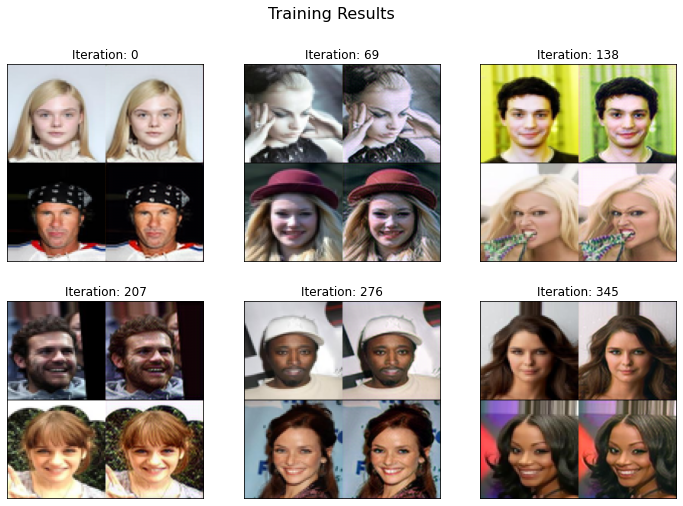

In [191]:
visualize_training_images(dataset_name, num_images=6)

# Dataset Dogs

## Loading New Dataset and Creating New Parameters

In [202]:
import os
import numpy as np
from torchvision.utils import save_image, make_grid
from torch.autograd import Variable
import torch.nn as nn
import torch

# Parameters
epoch = 0
n_epochs = 5
dataset_name ="img_dogs"
batch_size = 2
lr = 0.0002
b1 = 0.9
b2 = 0.999
decay_epoch = 5
n_cpu = 1
hr_height = 256
hr_width = 256
channels = 3
sample_interval = 10
checkpoint_interval = 50
residual_blocks = 23
warmup_batches = 500
lambda_adv = 5e-3
lambda_pixel = 1e-2
hr_shape = (256, 256)

dogs_full_data_list = get_full_list_within_folders(f"./data/{dataset_name}")

TOTAL_SIZE = len(dogs_full_data_list)
TRAIN_SIZE = int(1/8 * TOTAL_SIZE)
VAL_SIZE = int(1/8 * TOTAL_SIZE)
TEST_SIZE = int(1/8 * TOTAL_SIZE)

os.makedirs(f"images/{dataset_name}/training", exist_ok=True)
os.makedirs(f"saved_models/{dataset_name}", exist_ok=True)



train_dataset = ImgDataset(dogs_full_data_list[:TRAIN_SIZE], hr_shape)
val_dataset = ImgDataset(dogs_full_data_list[TRAIN_SIZE: TRAIN_SIZE + VAL_SIZE], hr_shape)
test_dataset = ImgDataset(dogs_full_data_list[TRAIN_SIZE + VAL_SIZE: TRAIN_SIZE + VAL_SIZE + TEST_SIZE], hr_shape)

print("Training Set Size:", len(train_dataset))
print("Validation Set Size:", len(val_dataset))
print("Test Set Size:", len(test_dataset))

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=1, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=False
)

Training Set Size: 2572
Validation Set Size: 2572
Test Set Size: 2572


## Visualizing Dog Model

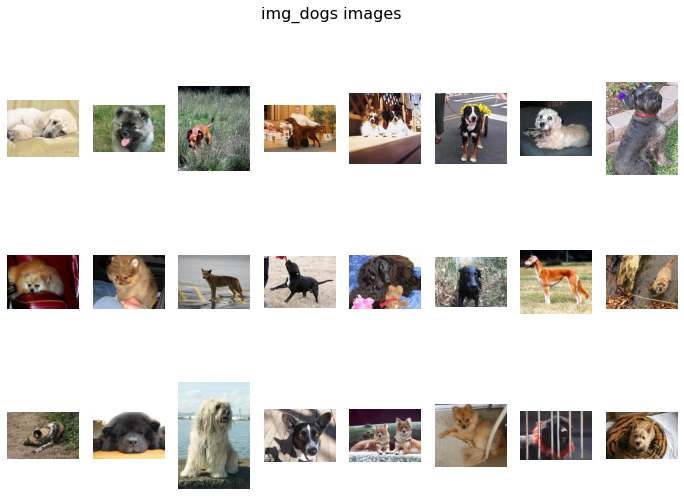

In [167]:
train_dataset.visualize_dataset(nrows=3, ncols=8, dataset_name=dataset_name)

## Training New Model

In [182]:
# ----------
#  Training
# ----------
best_disc_score, best_gen_score = 5, 5
best_disc, best_gen = discriminator.state_dict(), generator.state_dict()
for epoch in range(epoch, n_epochs):
    for i, imgs in enumerate(train_loader):

        batches_done = epoch * len(train_loader) + i

        # Configure model input
        imgs_lr = Variable(imgs["lr"].type(Tensor))
        imgs_hr = Variable(imgs["hr"].type(Tensor))

        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)

        # ------------------
        #  Train Generators
        # ------------------

        optimizer_G.zero_grad()

        # Generate a high resolution image from low resolution input
        # Forward pass for generator
        gen_hr = generator(imgs_lr)

        # Measure pixel-wise loss against ground truth
        loss_pixel = criterion_pixel(gen_hr, imgs_hr)

        if batches_done < warmup_batches:
            # Warm-up (pixel-wise loss only)
            loss_pixel.backward()
            optimizer_G.step()
            print(
                "[Epoch %d/%d] [Batch %d/%d] [G pixel: %f]"
                % (epoch, n_epochs, i, len(train_loader), loss_pixel.item())
            )
            continue

        # Extract validity predictions from discriminator
        pred_real = discriminator(imgs_hr).detach()
        pred_fake = discriminator(gen_hr)

        # Adversarial loss (relativistic average GAN)
        loss_GAN = criterion_GAN(pred_fake - pred_real.mean(0, keepdim=True), valid)

        # Content loss
        gen_features = feature_extractor(gen_hr)
        real_features = feature_extractor(imgs_hr).detach()
        loss_content = criterion_content(gen_features, real_features)

        # Total generator loss
        loss_G = loss_content + lambda_adv * loss_GAN + lambda_pixel * loss_pixel

        loss_G.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        pred_real = discriminator(imgs_hr)
        pred_fake = discriminator(gen_hr.detach())

        # Adversarial loss for real and fake images (relativistic average GAN)
        loss_real = criterion_GAN(pred_real - pred_fake.mean(0, keepdim=True), valid)
        loss_fake = criterion_GAN(pred_fake - pred_real.mean(0, keepdim=True), fake)

        # Total loss
        loss_D = (loss_real + loss_fake) / 2

        loss_D.backward()
        optimizer_D.step()

        # --------------
        #  Log Progress
        # --------------

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, content: %f, adv: %f, pixel: %f]"
            % (
                epoch,
                n_epochs,
                i,
                len(train_loader),
                loss_D.item(),
                loss_G.item(),
                loss_content.item(),
                loss_GAN.item(),
                loss_pixel.item(),
            )
        )

        # Get best discriminator and best generator
        if best_disc_score > loss_D.item():
            best_disc_score = loss_D.item()
            best_disc = discriminator.state_dict()

        if best_gen_score > loss_G.item():
            best_gen_score = loss_G.item()
            best_gen = generator.state_dict()


        if batches_done % sample_interval == 0:
            # Save image grid with upsampled inputs and ESRGAN outputs
            print(f"Saving image after {batches_done} batches done")
            imgs_lr = nn.functional.interpolate(imgs_lr, scale_factor=4)
            img_grid = denormalize(torch.cat((imgs_lr, gen_hr), -1))
            save_image(img_grid, f"images/{dataset_name}/training/{batches_done}.png", nrow=1, normalize=False)

        if batches_done % checkpoint_interval == 0:
            # Save model checkpoints
            print(f"Saving model from epoch {epoch}")
            torch.save(generator.state_dict(), f"saved_models/{dataset_name}/generator_{epoch}.pth")
            torch.save(discriminator.state_dict(), f"saved_models/{dataset_name}/discriminator_{epoch}.pth")

# Save best models
torch.save(best_gen, f"saved_models/{dataset_name}/best_generator.pth")
torch.save(best_disc, f"saved_models/{dataset_name}/best_discriminator.pth")

[Epoch 0/5] [Batch 0/1286] [G pixel: 1.073660]
[Epoch 0/5] [Batch 1/1286] [G pixel: 0.937681]
[Epoch 0/5] [Batch 2/1286] [G pixel: 0.600565]
[Epoch 0/5] [Batch 3/1286] [G pixel: 0.653258]
[Epoch 0/5] [Batch 4/1286] [G pixel: 0.557299]
[Epoch 0/5] [Batch 5/1286] [G pixel: 0.673844]
[Epoch 0/5] [Batch 6/1286] [G pixel: 0.497259]
[Epoch 0/5] [Batch 7/1286] [G pixel: 0.429310]
[Epoch 0/5] [Batch 8/1286] [G pixel: 0.338995]
[Epoch 0/5] [Batch 9/1286] [G pixel: 0.476459]
[Epoch 0/5] [Batch 10/1286] [G pixel: 0.459840]
[Epoch 0/5] [Batch 11/1286] [G pixel: 0.469705]
[Epoch 0/5] [Batch 12/1286] [G pixel: 0.430531]
[Epoch 0/5] [Batch 13/1286] [G pixel: 0.295027]
[Epoch 0/5] [Batch 14/1286] [G pixel: 0.359656]
[Epoch 0/5] [Batch 15/1286] [G pixel: 0.389978]
[Epoch 0/5] [Batch 16/1286] [G pixel: 0.277940]
[Epoch 0/5] [Batch 17/1286] [G pixel: 0.346324]
[Epoch 0/5] [Batch 18/1286] [G pixel: 0.332836]
[Epoch 0/5] [Batch 19/1286] [G pixel: 0.365871]
[Epoch 0/5] [Batch 20/1286] [G pixel: 0.246060]
[E

[Epoch 0/5] [Batch 170/1286] [G pixel: 0.241381]
[Epoch 0/5] [Batch 171/1286] [G pixel: 0.195475]
[Epoch 0/5] [Batch 172/1286] [G pixel: 0.292171]
[Epoch 0/5] [Batch 173/1286] [G pixel: 0.235586]
[Epoch 0/5] [Batch 174/1286] [G pixel: 0.204395]
[Epoch 0/5] [Batch 175/1286] [G pixel: 0.187607]
[Epoch 0/5] [Batch 176/1286] [G pixel: 0.269077]
[Epoch 0/5] [Batch 177/1286] [G pixel: 0.202713]
[Epoch 0/5] [Batch 178/1286] [G pixel: 0.201285]
[Epoch 0/5] [Batch 179/1286] [G pixel: 0.201227]
[Epoch 0/5] [Batch 180/1286] [G pixel: 0.284786]
[Epoch 0/5] [Batch 181/1286] [G pixel: 0.224510]
[Epoch 0/5] [Batch 182/1286] [G pixel: 0.219855]
[Epoch 0/5] [Batch 183/1286] [G pixel: 0.269802]
[Epoch 0/5] [Batch 184/1286] [G pixel: 0.160992]
[Epoch 0/5] [Batch 185/1286] [G pixel: 0.249119]
[Epoch 0/5] [Batch 186/1286] [G pixel: 0.222516]
[Epoch 0/5] [Batch 187/1286] [G pixel: 0.218784]
[Epoch 0/5] [Batch 188/1286] [G pixel: 0.259246]
[Epoch 0/5] [Batch 189/1286] [G pixel: 0.212887]
[Epoch 0/5] [Batch 1

[Epoch 0/5] [Batch 338/1286] [G pixel: 0.154876]
[Epoch 0/5] [Batch 339/1286] [G pixel: 0.150402]
[Epoch 0/5] [Batch 340/1286] [G pixel: 0.190699]
[Epoch 0/5] [Batch 341/1286] [G pixel: 0.126250]
[Epoch 0/5] [Batch 342/1286] [G pixel: 0.201631]
[Epoch 0/5] [Batch 343/1286] [G pixel: 0.144712]
[Epoch 0/5] [Batch 344/1286] [G pixel: 0.183623]
[Epoch 0/5] [Batch 345/1286] [G pixel: 0.197311]
[Epoch 0/5] [Batch 346/1286] [G pixel: 0.124853]
[Epoch 0/5] [Batch 347/1286] [G pixel: 0.176356]
[Epoch 0/5] [Batch 348/1286] [G pixel: 0.187724]
[Epoch 0/5] [Batch 349/1286] [G pixel: 0.145440]
[Epoch 0/5] [Batch 350/1286] [G pixel: 0.182855]
[Epoch 0/5] [Batch 351/1286] [G pixel: 0.192877]
[Epoch 0/5] [Batch 352/1286] [G pixel: 0.147293]
[Epoch 0/5] [Batch 353/1286] [G pixel: 0.213327]
[Epoch 0/5] [Batch 354/1286] [G pixel: 0.263684]
[Epoch 0/5] [Batch 355/1286] [G pixel: 0.120963]
[Epoch 0/5] [Batch 356/1286] [G pixel: 0.265813]
[Epoch 0/5] [Batch 357/1286] [G pixel: 0.227556]
[Epoch 0/5] [Batch 3

[Epoch 0/5] [Batch 502/1286] [D loss: 0.717700] [G loss: 2.679372, content: 2.672351, adv: 0.729618, pixel: 0.337318]
[Epoch 0/5] [Batch 503/1286] [D loss: 0.707842] [G loss: 2.745625, content: 2.739736, adv: 0.714094, pixel: 0.231864]
[Epoch 0/5] [Batch 504/1286] [D loss: 0.708887] [G loss: 3.038904, content: 3.032357, adv: 0.721853, pixel: 0.293782]
[Epoch 0/5] [Batch 505/1286] [D loss: 0.713041] [G loss: 2.579048, content: 2.573380, adv: 0.725886, pixel: 0.203903]
[Epoch 0/5] [Batch 506/1286] [D loss: 0.704420] [G loss: 2.319706, content: 2.312126, adv: 0.718493, pixel: 0.398726]
[Epoch 0/5] [Batch 507/1286] [D loss: 0.692948] [G loss: 2.667305, content: 2.660048, adv: 0.732684, pixel: 0.359396]
[Epoch 0/5] [Batch 508/1286] [D loss: 0.695303] [G loss: 2.739396, content: 2.729201, adv: 0.735857, pixel: 0.651503]
[Epoch 0/5] [Batch 509/1286] [D loss: 0.698143] [G loss: 2.381999, content: 2.372710, adv: 0.725422, pixel: 0.566238]
[Epoch 0/5] [Batch 510/1286] [D loss: 0.678361] [G loss:

[Epoch 0/5] [Batch 570/1286] [D loss: 0.004777] [G loss: 2.786150, content: 2.752212, adv: 5.762596, pixel: 0.512456]
Saving image after 570 batches done
[Epoch 0/5] [Batch 571/1286] [D loss: 0.003450] [G loss: 2.489766, content: 2.452758, adv: 5.965587, pixel: 0.718031]
[Epoch 0/5] [Batch 572/1286] [D loss: 0.009050] [G loss: 2.337990, content: 2.305213, adv: 5.109928, pixel: 0.722647]
[Epoch 0/5] [Batch 573/1286] [D loss: 0.004273] [G loss: 2.926179, content: 2.889467, adv: 5.827878, pixel: 0.757288]
[Epoch 0/5] [Batch 574/1286] [D loss: 0.004828] [G loss: 2.335973, content: 2.298230, adv: 5.827901, pixel: 0.860358]
[Epoch 0/5] [Batch 575/1286] [D loss: 0.004137] [G loss: 2.951277, content: 2.915180, adv: 6.025888, pixel: 0.596708]
[Epoch 0/5] [Batch 576/1286] [D loss: 0.004555] [G loss: 2.612374, content: 2.575702, adv: 5.944311, pixel: 0.695029]
[Epoch 0/5] [Batch 577/1286] [D loss: 0.004027] [G loss: 2.936567, content: 2.900536, adv: 5.951184, pixel: 0.627496]
[Epoch 0/5] [Batch 5

[Epoch 0/5] [Batch 638/1286] [D loss: 0.001110] [G loss: 2.635312, content: 2.593507, adv: 7.090676, pixel: 0.635172]
[Epoch 0/5] [Batch 639/1286] [D loss: 0.001272] [G loss: 2.670506, content: 2.629270, adv: 6.902101, pixel: 0.672551]
[Epoch 0/5] [Batch 640/1286] [D loss: 0.001338] [G loss: 2.706676, content: 2.665528, adv: 6.915825, pixel: 0.656904]
Saving image after 640 batches done
[Epoch 0/5] [Batch 641/1286] [D loss: 0.000968] [G loss: 1.921326, content: 1.877606, adv: 7.268993, pixel: 0.737491]
[Epoch 0/5] [Batch 642/1286] [D loss: 0.000882] [G loss: 2.646065, content: 2.603130, adv: 7.341806, pixel: 0.622607]
[Epoch 0/5] [Batch 643/1286] [D loss: 0.001191] [G loss: 2.063341, content: 2.023186, adv: 7.014402, pixel: 0.508283]
[Epoch 0/5] [Batch 644/1286] [D loss: 0.001049] [G loss: 2.462413, content: 2.418653, adv: 7.151485, pixel: 0.800279]
[Epoch 0/5] [Batch 645/1286] [D loss: 0.001601] [G loss: 2.343736, content: 2.303959, adv: 6.784153, pixel: 0.585626]
[Epoch 0/5] [Batch 6

[Epoch 0/5] [Batch 705/1286] [D loss: 0.002685] [G loss: 1.889365, content: 1.852624, adv: 6.213148, pixel: 0.567532]
[Epoch 0/5] [Batch 706/1286] [D loss: 0.001093] [G loss: 2.572643, content: 2.531370, adv: 7.213563, pixel: 0.520539]
[Epoch 0/5] [Batch 707/1286] [D loss: 0.107728] [G loss: 2.328331, content: 2.309848, adv: 2.788193, pixel: 0.454215]
[Epoch 0/5] [Batch 708/1286] [D loss: 0.004300] [G loss: 2.219632, content: 2.184612, adv: 6.061784, pixel: 0.471181]
[Epoch 0/5] [Batch 709/1286] [D loss: 0.002510] [G loss: 2.010018, content: 1.972678, adv: 6.622450, pixel: 0.422711]
[Epoch 0/5] [Batch 710/1286] [D loss: 0.036849] [G loss: 2.432123, content: 2.409733, adv: 3.854645, pixel: 0.311742]
Saving image after 710 batches done
[Epoch 0/5] [Batch 711/1286] [D loss: 0.011200] [G loss: 2.385387, content: 2.354932, adv: 5.319007, pixel: 0.386045]
[Epoch 0/5] [Batch 712/1286] [D loss: 0.005681] [G loss: 2.040178, content: 2.005514, adv: 5.966177, pixel: 0.483294]
[Epoch 0/5] [Batch 7

[Epoch 0/5] [Batch 773/1286] [D loss: 0.000428] [G loss: 1.736762, content: 1.688308, adv: 8.762947, pixel: 0.463929]
[Epoch 0/5] [Batch 774/1286] [D loss: 0.000600] [G loss: 1.825821, content: 1.780002, adv: 8.307981, pixel: 0.427885]
[Epoch 0/5] [Batch 775/1286] [D loss: 0.002010] [G loss: 2.530352, content: 2.490516, adv: 6.903822, pixel: 0.531707]
[Epoch 0/5] [Batch 776/1286] [D loss: 0.005673] [G loss: 2.583049, content: 2.549920, adv: 5.718901, pixel: 0.453443]
[Epoch 0/5] [Batch 777/1286] [D loss: 0.003517] [G loss: 2.118438, content: 2.082106, adv: 6.340394, pixel: 0.462955]
[Epoch 0/5] [Batch 778/1286] [D loss: 0.003310] [G loss: 2.135357, content: 2.099260, adv: 6.276784, pixel: 0.471279]
[Epoch 0/5] [Batch 779/1286] [D loss: 0.001225] [G loss: 2.959610, content: 2.918711, adv: 7.292933, pixel: 0.443448]
[Epoch 0/5] [Batch 780/1286] [D loss: 0.001700] [G loss: 1.929478, content: 1.890269, adv: 6.964192, pixel: 0.438811]
Saving image after 780 batches done
[Epoch 0/5] [Batch 7

[Epoch 0/5] [Batch 841/1286] [D loss: 0.064726] [G loss: 2.098548, content: 2.073967, adv: 3.924689, pixel: 0.495673]
[Epoch 0/5] [Batch 842/1286] [D loss: 0.160985] [G loss: 1.988479, content: 1.969368, adv: 2.967331, pixel: 0.427461]
[Epoch 0/5] [Batch 843/1286] [D loss: 0.238130] [G loss: 2.550383, content: 2.533747, adv: 2.464239, pixel: 0.431487]
[Epoch 0/5] [Batch 844/1286] [D loss: 0.203713] [G loss: 1.776675, content: 1.759659, adv: 2.614380, pixel: 0.394351]
[Epoch 0/5] [Batch 845/1286] [D loss: 0.069587] [G loss: 2.275975, content: 2.247514, adv: 4.920019, pixel: 0.386118]
[Epoch 0/5] [Batch 846/1286] [D loss: 0.125628] [G loss: 2.060305, content: 2.038467, adv: 3.674509, pixel: 0.346574]
[Epoch 0/5] [Batch 847/1286] [D loss: 0.077139] [G loss: 2.435537, content: 2.402666, adv: 5.619226, pixel: 0.477431]
[Epoch 0/5] [Batch 848/1286] [D loss: 0.006043] [G loss: 2.276127, content: 2.231071, adv: 8.126386, pixel: 0.442443]
[Epoch 0/5] [Batch 849/1286] [D loss: 0.229730] [G loss:

[Epoch 0/5] [Batch 909/1286] [D loss: 0.094939] [G loss: 2.736240, content: 2.714198, adv: 3.445750, pixel: 0.481352]
[Epoch 0/5] [Batch 910/1286] [D loss: 0.109418] [G loss: 2.120270, content: 2.103298, adv: 2.687893, pixel: 0.353196]
Saving image after 910 batches done
[Epoch 0/5] [Batch 911/1286] [D loss: 0.024261] [G loss: 2.648146, content: 2.622587, adv: 4.273303, pixel: 0.419196]
[Epoch 0/5] [Batch 912/1286] [D loss: 0.007540] [G loss: 1.729571, content: 1.693244, adv: 6.471992, pixel: 0.396698]
[Epoch 0/5] [Batch 913/1286] [D loss: 0.011824] [G loss: 2.736618, content: 2.704672, adv: 5.513799, pixel: 0.437698]
[Epoch 0/5] [Batch 914/1286] [D loss: 0.065088] [G loss: 1.795484, content: 1.768855, adv: 4.235610, pixel: 0.545126]
[Epoch 0/5] [Batch 915/1286] [D loss: 0.011319] [G loss: 2.024559, content: 1.990197, adv: 5.857559, pixel: 0.507435]
[Epoch 0/5] [Batch 916/1286] [D loss: 0.005048] [G loss: 2.556971, content: 2.520893, adv: 6.286573, pixel: 0.464531]
[Epoch 0/5] [Batch 9

[Epoch 0/5] [Batch 977/1286] [D loss: 0.032469] [G loss: 1.985246, content: 1.961751, adv: 3.819287, pixel: 0.439773]
[Epoch 0/5] [Batch 978/1286] [D loss: 0.058039] [G loss: 1.863975, content: 1.843308, adv: 3.338703, pixel: 0.397372]
[Epoch 0/5] [Batch 979/1286] [D loss: 0.016570] [G loss: 2.931342, content: 2.900107, adv: 4.966408, pixel: 0.640380]
[Epoch 0/5] [Batch 980/1286] [D loss: 0.000276] [G loss: 2.124974, content: 2.068344, adv: 10.419083, pixel: 0.453433]
Saving image after 980 batches done
[Epoch 0/5] [Batch 981/1286] [D loss: 0.004408] [G loss: 2.630127, content: 2.591616, adv: 6.794677, pixel: 0.453770]
[Epoch 0/5] [Batch 982/1286] [D loss: 0.004925] [G loss: 2.073713, content: 2.035562, adv: 6.574137, pixel: 0.528000]
[Epoch 0/5] [Batch 983/1286] [D loss: 0.013249] [G loss: 2.151320, content: 2.115726, adv: 6.092299, pixel: 0.513171]
[Epoch 0/5] [Batch 984/1286] [D loss: 0.033719] [G loss: 1.892900, content: 1.867693, adv: 4.262701, pixel: 0.389404]
[Epoch 0/5] [Batch 

[Epoch 0/5] [Batch 1044/1286] [D loss: 0.007019] [G loss: 2.516416, content: 2.483752, adv: 5.797043, pixel: 0.367879]
[Epoch 0/5] [Batch 1045/1286] [D loss: 0.000902] [G loss: 1.733357, content: 1.685134, adv: 8.842333, pixel: 0.401131]
[Epoch 0/5] [Batch 1046/1286] [D loss: 0.026287] [G loss: 2.183914, content: 2.157481, adv: 4.722244, pixel: 0.282138]
[Epoch 0/5] [Batch 1047/1286] [D loss: 0.147330] [G loss: 2.020725, content: 1.999500, adv: 3.462475, pixel: 0.391168]
[Epoch 0/5] [Batch 1048/1286] [D loss: 0.214299] [G loss: 2.123571, content: 2.108950, adv: 2.383971, pixel: 0.270079]
[Epoch 0/5] [Batch 1049/1286] [D loss: 0.146812] [G loss: 2.369079, content: 2.351896, adv: 2.682141, pixel: 0.377200]
[Epoch 0/5] [Batch 1050/1286] [D loss: 0.014253] [G loss: 1.986823, content: 1.956498, adv: 5.456446, pixel: 0.304329]
Saving image after 1050 batches done
Saving model from epoch 0
[Epoch 0/5] [Batch 1051/1286] [D loss: 0.010853] [G loss: 1.980691, content: 1.949742, adv: 5.661278, pi

[Epoch 0/5] [Batch 1111/1286] [D loss: 0.000227] [G loss: 1.641595, content: 1.588499, adv: 9.879505, pixel: 0.369937]
[Epoch 0/5] [Batch 1112/1286] [D loss: 0.000383] [G loss: 1.826860, content: 1.778197, adv: 9.016790, pixel: 0.357972]
[Epoch 0/5] [Batch 1113/1286] [D loss: 0.000703] [G loss: 2.811488, content: 2.767398, adv: 8.239701, pixel: 0.289123]
[Epoch 0/5] [Batch 1114/1286] [D loss: 0.000161] [G loss: 1.822138, content: 1.768916, adv: 9.950962, pixel: 0.346684]
[Epoch 0/5] [Batch 1115/1286] [D loss: 0.000159] [G loss: 1.789802, content: 1.735797, adv: 10.144320, pixel: 0.328257]
[Epoch 0/5] [Batch 1116/1286] [D loss: 0.001834] [G loss: 2.175729, content: 2.137340, adv: 6.964269, pixel: 0.356743]
[Epoch 0/5] [Batch 1117/1286] [D loss: 0.000271] [G loss: 1.770572, content: 1.720642, adv: 9.503404, pixel: 0.241346]
[Epoch 0/5] [Batch 1118/1286] [D loss: 0.000232] [G loss: 2.473013, content: 2.422363, adv: 9.514191, pixel: 0.307853]
[Epoch 0/5] [Batch 1119/1286] [D loss: 0.000612

[Epoch 0/5] [Batch 1178/1286] [D loss: 0.000357] [G loss: 1.585512, content: 1.534820, adv: 9.409251, pixel: 0.364538]
[Epoch 0/5] [Batch 1179/1286] [D loss: 0.005388] [G loss: 1.758067, content: 1.718956, adv: 7.143880, pixel: 0.339062]
[Epoch 0/5] [Batch 1180/1286] [D loss: 0.000382] [G loss: 2.128728, content: 2.078146, adv: 9.324364, pixel: 0.395956]
Saving image after 1180 batches done
[Epoch 0/5] [Batch 1181/1286] [D loss: 0.004622] [G loss: 1.615991, content: 1.579579, adv: 6.629216, pixel: 0.326627]
[Epoch 0/5] [Batch 1182/1286] [D loss: 0.000315] [G loss: 2.377215, content: 2.322708, adv: 10.099350, pixel: 0.401040]
[Epoch 0/5] [Batch 1183/1286] [D loss: 0.000156] [G loss: 2.047371, content: 1.987258, adv: 11.243399, pixel: 0.389546]
[Epoch 0/5] [Batch 1184/1286] [D loss: 0.000130] [G loss: 2.636088, content: 2.576683, adv: 11.156902, pixel: 0.362016]
[Epoch 0/5] [Batch 1185/1286] [D loss: 0.000302] [G loss: 2.252778, content: 2.198995, adv: 10.035625, pixel: 0.360527]
[Epoch 

[Epoch 0/5] [Batch 1245/1286] [D loss: 0.000101] [G loss: 2.013396, content: 1.954746, adv: 11.019016, pixel: 0.355475]
[Epoch 0/5] [Batch 1246/1286] [D loss: 0.001367] [G loss: 2.070617, content: 2.029475, adv: 7.555254, pixel: 0.336540]
[Epoch 0/5] [Batch 1247/1286] [D loss: 0.002152] [G loss: 1.844500, content: 1.806267, adv: 7.136447, pixel: 0.255156]
[Epoch 0/5] [Batch 1248/1286] [D loss: 0.000811] [G loss: 1.692783, content: 1.648622, adv: 8.213768, pixel: 0.309193]
[Epoch 0/5] [Batch 1249/1286] [D loss: 0.000808] [G loss: 1.859273, content: 1.816673, adv: 7.924960, pixel: 0.297449]
[Epoch 0/5] [Batch 1250/1286] [D loss: 0.001139] [G loss: 2.502735, content: 2.459542, adv: 7.810341, pixel: 0.414104]
Saving image after 1250 batches done
Saving model from epoch 0
[Epoch 0/5] [Batch 1251/1286] [D loss: 0.000904] [G loss: 2.679708, content: 2.637219, adv: 7.909697, pixel: 0.294016]
[Epoch 0/5] [Batch 1252/1286] [D loss: 0.000806] [G loss: 2.373884, content: 2.330491, adv: 8.112879, p

[Epoch 1/5] [Batch 26/1286] [D loss: 0.000049] [G loss: 2.101398, content: 2.034489, adv: 12.680335, pixel: 0.350691]
[Epoch 1/5] [Batch 27/1286] [D loss: 0.011806] [G loss: 2.186746, content: 2.155487, adv: 5.212301, pixel: 0.519766]
[Epoch 1/5] [Batch 28/1286] [D loss: 0.001438] [G loss: 1.533875, content: 1.488907, adv: 8.284517, pixel: 0.354613]
[Epoch 1/5] [Batch 29/1286] [D loss: 0.003129] [G loss: 1.764086, content: 1.723313, adv: 7.430205, pixel: 0.362202]
[Epoch 1/5] [Batch 30/1286] [D loss: 0.000168] [G loss: 2.124285, content: 2.068634, adv: 10.569445, pixel: 0.280339]
[Epoch 1/5] [Batch 31/1286] [D loss: 0.000057] [G loss: 1.820765, content: 1.762093, adv: 11.226665, pixel: 0.253872]
[Epoch 1/5] [Batch 32/1286] [D loss: 0.000111] [G loss: 1.578624, content: 1.518618, adv: 11.347445, pixel: 0.326834]
[Epoch 1/5] [Batch 33/1286] [D loss: 0.000908] [G loss: 2.000563, content: 1.954817, adv: 8.609803, pixel: 0.269731]
[Epoch 1/5] [Batch 34/1286] [D loss: 0.000143] [G loss: 2.45

[Epoch 1/5] [Batch 94/1286] [D loss: 0.190939] [G loss: 1.685145, content: 1.670160, adv: 2.286530, pixel: 0.355279]
Saving image after 1380 batches done
[Epoch 1/5] [Batch 95/1286] [D loss: 0.000021] [G loss: 2.096710, content: 2.029236, adv: 12.779245, pixel: 0.357825]
[Epoch 1/5] [Batch 96/1286] [D loss: 0.000530] [G loss: 2.184763, content: 2.140433, adv: 8.215182, pixel: 0.325399]
[Epoch 1/5] [Batch 97/1286] [D loss: 0.001691] [G loss: 2.042193, content: 2.001290, adv: 7.571557, pixel: 0.304514]
[Epoch 1/5] [Batch 98/1286] [D loss: 0.010976] [G loss: 1.940680, content: 1.906243, adv: 6.011002, pixel: 0.438194]
[Epoch 1/5] [Batch 99/1286] [D loss: 0.037027] [G loss: 2.104608, content: 2.078573, adv: 4.667038, pixel: 0.269953]
[Epoch 1/5] [Batch 100/1286] [D loss: 0.003223] [G loss: 1.937384, content: 1.901197, adv: 6.734504, pixel: 0.251418]
[Epoch 1/5] [Batch 101/1286] [D loss: 0.000801] [G loss: 2.166904, content: 2.123048, adv: 8.162317, pixel: 0.304427]
[Epoch 1/5] [Batch 102/1

[Epoch 1/5] [Batch 161/1286] [D loss: 0.000207] [G loss: 2.038635, content: 1.987753, adv: 9.487420, pixel: 0.344544]
[Epoch 1/5] [Batch 162/1286] [D loss: 0.000729] [G loss: 2.001260, content: 1.958994, adv: 7.861578, pixel: 0.295786]
[Epoch 1/5] [Batch 163/1286] [D loss: 0.000047] [G loss: 1.407051, content: 1.347564, adv: 11.261404, pixel: 0.318014]
[Epoch 1/5] [Batch 164/1286] [D loss: 0.000038] [G loss: 1.488949, content: 1.429880, adv: 11.366634, pixel: 0.223564]
Saving image after 1450 batches done
Saving model from epoch 1
[Epoch 1/5] [Batch 165/1286] [D loss: 0.000035] [G loss: 1.824582, content: 1.763116, adv: 11.724495, pixel: 0.284272]
[Epoch 1/5] [Batch 166/1286] [D loss: 0.009119] [G loss: 2.454518, content: 2.423365, adv: 5.563147, pixel: 0.333738]
[Epoch 1/5] [Batch 167/1286] [D loss: 0.000593] [G loss: 1.857478, content: 1.813833, adv: 8.283348, pixel: 0.222823]
[Epoch 1/5] [Batch 168/1286] [D loss: 0.000034] [G loss: 1.828175, content: 1.767022, adv: 11.746385, pixel:

[Epoch 1/5] [Batch 228/1286] [D loss: 0.000475] [G loss: 2.015550, content: 1.964165, adv: 9.330730, pixel: 0.473088]
[Epoch 1/5] [Batch 229/1286] [D loss: 0.001346] [G loss: 2.132931, content: 2.090343, adv: 7.781956, pixel: 0.367800]
[Epoch 1/5] [Batch 230/1286] [D loss: 0.001534] [G loss: 1.856348, content: 1.816131, adv: 7.560296, pixel: 0.241507]
[Epoch 1/5] [Batch 231/1286] [D loss: 0.002694] [G loss: 1.824046, content: 1.786031, adv: 6.762286, pixel: 0.420445]
[Epoch 1/5] [Batch 232/1286] [D loss: 0.062529] [G loss: 2.004861, content: 1.979826, adv: 4.351186, pixel: 0.327891]
[Epoch 1/5] [Batch 233/1286] [D loss: 0.000117] [G loss: 2.520149, content: 2.463706, adv: 10.519518, pixel: 0.384591]
[Epoch 1/5] [Batch 234/1286] [D loss: 0.000361] [G loss: 1.742689, content: 1.695931, adv: 8.767033, pixel: 0.292277]
Saving image after 1520 batches done
[Epoch 1/5] [Batch 235/1286] [D loss: 0.000160] [G loss: 1.658825, content: 1.607107, adv: 9.813477, pixel: 0.265139]
[Epoch 1/5] [Batch

[Epoch 1/5] [Batch 295/1286] [D loss: 0.009531] [G loss: 1.641705, content: 1.607386, adv: 6.168252, pixel: 0.347740]
[Epoch 1/5] [Batch 296/1286] [D loss: 0.033592] [G loss: 1.754409, content: 1.727645, adv: 4.567996, pixel: 0.392414]
[Epoch 1/5] [Batch 297/1286] [D loss: 0.000044] [G loss: 2.050940, content: 1.985847, adv: 12.500597, pixel: 0.259005]
[Epoch 1/5] [Batch 298/1286] [D loss: 0.000014] [G loss: 1.681279, content: 1.608198, adv: 13.939575, pixel: 0.338393]
[Epoch 1/5] [Batch 299/1286] [D loss: 0.000022] [G loss: 2.293666, content: 2.224846, adv: 13.158876, pixel: 0.302517]
[Epoch 1/5] [Batch 300/1286] [D loss: 0.001405] [G loss: 2.368940, content: 2.324814, adv: 8.075678, pixel: 0.374712]
[Epoch 1/5] [Batch 301/1286] [D loss: 0.000840] [G loss: 2.667913, content: 2.616056, adv: 9.523964, pixel: 0.423731]
[Epoch 1/5] [Batch 302/1286] [D loss: 0.001746] [G loss: 1.735950, content: 1.691819, adv: 8.208279, pixel: 0.308963]
[Epoch 1/5] [Batch 303/1286] [D loss: 0.005630] [G lo

[Epoch 1/5] [Batch 363/1286] [D loss: 0.000041] [G loss: 1.730345, content: 1.670515, adv: 11.394966, pixel: 0.285516]
[Epoch 1/5] [Batch 364/1286] [D loss: 0.000080] [G loss: 1.915628, content: 1.856919, adv: 11.053552, pixel: 0.344081]
Saving image after 1650 batches done
Saving model from epoch 1
[Epoch 1/5] [Batch 365/1286] [D loss: 0.000512] [G loss: 1.910127, content: 1.864518, adv: 8.370522, pixel: 0.375645]
[Epoch 1/5] [Batch 366/1286] [D loss: 0.000271] [G loss: 2.376283, content: 2.325923, adv: 9.297796, pixel: 0.387062]
[Epoch 1/5] [Batch 367/1286] [D loss: 0.000073] [G loss: 2.040997, content: 1.983103, adv: 10.804572, pixel: 0.387170]
[Epoch 1/5] [Batch 368/1286] [D loss: 0.000178] [G loss: 1.637134, content: 1.582897, adv: 10.270632, pixel: 0.288385]
[Epoch 1/5] [Batch 369/1286] [D loss: 0.000261] [G loss: 1.727587, content: 1.676046, adv: 9.660597, pixel: 0.323749]
[Epoch 1/5] [Batch 370/1286] [D loss: 0.000111] [G loss: 2.682121, content: 2.626925, adv: 10.330681, pixel

[Epoch 1/5] [Batch 430/1286] [D loss: 0.000123] [G loss: 1.911953, content: 1.858985, adv: 9.857197, pixel: 0.368175]
[Epoch 1/5] [Batch 431/1286] [D loss: 0.000043] [G loss: 2.549993, content: 2.489435, adv: 11.192326, pixel: 0.459654]
[Epoch 1/5] [Batch 432/1286] [D loss: 0.000649] [G loss: 1.805023, content: 1.759255, adv: 8.270306, pixel: 0.441708]
[Epoch 1/5] [Batch 433/1286] [D loss: 0.000207] [G loss: 2.001468, content: 1.951067, adv: 9.253877, pixel: 0.413165]
[Epoch 1/5] [Batch 434/1286] [D loss: 0.000059] [G loss: 2.178243, content: 2.118674, adv: 10.958229, pixel: 0.477803]
Saving image after 1720 batches done
[Epoch 1/5] [Batch 435/1286] [D loss: 0.000077] [G loss: 2.183253, content: 2.123276, adv: 11.133694, pixel: 0.430858]
[Epoch 1/5] [Batch 436/1286] [D loss: 0.000016] [G loss: 1.844274, content: 1.779002, adv: 12.310863, pixel: 0.371833]
[Epoch 1/5] [Batch 437/1286] [D loss: 0.000098] [G loss: 2.357326, content: 2.301910, adv: 10.312808, pixel: 0.385187]
[Epoch 1/5] [B

[Epoch 1/5] [Batch 497/1286] [D loss: 0.000028] [G loss: 1.756583, content: 1.693305, adv: 11.933446, pixel: 0.361068]
[Epoch 1/5] [Batch 498/1286] [D loss: 0.000044] [G loss: 2.104351, content: 2.042701, adv: 11.568367, pixel: 0.380793]
[Epoch 1/5] [Batch 499/1286] [D loss: 0.000031] [G loss: 2.551519, content: 2.489093, adv: 11.724211, pixel: 0.380484]
[Epoch 1/5] [Batch 500/1286] [D loss: 0.000029] [G loss: 1.880335, content: 1.820275, adv: 11.379421, pixel: 0.316258]
[Epoch 1/5] [Batch 501/1286] [D loss: 0.000035] [G loss: 1.542750, content: 1.482643, adv: 11.577313, pixel: 0.222114]
[Epoch 1/5] [Batch 502/1286] [D loss: 0.000022] [G loss: 1.910326, content: 1.849110, adv: 11.749433, pixel: 0.246928]
[Epoch 1/5] [Batch 503/1286] [D loss: 0.000045] [G loss: 2.286347, content: 2.225242, adv: 11.538205, pixel: 0.341382]
[Epoch 1/5] [Batch 504/1286] [D loss: 0.000027] [G loss: 2.660623, content: 2.596050, adv: 11.995562, pixel: 0.459489]
Saving image after 1790 batches done
[Epoch 1/5]

[Epoch 1/5] [Batch 564/1286] [D loss: 0.005454] [G loss: 1.777345, content: 1.737763, adv: 7.330867, pixel: 0.292766]
Saving image after 1850 batches done
Saving model from epoch 1
[Epoch 1/5] [Batch 565/1286] [D loss: 0.002377] [G loss: 2.371899, content: 2.327752, adv: 8.187284, pixel: 0.321012]
[Epoch 1/5] [Batch 566/1286] [D loss: 0.000923] [G loss: 2.339552, content: 2.290856, adv: 8.822973, pixel: 0.458038]
[Epoch 1/5] [Batch 567/1286] [D loss: 0.002424] [G loss: 2.377493, content: 2.335692, adv: 7.652060, pixel: 0.354104]
[Epoch 1/5] [Batch 568/1286] [D loss: 0.002107] [G loss: 1.852800, content: 1.808646, adv: 8.187901, pixel: 0.321420]
[Epoch 1/5] [Batch 569/1286] [D loss: 0.000387] [G loss: 2.427868, content: 2.374801, adv: 9.940408, pixel: 0.336482]
[Epoch 1/5] [Batch 570/1286] [D loss: 0.003272] [G loss: 1.818792, content: 1.779261, adv: 7.324208, pixel: 0.290977]
[Epoch 1/5] [Batch 571/1286] [D loss: 0.000877] [G loss: 1.620849, content: 1.573519, adv: 9.055359, pixel: 0.2

[Epoch 1/5] [Batch 631/1286] [D loss: 0.000018] [G loss: 2.023146, content: 1.959281, adv: 12.269281, pixel: 0.251877]
[Epoch 1/5] [Batch 632/1286] [D loss: 0.000008] [G loss: 2.232052, content: 2.160649, adv: 13.777557, pixel: 0.251501]
[Epoch 1/5] [Batch 633/1286] [D loss: 0.000174] [G loss: 1.412960, content: 1.360485, adv: 9.940256, pixel: 0.277369]
[Epoch 1/5] [Batch 634/1286] [D loss: 0.000091] [G loss: 1.900850, content: 1.845345, adv: 10.533871, pixel: 0.283549]
Saving image after 1920 batches done
[Epoch 1/5] [Batch 635/1286] [D loss: 0.000013] [G loss: 2.059945, content: 1.991347, adv: 13.006994, pixel: 0.356355]
[Epoch 1/5] [Batch 636/1286] [D loss: 0.000054] [G loss: 1.821382, content: 1.758561, adv: 11.858799, pixel: 0.352683]
[Epoch 1/5] [Batch 637/1286] [D loss: 0.000164] [G loss: 1.524490, content: 1.473266, adv: 9.645680, pixel: 0.299579]
[Epoch 1/5] [Batch 638/1286] [D loss: 0.000032] [G loss: 1.604977, content: 1.542374, adv: 11.995895, pixel: 0.262336]
[Epoch 1/5] [

[Epoch 1/5] [Batch 698/1286] [D loss: 0.000623] [G loss: 2.248775, content: 2.204803, adv: 8.297276, pixel: 0.248556]
[Epoch 1/5] [Batch 699/1286] [D loss: 0.000189] [G loss: 2.051364, content: 2.000043, adv: 9.497995, pixel: 0.383088]
[Epoch 1/5] [Batch 700/1286] [D loss: 0.000022] [G loss: 2.126298, content: 2.063527, adv: 11.817515, pixel: 0.368392]
[Epoch 1/5] [Batch 701/1286] [D loss: 0.000037] [G loss: 2.112182, content: 2.051679, adv: 11.567229, pixel: 0.266662]
[Epoch 1/5] [Batch 702/1286] [D loss: 0.000005] [G loss: 1.650103, content: 1.577655, adv: 13.973399, pixel: 0.258108]
[Epoch 1/5] [Batch 703/1286] [D loss: 0.000175] [G loss: 1.532828, content: 1.480652, adv: 9.791741, pixel: 0.321754]
[Epoch 1/5] [Batch 704/1286] [D loss: 0.000006] [G loss: 1.667486, content: 1.595771, adv: 13.739814, pixel: 0.301567]
Saving image after 1990 batches done
[Epoch 1/5] [Batch 705/1286] [D loss: 0.000040] [G loss: 2.720081, content: 2.660621, adv: 11.316311, pixel: 0.287810]
[Epoch 1/5] [B

[Epoch 1/5] [Batch 765/1286] [D loss: 0.000007] [G loss: 2.011522, content: 1.940558, adv: 13.555647, pixel: 0.318591]
[Epoch 1/5] [Batch 766/1286] [D loss: 0.000344] [G loss: 2.189437, content: 2.142405, adv: 8.826044, pixel: 0.290176]
[Epoch 1/5] [Batch 767/1286] [D loss: 0.000007] [G loss: 2.532204, content: 2.460754, adv: 13.548525, pixel: 0.370738]
[Epoch 1/5] [Batch 768/1286] [D loss: 0.001339] [G loss: 1.592083, content: 1.553102, adv: 7.096847, pixel: 0.349704]
[Epoch 1/5] [Batch 769/1286] [D loss: 0.000157] [G loss: 2.176940, content: 2.124426, adv: 9.776674, pixel: 0.363023]
[Epoch 1/5] [Batch 770/1286] [D loss: 0.007569] [G loss: 1.819170, content: 1.787471, adv: 5.392560, pixel: 0.473608]
[Epoch 1/5] [Batch 771/1286] [D loss: 0.087932] [G loss: 1.627385, content: 1.609595, adv: 2.868020, pixel: 0.345004]
[Epoch 1/5] [Batch 772/1286] [D loss: 0.002211] [G loss: 1.655894, content: 1.617989, adv: 6.893378, pixel: 0.343747]
[Epoch 1/5] [Batch 773/1286] [D loss: 0.003252] [G los

[Epoch 1/5] [Batch 833/1286] [D loss: 0.000743] [G loss: 2.095926, content: 2.044542, adv: 9.606009, pixel: 0.335401]
[Epoch 1/5] [Batch 834/1286] [D loss: 0.000391] [G loss: 1.804811, content: 1.751034, adv: 10.185774, pixel: 0.284823]
Saving image after 2120 batches done
[Epoch 1/5] [Batch 835/1286] [D loss: 0.000871] [G loss: 1.654047, content: 1.594340, adv: 11.358562, pixel: 0.291379]
[Epoch 1/5] [Batch 836/1286] [D loss: 0.000671] [G loss: 2.063258, content: 2.010108, adv: 10.110103, pixel: 0.259924]
[Epoch 1/5] [Batch 837/1286] [D loss: 0.000334] [G loss: 2.024164, content: 1.965464, adv: 11.126118, pixel: 0.306978]
[Epoch 1/5] [Batch 838/1286] [D loss: 0.000478] [G loss: 2.332359, content: 2.274839, adv: 10.820655, pixel: 0.341701]
[Epoch 1/5] [Batch 839/1286] [D loss: 0.001622] [G loss: 2.169696, content: 2.117687, adv: 9.683167, pixel: 0.359297]
[Epoch 1/5] [Batch 840/1286] [D loss: 0.000291] [G loss: 1.855699, content: 1.793747, adv: 11.843690, pixel: 0.273351]
[Epoch 1/5] [

[Epoch 1/5] [Batch 900/1286] [D loss: 0.000089] [G loss: 2.175295, content: 2.116121, adv: 11.194290, pixel: 0.320204]
[Epoch 1/5] [Batch 901/1286] [D loss: 0.000052] [G loss: 2.152981, content: 2.088298, adv: 12.314110, pixel: 0.311155]
[Epoch 1/5] [Batch 902/1286] [D loss: 0.000233] [G loss: 1.754750, content: 1.703359, adv: 9.908564, pixel: 0.184775]
[Epoch 1/5] [Batch 903/1286] [D loss: 0.000674] [G loss: 2.006393, content: 1.962320, adv: 8.343531, pixel: 0.235579]
[Epoch 1/5] [Batch 904/1286] [D loss: 0.000529] [G loss: 1.977230, content: 1.930859, adv: 8.809150, pixel: 0.232478]
Saving image after 2190 batches done
[Epoch 1/5] [Batch 905/1286] [D loss: 0.002458] [G loss: 1.980116, content: 1.943236, adv: 6.865061, pixel: 0.255478]
[Epoch 1/5] [Batch 906/1286] [D loss: 0.000851] [G loss: 1.754698, content: 1.711873, adv: 8.149905, pixel: 0.207542]
[Epoch 1/5] [Batch 907/1286] [D loss: 0.000603] [G loss: 2.272517, content: 2.227147, adv: 8.627837, pixel: 0.223091]
[Epoch 1/5] [Batc

[Epoch 1/5] [Batch 967/1286] [D loss: 0.000019] [G loss: 2.213580, content: 2.139044, adv: 14.166553, pixel: 0.370355]
[Epoch 1/5] [Batch 968/1286] [D loss: 0.000022] [G loss: 1.782676, content: 1.710664, adv: 13.740801, pixel: 0.330833]
[Epoch 1/5] [Batch 969/1286] [D loss: 0.002840] [G loss: 1.362376, content: 1.311018, adv: 9.361870, pixel: 0.454948]
[Epoch 1/5] [Batch 970/1286] [D loss: 0.001631] [G loss: 2.905769, content: 2.858069, adv: 8.857514, pixel: 0.341214]
[Epoch 1/5] [Batch 971/1286] [D loss: 0.000126] [G loss: 1.955161, content: 1.895180, adv: 11.321775, pixel: 0.337254]
[Epoch 1/5] [Batch 972/1286] [D loss: 0.000022] [G loss: 2.182621, content: 2.114601, adv: 13.063276, pixel: 0.270410]
[Epoch 1/5] [Batch 973/1286] [D loss: 0.000011] [G loss: 2.040617, content: 1.966136, adv: 14.088861, pixel: 0.403621]
[Epoch 1/5] [Batch 974/1286] [D loss: 0.002213] [G loss: 1.909225, content: 1.865726, adv: 8.101889, pixel: 0.298986]
Saving image after 2260 batches done
[Epoch 1/5] [B

[Epoch 1/5] [Batch 1034/1286] [D loss: 0.003327] [G loss: 2.253582, content: 2.189936, adv: 11.985605, pixel: 0.371800]
Saving image after 2320 batches done
[Epoch 1/5] [Batch 1035/1286] [D loss: 0.003017] [G loss: 2.522509, content: 2.458001, adv: 12.097200, pixel: 0.402179]
[Epoch 1/5] [Batch 1036/1286] [D loss: 0.045279] [G loss: 2.024294, content: 1.982900, adv: 7.684871, pixel: 0.297033]
[Epoch 1/5] [Batch 1037/1286] [D loss: 0.000338] [G loss: 1.576264, content: 1.507568, adv: 12.834501, pixel: 0.452419]
[Epoch 1/5] [Batch 1038/1286] [D loss: 0.000548] [G loss: 1.938841, content: 1.877476, adv: 11.527405, pixel: 0.372706]
[Epoch 1/5] [Batch 1039/1286] [D loss: 0.000958] [G loss: 2.415774, content: 2.355904, adv: 11.314990, pixel: 0.329492]
[Epoch 1/5] [Batch 1040/1286] [D loss: 0.000906] [G loss: 2.270483, content: 2.215799, adv: 10.233120, pixel: 0.351801]
[Epoch 1/5] [Batch 1041/1286] [D loss: 0.000453] [G loss: 2.114707, content: 2.052297, adv: 11.899677, pixel: 0.291192]
[Epo

[Epoch 1/5] [Batch 1101/1286] [D loss: 0.000590] [G loss: 2.321673, content: 2.265417, adv: 10.707278, pixel: 0.271972]
[Epoch 1/5] [Batch 1102/1286] [D loss: 0.000257] [G loss: 2.166093, content: 2.105947, adv: 11.481098, pixel: 0.274040]
[Epoch 1/5] [Batch 1103/1286] [D loss: 0.000636] [G loss: 1.582461, content: 1.528632, adv: 10.238305, pixel: 0.263726]
[Epoch 1/5] [Batch 1104/1286] [D loss: 0.000448] [G loss: 2.241836, content: 2.184717, adv: 10.755522, pixel: 0.334111]
Saving image after 2390 batches done
[Epoch 1/5] [Batch 1105/1286] [D loss: 0.000384] [G loss: 1.922123, content: 1.866912, adv: 10.498550, pixel: 0.271796]
[Epoch 1/5] [Batch 1106/1286] [D loss: 0.000100] [G loss: 1.962037, content: 1.897614, adv: 12.441348, pixel: 0.221695]
[Epoch 1/5] [Batch 1107/1286] [D loss: 0.000825] [G loss: 2.127867, content: 2.076012, adv: 9.774071, pixel: 0.298452]
[Epoch 1/5] [Batch 1108/1286] [D loss: 0.000275] [G loss: 2.204759, content: 2.145439, adv: 11.305335, pixel: 0.279320]
[Epo

[Epoch 1/5] [Batch 1167/1286] [D loss: 0.000154] [G loss: 2.584737, content: 2.524194, adv: 11.209509, pixel: 0.449463]
[Epoch 1/5] [Batch 1168/1286] [D loss: 0.000038] [G loss: 2.208701, content: 2.140105, adv: 13.023783, pixel: 0.347658]
[Epoch 1/5] [Batch 1169/1286] [D loss: 0.000010] [G loss: 1.785141, content: 1.710976, adv: 14.251577, pixel: 0.290774]
[Epoch 1/5] [Batch 1170/1286] [D loss: 0.000649] [G loss: 2.033903, content: 1.976891, adv: 10.656642, pixel: 0.372914]
[Epoch 1/5] [Batch 1171/1286] [D loss: 0.000045] [G loss: 2.128626, content: 2.061939, adv: 12.563335, pixel: 0.386980]
[Epoch 1/5] [Batch 1172/1286] [D loss: 0.000525] [G loss: 1.726368, content: 1.677230, adv: 9.209764, pixel: 0.308982]
[Epoch 1/5] [Batch 1173/1286] [D loss: 0.000024] [G loss: 1.424528, content: 1.347018, adv: 14.989772, pixel: 0.256107]
[Epoch 1/5] [Batch 1174/1286] [D loss: 0.000135] [G loss: 1.968214, content: 1.905446, adv: 11.983100, pixel: 0.285262]
Saving image after 2460 batches done
[Epo

[Epoch 1/5] [Batch 1234/1286] [D loss: 0.003770] [G loss: 1.631989, content: 1.595506, adv: 6.773770, pixel: 0.261349]
Saving image after 2520 batches done
[Epoch 1/5] [Batch 1235/1286] [D loss: 0.040095] [G loss: 1.979986, content: 1.955507, adv: 4.423150, pixel: 0.236272]
[Epoch 1/5] [Batch 1236/1286] [D loss: 0.001194] [G loss: 1.601562, content: 1.560835, adv: 7.618477, pixel: 0.263513]
[Epoch 1/5] [Batch 1237/1286] [D loss: 0.000362] [G loss: 1.898767, content: 1.849319, adv: 9.220205, pixel: 0.334707]
[Epoch 1/5] [Batch 1238/1286] [D loss: 0.005964] [G loss: 1.909714, content: 1.877441, adv: 6.016582, pixel: 0.219048]
[Epoch 1/5] [Batch 1239/1286] [D loss: 0.000771] [G loss: 1.835682, content: 1.791294, adv: 8.310178, pixel: 0.283710]
[Epoch 1/5] [Batch 1240/1286] [D loss: 0.000122] [G loss: 1.733414, content: 1.678990, adv: 10.199465, pixel: 0.342727]
[Epoch 1/5] [Batch 1241/1286] [D loss: 0.000075] [G loss: 2.050179, content: 1.993659, adv: 10.745110, pixel: 0.279549]
[Epoch 1/

[Epoch 2/5] [Batch 15/1286] [D loss: 0.000017] [G loss: 2.104508, content: 2.038371, adv: 12.705819, pixel: 0.260806]
[Epoch 2/5] [Batch 16/1286] [D loss: 0.000055] [G loss: 1.654422, content: 1.596962, adv: 10.709412, pixel: 0.391265]
[Epoch 2/5] [Batch 17/1286] [D loss: 0.000012] [G loss: 2.561265, content: 2.494059, adv: 12.716600, pixel: 0.362358]
[Epoch 2/5] [Batch 18/1286] [D loss: 0.000421] [G loss: 1.492674, content: 1.444247, adv: 8.644131, pixel: 0.520638]
Saving image after 2590 batches done
[Epoch 2/5] [Batch 19/1286] [D loss: 0.000006] [G loss: 2.086197, content: 2.015571, adv: 13.462486, pixel: 0.331343]
[Epoch 2/5] [Batch 20/1286] [D loss: 0.000107] [G loss: 1.743427, content: 1.688562, adv: 10.398920, pixel: 0.287074]
[Epoch 2/5] [Batch 21/1286] [D loss: 0.000082] [G loss: 2.128252, content: 2.072645, adv: 10.527628, pixel: 0.296910]
[Epoch 2/5] [Batch 22/1286] [D loss: 0.000010] [G loss: 2.414350, content: 2.344899, adv: 13.161441, pixel: 0.364389]
[Epoch 2/5] [Batch 2

[Epoch 2/5] [Batch 82/1286] [D loss: 0.000015] [G loss: 2.348265, content: 2.282644, adv: 12.439664, pixel: 0.342243]
[Epoch 2/5] [Batch 83/1286] [D loss: 0.000091] [G loss: 1.472522, content: 1.417920, adv: 10.262671, pixel: 0.328891]
[Epoch 2/5] [Batch 84/1286] [D loss: 0.001124] [G loss: 1.836259, content: 1.795686, adv: 7.590012, pixel: 0.262247]
[Epoch 2/5] [Batch 85/1286] [D loss: 0.000086] [G loss: 1.604161, content: 1.548910, adv: 10.510532, pixel: 0.269875]
[Epoch 2/5] [Batch 86/1286] [D loss: 0.000012] [G loss: 1.958539, content: 1.894270, adv: 12.420639, pixel: 0.216576]
[Epoch 2/5] [Batch 87/1286] [D loss: 0.000047] [G loss: 2.222065, content: 2.162467, adv: 11.291229, pixel: 0.314208]
[Epoch 2/5] [Batch 88/1286] [D loss: 0.000007] [G loss: 1.959569, content: 1.888651, adv: 13.483320, pixel: 0.350088]
Saving image after 2660 batches done
[Epoch 2/5] [Batch 89/1286] [D loss: 0.004043] [G loss: 1.607084, content: 1.573980, adv: 5.954608, pixel: 0.333026]
[Epoch 2/5] [Batch 90

[Epoch 2/5] [Batch 149/1286] [D loss: 0.000026] [G loss: 1.474807, content: 1.411667, adv: 12.009239, pixel: 0.309352]
[Epoch 2/5] [Batch 150/1286] [D loss: 0.000003] [G loss: 1.902229, content: 1.820796, adv: 15.528412, pixel: 0.379096]
[Epoch 2/5] [Batch 151/1286] [D loss: 0.000427] [G loss: 2.002252, content: 1.956036, adv: 8.665292, pixel: 0.288909]
[Epoch 2/5] [Batch 152/1286] [D loss: 0.000020] [G loss: 1.988387, content: 1.919505, adv: 13.049223, pixel: 0.363629]
[Epoch 2/5] [Batch 153/1286] [D loss: 0.000043] [G loss: 2.275431, content: 2.216000, adv: 11.290642, pixel: 0.297757]
[Epoch 2/5] [Batch 154/1286] [D loss: 0.000011] [G loss: 1.479972, content: 1.409841, adv: 13.536930, pixel: 0.244592]
[Epoch 2/5] [Batch 155/1286] [D loss: 0.000017] [G loss: 1.794912, content: 1.725345, adv: 13.411385, pixel: 0.250956]
[Epoch 2/5] [Batch 156/1286] [D loss: 0.001297] [G loss: 1.860013, content: 1.816925, adv: 7.976632, pixel: 0.320494]
[Epoch 2/5] [Batch 157/1286] [D loss: 0.000006] [G

[Epoch 2/5] [Batch 216/1286] [D loss: 0.000020] [G loss: 2.183967, content: 2.115902, adv: 12.966986, pixel: 0.323025]
[Epoch 2/5] [Batch 217/1286] [D loss: 0.000000] [G loss: 1.911935, content: 1.805377, adv: 20.490652, pixel: 0.410511]
[Epoch 2/5] [Batch 218/1286] [D loss: 0.000001] [G loss: 1.591342, content: 1.503115, adv: 17.063080, pixel: 0.291177]
Saving image after 2790 batches done
[Epoch 2/5] [Batch 219/1286] [D loss: 0.000019] [G loss: 1.934584, content: 1.862388, adv: 13.819151, pixel: 0.310051]
[Epoch 2/5] [Batch 220/1286] [D loss: 0.000001] [G loss: 1.759658, content: 1.670309, adv: 17.147923, pixel: 0.360862]
[Epoch 2/5] [Batch 221/1286] [D loss: 0.000000] [G loss: 1.997755, content: 1.893909, adv: 20.157850, pixel: 0.305715]
[Epoch 2/5] [Batch 222/1286] [D loss: 0.000000] [G loss: 1.730160, content: 1.626451, adv: 20.098410, pixel: 0.321620]
[Epoch 2/5] [Batch 223/1286] [D loss: 0.000002] [G loss: 1.936279, content: 1.854085, adv: 15.935696, pixel: 0.251572]
[Epoch 2/5]

[Epoch 2/5] [Batch 283/1286] [D loss: 0.000031] [G loss: 1.529217, content: 1.467462, adv: 11.709252, pixel: 0.320830]
[Epoch 2/5] [Batch 284/1286] [D loss: 0.000003] [G loss: 1.828723, content: 1.747962, adv: 15.752523, pixel: 0.199763]
[Epoch 2/5] [Batch 285/1286] [D loss: 0.000001] [G loss: 2.307373, content: 2.215165, adv: 17.721088, pixel: 0.360295]
[Epoch 2/5] [Batch 286/1286] [D loss: 0.000002] [G loss: 1.880453, content: 1.801076, adv: 15.255748, pixel: 0.309818]
[Epoch 2/5] [Batch 287/1286] [D loss: 0.000028] [G loss: 1.982952, content: 1.916326, adv: 12.807596, pixel: 0.258816]
[Epoch 2/5] [Batch 288/1286] [D loss: 0.000036] [G loss: 1.726022, content: 1.659714, adv: 12.593417, pixel: 0.334044]
Saving image after 2860 batches done
[Epoch 2/5] [Batch 289/1286] [D loss: 0.001055] [G loss: 1.820722, content: 1.779532, adv: 7.702945, pixel: 0.267480]
[Epoch 2/5] [Batch 290/1286] [D loss: 0.000009] [G loss: 1.816594, content: 1.743902, adv: 13.823989, pixel: 0.357164]
[Epoch 2/5] 

[Epoch 2/5] [Batch 350/1286] [D loss: 0.000857] [G loss: 1.625419, content: 1.581035, adv: 8.406088, pixel: 0.235367]
[Epoch 2/5] [Batch 351/1286] [D loss: 0.000107] [G loss: 1.649592, content: 1.595143, adv: 10.426612, pixel: 0.231618]
[Epoch 2/5] [Batch 352/1286] [D loss: 0.000127] [G loss: 2.014065, content: 1.958001, adv: 10.539190, pixel: 0.336800]
[Epoch 2/5] [Batch 353/1286] [D loss: 0.000008] [G loss: 1.740520, content: 1.660951, adv: 15.138847, pixel: 0.387447]
[Epoch 2/5] [Batch 354/1286] [D loss: 0.000107] [G loss: 2.407724, content: 2.348776, adv: 11.160295, pixel: 0.314735]
[Epoch 2/5] [Batch 355/1286] [D loss: 0.000020] [G loss: 1.815103, content: 1.745661, adv: 13.396329, pixel: 0.246031]
[Epoch 2/5] [Batch 356/1286] [D loss: 0.000078] [G loss: 2.088496, content: 2.027944, adv: 11.594280, pixel: 0.258131]
[Epoch 2/5] [Batch 357/1286] [D loss: 0.000046] [G loss: 1.864270, content: 1.804113, adv: 11.495739, pixel: 0.267905]
[Epoch 2/5] [Batch 358/1286] [D loss: 0.000008] [

[Epoch 2/5] [Batch 417/1286] [D loss: 0.000656] [G loss: 1.607737, content: 1.563544, adv: 8.024113, pixel: 0.407242]
[Epoch 2/5] [Batch 418/1286] [D loss: 0.000018] [G loss: 1.712638, content: 1.646489, adv: 12.511297, pixel: 0.359217]
Saving image after 2990 batches done
[Epoch 2/5] [Batch 419/1286] [D loss: 0.000154] [G loss: 1.625337, content: 1.572776, adv: 9.842653, pixel: 0.334789]
[Epoch 2/5] [Batch 420/1286] [D loss: 0.000007] [G loss: 1.560915, content: 1.488852, adv: 13.720707, pixel: 0.345949]
[Epoch 2/5] [Batch 421/1286] [D loss: 0.000004] [G loss: 2.267921, content: 2.189669, adv: 15.118727, pixel: 0.265815]
[Epoch 2/5] [Batch 422/1286] [D loss: 0.000034] [G loss: 1.902254, content: 1.840729, adv: 11.772467, pixel: 0.266271]
[Epoch 2/5] [Batch 423/1286] [D loss: 0.000015] [G loss: 2.239974, content: 2.171860, adv: 13.024456, pixel: 0.299124]
[Epoch 2/5] [Batch 424/1286] [D loss: 0.001560] [G loss: 2.311149, content: 2.272113, adv: 7.156328, pixel: 0.325420]
[Epoch 2/5] [B

[Epoch 2/5] [Batch 484/1286] [D loss: 0.000054] [G loss: 2.003104, content: 1.941774, adv: 11.788726, pixel: 0.238641]
[Epoch 2/5] [Batch 485/1286] [D loss: 0.000057] [G loss: 1.644719, content: 1.581147, adv: 11.915177, pixel: 0.399568]
[Epoch 2/5] [Batch 486/1286] [D loss: 0.000015] [G loss: 1.917607, content: 1.845074, adv: 14.100451, pixel: 0.203063]
[Epoch 2/5] [Batch 487/1286] [D loss: 0.000008] [G loss: 2.051861, content: 1.980227, adv: 13.879257, pixel: 0.223751]
[Epoch 2/5] [Batch 488/1286] [D loss: 0.000404] [G loss: 1.914843, content: 1.863728, adv: 9.773134, pixel: 0.224952]
Saving image after 3060 batches done
[Epoch 2/5] [Batch 489/1286] [D loss: 0.000150] [G loss: 2.011816, content: 1.956612, adv: 10.607132, pixel: 0.216742]
[Epoch 2/5] [Batch 490/1286] [D loss: 0.000002] [G loss: 1.912521, content: 1.831582, adv: 15.625414, pixel: 0.281239]
[Epoch 2/5] [Batch 491/1286] [D loss: 0.000009] [G loss: 1.986253, content: 1.913960, adv: 13.902723, pixel: 0.277900]
[Epoch 2/5] 

[Epoch 2/5] [Batch 551/1286] [D loss: 0.000028] [G loss: 2.241931, content: 2.179941, adv: 11.667487, pixel: 0.365261]
[Epoch 2/5] [Batch 552/1286] [D loss: 0.000013] [G loss: 1.974119, content: 1.906661, adv: 12.823385, pixel: 0.334119]
[Epoch 2/5] [Batch 553/1286] [D loss: 0.000002] [G loss: 1.986604, content: 1.903842, adv: 15.858969, pixel: 0.346799]
[Epoch 2/5] [Batch 554/1286] [D loss: 0.000004] [G loss: 1.993844, content: 1.918136, adv: 14.450579, pixel: 0.345487]
[Epoch 2/5] [Batch 555/1286] [D loss: 0.000254] [G loss: 1.543029, content: 1.496052, adv: 9.020375, pixel: 0.187494]
[Epoch 2/5] [Batch 556/1286] [D loss: 0.000002] [G loss: 1.768212, content: 1.687654, adv: 15.579020, pixel: 0.266276]
[Epoch 2/5] [Batch 557/1286] [D loss: 0.000001] [G loss: 2.061951, content: 1.977711, adv: 15.937744, pixel: 0.455180]
[Epoch 2/5] [Batch 558/1286] [D loss: 0.000374] [G loss: 1.697603, content: 1.651427, adv: 8.598162, pixel: 0.318471]
Saving image after 3130 batches done
[Epoch 2/5] [

[Epoch 2/5] [Batch 618/1286] [D loss: 0.000638] [G loss: 1.798149, content: 1.754996, adv: 8.229765, pixel: 0.200492]
Saving image after 3190 batches done
[Epoch 2/5] [Batch 619/1286] [D loss: 0.000028] [G loss: 2.069036, content: 1.998061, adv: 13.302551, pixel: 0.446225]
[Epoch 2/5] [Batch 620/1286] [D loss: 0.000005] [G loss: 1.701897, content: 1.624407, adv: 14.820000, pixel: 0.339034]
[Epoch 2/5] [Batch 621/1286] [D loss: 0.000078] [G loss: 1.984230, content: 1.928474, adv: 10.582029, pixel: 0.284590]
[Epoch 2/5] [Batch 622/1286] [D loss: 0.096914] [G loss: 2.027974, content: 2.000176, adv: 4.851225, pixel: 0.354139]
[Epoch 2/5] [Batch 623/1286] [D loss: 0.000017] [G loss: 1.819264, content: 1.750650, adv: 13.011598, pixel: 0.355604]
[Epoch 2/5] [Batch 624/1286] [D loss: 0.000002] [G loss: 2.130796, content: 2.044364, adv: 16.565521, pixel: 0.360508]
[Epoch 2/5] [Batch 625/1286] [D loss: 0.000014] [G loss: 2.111524, content: 2.038841, adv: 13.568988, pixel: 0.483844]
[Epoch 2/5] [

[Epoch 2/5] [Batch 685/1286] [D loss: 0.000003] [G loss: 2.229456, content: 2.152610, adv: 14.731819, pixel: 0.318655]
[Epoch 2/5] [Batch 686/1286] [D loss: 0.000017] [G loss: 1.379727, content: 1.310468, adv: 13.444963, pixel: 0.203472]
[Epoch 2/5] [Batch 687/1286] [D loss: 0.000122] [G loss: 1.914640, content: 1.858989, adv: 10.563148, pixel: 0.283511]
[Epoch 2/5] [Batch 688/1286] [D loss: 0.000008] [G loss: 1.745121, content: 1.670453, adv: 14.169027, pixel: 0.382327]
Saving image after 3260 batches done
[Epoch 2/5] [Batch 689/1286] [D loss: 0.000022] [G loss: 1.972775, content: 1.905926, adv: 12.486536, pixel: 0.441553]
[Epoch 2/5] [Batch 690/1286] [D loss: 0.000019] [G loss: 2.104271, content: 2.034332, adv: 13.101402, pixel: 0.443282]
[Epoch 2/5] [Batch 691/1286] [D loss: 0.000493] [G loss: 2.296670, content: 2.246013, adv: 9.245724, pixel: 0.442892]
[Epoch 2/5] [Batch 692/1286] [D loss: 0.000019] [G loss: 1.877325, content: 1.810998, adv: 12.697025, pixel: 0.284182]
[Epoch 2/5] 

[Epoch 2/5] [Batch 752/1286] [D loss: 0.002416] [G loss: 1.510095, content: 1.472556, adv: 6.817251, pixel: 0.345256]
[Epoch 2/5] [Batch 753/1286] [D loss: 0.000014] [G loss: 2.343576, content: 2.272843, adv: 13.449331, pixel: 0.348671]
[Epoch 2/5] [Batch 754/1286] [D loss: 0.000007] [G loss: 2.070243, content: 1.998211, adv: 13.726837, pixel: 0.339783]
[Epoch 2/5] [Batch 755/1286] [D loss: 0.000004] [G loss: 1.923143, content: 1.845086, adv: 14.875089, pixel: 0.368213]
[Epoch 2/5] [Batch 756/1286] [D loss: 0.000006] [G loss: 2.071972, content: 1.998405, adv: 14.048869, pixel: 0.332237]
[Epoch 2/5] [Batch 757/1286] [D loss: 0.000006] [G loss: 1.674913, content: 1.599957, adv: 14.336829, pixel: 0.327161]
[Epoch 2/5] [Batch 758/1286] [D loss: 0.000007] [G loss: 1.701426, content: 1.629019, adv: 13.833818, pixel: 0.323792]
Saving image after 3330 batches done
[Epoch 2/5] [Batch 759/1286] [D loss: 0.000006] [G loss: 1.520422, content: 1.447431, adv: 13.988762, pixel: 0.304789]
[Epoch 2/5] 

[Epoch 2/5] [Batch 819/1286] [D loss: 0.000118] [G loss: 1.779262, content: 1.722325, adv: 10.590548, pixel: 0.398420]
[Epoch 2/5] [Batch 820/1286] [D loss: 0.000006] [G loss: 2.039265, content: 1.967400, adv: 13.792101, pixel: 0.290458]
[Epoch 2/5] [Batch 821/1286] [D loss: 0.000002] [G loss: 1.571803, content: 1.491837, adv: 15.493431, pixel: 0.249871]
[Epoch 2/5] [Batch 822/1286] [D loss: 0.000008] [G loss: 2.240342, content: 2.168391, adv: 13.781424, pixel: 0.304376]
[Epoch 2/5] [Batch 823/1286] [D loss: 0.000004] [G loss: 2.088447, content: 2.012186, adv: 14.647829, pixel: 0.302227]
[Epoch 2/5] [Batch 824/1286] [D loss: 0.000005] [G loss: 1.911637, content: 1.837465, adv: 14.405558, pixel: 0.214345]
[Epoch 2/5] [Batch 825/1286] [D loss: 0.000262] [G loss: 1.400693, content: 1.350632, adv: 9.568631, pixel: 0.221743]
[Epoch 2/5] [Batch 826/1286] [D loss: 0.000016] [G loss: 1.459456, content: 1.394788, adv: 12.428279, pixel: 0.252648]
[Epoch 2/5] [Batch 827/1286] [D loss: 0.000014] [

[Epoch 2/5] [Batch 886/1286] [D loss: 0.000001] [G loss: 2.155804, content: 2.068539, adv: 16.818293, pixel: 0.317324]
[Epoch 2/5] [Batch 887/1286] [D loss: 0.000051] [G loss: 1.983480, content: 1.925636, adv: 11.025784, pixel: 0.271517]
[Epoch 2/5] [Batch 888/1286] [D loss: 0.000024] [G loss: 1.673700, content: 1.610734, adv: 11.973541, pixel: 0.309782]
Saving image after 3460 batches done
[Epoch 2/5] [Batch 889/1286] [D loss: 0.000033] [G loss: 1.966432, content: 1.905896, adv: 11.453457, pixel: 0.326865]
[Epoch 2/5] [Batch 890/1286] [D loss: 0.000020] [G loss: 2.213682, content: 2.149848, adv: 12.047793, pixel: 0.359494]
[Epoch 2/5] [Batch 891/1286] [D loss: 0.000002] [G loss: 1.861747, content: 1.780248, adv: 15.457787, pixel: 0.420938]
[Epoch 2/5] [Batch 892/1286] [D loss: 0.000132] [G loss: 1.709209, content: 1.656269, adv: 9.817564, pixel: 0.385259]
[Epoch 2/5] [Batch 893/1286] [D loss: 0.000019] [G loss: 1.800523, content: 1.735869, adv: 12.385851, pixel: 0.272497]
[Epoch 2/5] 

[Epoch 2/5] [Batch 953/1286] [D loss: 0.000104] [G loss: 1.801990, content: 1.744366, adv: 11.060211, pixel: 0.232287]
[Epoch 2/5] [Batch 954/1286] [D loss: 0.000031] [G loss: 1.837594, content: 1.776052, adv: 11.728930, pixel: 0.289810]
[Epoch 2/5] [Batch 955/1286] [D loss: 0.000012] [G loss: 2.213654, content: 2.144494, adv: 13.262617, pixel: 0.284717]
[Epoch 2/5] [Batch 956/1286] [D loss: 0.000006] [G loss: 1.936756, content: 1.856679, adv: 15.325867, pixel: 0.344708]
[Epoch 2/5] [Batch 957/1286] [D loss: 0.000012] [G loss: 2.157434, content: 2.077676, adv: 15.351429, pixel: 0.300154]
[Epoch 2/5] [Batch 958/1286] [D loss: 0.000089] [G loss: 1.653961, content: 1.596840, adv: 10.945826, pixel: 0.239221]
Saving image after 3530 batches done
[Epoch 2/5] [Batch 959/1286] [D loss: 0.000886] [G loss: 2.278327, content: 2.236073, adv: 7.967336, pixel: 0.241733]
[Epoch 2/5] [Batch 960/1286] [D loss: 0.000002] [G loss: 1.699373, content: 1.619542, adv: 15.563487, pixel: 0.201321]
[Epoch 2/5] 

[Epoch 2/5] [Batch 1020/1286] [D loss: 0.015270] [G loss: 1.717697, content: 1.680981, adv: 6.924169, pixel: 0.209476]
[Epoch 2/5] [Batch 1021/1286] [D loss: 0.083428] [G loss: 1.681136, content: 1.661000, adv: 3.524767, pixel: 0.251171]
[Epoch 2/5] [Batch 1022/1286] [D loss: 0.000193] [G loss: 1.625736, content: 1.571323, adv: 10.323730, pixel: 0.279341]
[Epoch 2/5] [Batch 1023/1286] [D loss: 0.000367] [G loss: 1.929861, content: 1.878985, adv: 9.459667, pixel: 0.357715]
[Epoch 2/5] [Batch 1024/1286] [D loss: 0.000022] [G loss: 1.492765, content: 1.423360, adv: 13.270296, pixel: 0.305265]
[Epoch 2/5] [Batch 1025/1286] [D loss: 0.000104] [G loss: 1.477496, content: 1.414146, adv: 11.828897, pixel: 0.420589]
[Epoch 2/5] [Batch 1026/1286] [D loss: 0.000075] [G loss: 1.878221, content: 1.812347, adv: 12.444899, pixel: 0.364972]
[Epoch 2/5] [Batch 1027/1286] [D loss: 0.021820] [G loss: 1.756812, content: 1.722102, adv: 6.252623, pixel: 0.344691]
[Epoch 2/5] [Batch 1028/1286] [D loss: 0.000

[Epoch 2/5] [Batch 1087/1286] [D loss: 0.000204] [G loss: 1.761686, content: 1.703029, adv: 11.139220, pixel: 0.296073]
[Epoch 2/5] [Batch 1088/1286] [D loss: 0.000072] [G loss: 2.003440, content: 1.933880, adv: 13.360089, pixel: 0.275914]
Saving image after 3660 batches done
[Epoch 2/5] [Batch 1089/1286] [D loss: 0.000021] [G loss: 1.835775, content: 1.760761, adv: 14.309832, pixel: 0.346440]
[Epoch 2/5] [Batch 1090/1286] [D loss: 0.000108] [G loss: 1.866415, content: 1.802897, adv: 12.232095, pixel: 0.235714]
[Epoch 2/5] [Batch 1091/1286] [D loss: 0.000343] [G loss: 1.858324, content: 1.804730, adv: 10.156981, pixel: 0.280956]
[Epoch 2/5] [Batch 1092/1286] [D loss: 0.000219] [G loss: 1.791006, content: 1.734544, adv: 10.755651, pixel: 0.268405]
[Epoch 2/5] [Batch 1093/1286] [D loss: 0.001415] [G loss: 2.048679, content: 2.002124, adv: 8.670591, pixel: 0.320190]
[Epoch 2/5] [Batch 1094/1286] [D loss: 0.004397] [G loss: 1.772152, content: 1.732222, adv: 7.318564, pixel: 0.333786]
[Epoc

[Epoch 2/5] [Batch 1154/1286] [D loss: 0.000208] [G loss: 1.895109, content: 1.835059, adv: 11.491899, pixel: 0.259077]
[Epoch 2/5] [Batch 1155/1286] [D loss: 0.000034] [G loss: 2.221145, content: 2.147000, adv: 14.222280, pixel: 0.303309]
[Epoch 2/5] [Batch 1156/1286] [D loss: 0.000015] [G loss: 1.764904, content: 1.684726, adv: 15.329284, pixel: 0.353228]
[Epoch 2/5] [Batch 1157/1286] [D loss: 0.000280] [G loss: 1.660164, content: 1.604440, adv: 10.741449, pixel: 0.201591]
[Epoch 2/5] [Batch 1158/1286] [D loss: 0.000393] [G loss: 1.636131, content: 1.583275, adv: 10.099049, pixel: 0.236065]
Saving image after 3730 batches done
[Epoch 2/5] [Batch 1159/1286] [D loss: 0.000071] [G loss: 2.052892, content: 1.978453, adv: 14.215661, pixel: 0.336037]
[Epoch 2/5] [Batch 1160/1286] [D loss: 0.000005] [G loss: 2.069832, content: 1.989152, adv: 15.562994, pixel: 0.286573]
[Epoch 2/5] [Batch 1161/1286] [D loss: 0.000070] [G loss: 1.757889, content: 1.693044, adv: 12.438935, pixel: 0.265034]
[Ep

[Epoch 2/5] [Batch 1221/1286] [D loss: 0.001879] [G loss: 1.726363, content: 1.686928, adv: 7.243836, pixel: 0.321665]
[Epoch 2/5] [Batch 1222/1286] [D loss: 0.000102] [G loss: 1.202407, content: 1.144294, adv: 10.997015, pixel: 0.312778]
[Epoch 2/5] [Batch 1223/1286] [D loss: 0.000013] [G loss: 2.379610, content: 2.311595, adv: 13.075447, pixel: 0.263815]
[Epoch 2/5] [Batch 1224/1286] [D loss: 0.000017] [G loss: 2.008596, content: 1.941232, adv: 13.064514, pixel: 0.204111]
[Epoch 2/5] [Batch 1225/1286] [D loss: 0.004867] [G loss: 2.166931, content: 2.132414, adv: 6.395272, pixel: 0.254016]
[Epoch 2/5] [Batch 1226/1286] [D loss: 0.000034] [G loss: 1.985368, content: 1.919539, adv: 12.522589, pixel: 0.321685]
[Epoch 2/5] [Batch 1227/1286] [D loss: 0.000001] [G loss: 1.526489, content: 1.437313, adv: 17.111954, pixel: 0.361594]
[Epoch 2/5] [Batch 1228/1286] [D loss: 0.000000] [G loss: 1.671069, content: 1.575980, adv: 18.515301, pixel: 0.251194]
Saving image after 3800 batches done
Savin

[Epoch 3/5] [Batch 2/1286] [D loss: 0.000009] [G loss: 1.642120, content: 1.570420, adv: 13.690880, pixel: 0.324613]
Saving image after 3860 batches done
[Epoch 3/5] [Batch 3/1286] [D loss: 0.000000] [G loss: 1.777435, content: 1.674261, adv: 19.987202, pixel: 0.323879]
[Epoch 3/5] [Batch 4/1286] [D loss: 0.000114] [G loss: 1.508021, content: 1.452593, adv: 10.473751, pixel: 0.305881]
[Epoch 3/5] [Batch 5/1286] [D loss: 0.000007] [G loss: 2.095655, content: 2.023370, adv: 13.693275, pixel: 0.381903]
[Epoch 3/5] [Batch 6/1286] [D loss: 0.000446] [G loss: 2.048476, content: 2.000768, adv: 8.905136, pixel: 0.318234]
[Epoch 3/5] [Batch 7/1286] [D loss: 0.000000] [G loss: 1.435671, content: 1.335308, adv: 19.412327, pixel: 0.330196]
[Epoch 3/5] [Batch 8/1286] [D loss: 0.000005] [G loss: 2.178096, content: 2.103917, adv: 14.153306, pixel: 0.341192]
[Epoch 3/5] [Batch 9/1286] [D loss: 0.000013] [G loss: 1.914323, content: 1.847444, adv: 12.784607, pixel: 0.295604]
[Epoch 3/5] [Batch 10/1286] 

[Epoch 3/5] [Batch 70/1286] [D loss: 0.000001] [G loss: 2.070670, content: 1.988003, adv: 15.708727, pixel: 0.412383]
[Epoch 3/5] [Batch 71/1286] [D loss: 0.000004] [G loss: 1.702101, content: 1.627337, adv: 14.287605, pixel: 0.332574]
[Epoch 3/5] [Batch 72/1286] [D loss: 0.000001] [G loss: 2.147424, content: 2.061669, adv: 16.469509, pixel: 0.340788]
Saving image after 3930 batches done
[Epoch 3/5] [Batch 73/1286] [D loss: 0.000002] [G loss: 2.167303, content: 2.089653, adv: 14.912045, pixel: 0.308886]
[Epoch 3/5] [Batch 74/1286] [D loss: 0.000004] [G loss: 1.839595, content: 1.765307, adv: 14.310247, pixel: 0.273639]
[Epoch 3/5] [Batch 75/1286] [D loss: 0.000023] [G loss: 2.179713, content: 2.114592, adv: 12.455136, pixel: 0.284593]
[Epoch 3/5] [Batch 76/1286] [D loss: 0.000008] [G loss: 2.466858, content: 2.395343, adv: 13.427814, pixel: 0.437574]
[Epoch 3/5] [Batch 77/1286] [D loss: 0.000026] [G loss: 1.552093, content: 1.492171, adv: 11.534138, pixel: 0.225152]
[Epoch 3/5] [Batch 

[Epoch 3/5] [Batch 137/1286] [D loss: 0.000136] [G loss: 2.044127, content: 1.986689, adv: 10.508749, pixel: 0.489474]
[Epoch 3/5] [Batch 138/1286] [D loss: 0.000001] [G loss: 1.635394, content: 1.540064, adv: 18.202930, pixel: 0.431595]
[Epoch 3/5] [Batch 139/1286] [D loss: 0.000000] [G loss: 2.171459, content: 2.061375, adv: 21.347393, pixel: 0.334703]
[Epoch 3/5] [Batch 140/1286] [D loss: 0.000000] [G loss: 1.493891, content: 1.393910, adv: 19.175978, pixel: 0.410149]
[Epoch 3/5] [Batch 141/1286] [D loss: 0.000000] [G loss: 1.968212, content: 1.868482, adv: 19.224125, pixel: 0.360949]
[Epoch 3/5] [Batch 142/1286] [D loss: 0.000000] [G loss: 2.181745, content: 2.090331, adv: 17.439651, pixel: 0.421602]
Saving image after 4000 batches done
Saving model from epoch 3
[Epoch 3/5] [Batch 143/1286] [D loss: 0.000154] [G loss: 1.360289, content: 1.306910, adv: 9.781253, pixel: 0.447261]
[Epoch 3/5] [Batch 144/1286] [D loss: 0.000000] [G loss: 2.213223, content: 2.114537, adv: 19.183418, pix

[Epoch 3/5] [Batch 204/1286] [D loss: 0.000083] [G loss: 2.014291, content: 1.937730, adv: 14.784943, pixel: 0.263650]
[Epoch 3/5] [Batch 205/1286] [D loss: 0.001207] [G loss: 1.465096, content: 1.395528, adv: 13.411738, pixel: 0.251000]
[Epoch 3/5] [Batch 206/1286] [D loss: 0.001074] [G loss: 1.591431, content: 1.535355, adv: 10.647035, pixel: 0.284160]
[Epoch 3/5] [Batch 207/1286] [D loss: 0.001201] [G loss: 1.469323, content: 1.406050, adv: 12.125830, pixel: 0.264370]
[Epoch 3/5] [Batch 208/1286] [D loss: 0.000242] [G loss: 1.709435, content: 1.639791, adv: 13.393609, pixel: 0.267581]
[Epoch 3/5] [Batch 209/1286] [D loss: 0.000457] [G loss: 2.137416, content: 2.067906, adv: 13.254234, pixel: 0.323838]
[Epoch 3/5] [Batch 210/1286] [D loss: 0.152655] [G loss: 2.505053, content: 2.471363, adv: 5.953314, pixel: 0.392396]
[Epoch 3/5] [Batch 211/1286] [D loss: 0.000302] [G loss: 1.901951, content: 1.841420, adv: 11.583746, pixel: 0.261271]
[Epoch 3/5] [Batch 212/1286] [D loss: 0.000444] [

[Epoch 3/5] [Batch 271/1286] [D loss: 0.000014] [G loss: 1.987787, content: 1.901238, adv: 16.641615, pixel: 0.334104]
[Epoch 3/5] [Batch 272/1286] [D loss: 0.000005] [G loss: 1.960715, content: 1.866211, adv: 18.125206, pixel: 0.387852]
Saving image after 4130 batches done
[Epoch 3/5] [Batch 273/1286] [D loss: 0.000012] [G loss: 1.831339, content: 1.747916, adv: 16.075947, pixel: 0.304333]
[Epoch 3/5] [Batch 274/1286] [D loss: 0.000035] [G loss: 1.688229, content: 1.613580, adv: 14.367467, pixel: 0.281226]
[Epoch 3/5] [Batch 275/1286] [D loss: 0.000381] [G loss: 1.783309, content: 1.727289, adv: 10.551214, pixel: 0.326299]
[Epoch 3/5] [Batch 276/1286] [D loss: 0.000003] [G loss: 1.811903, content: 1.714699, adv: 18.736763, pixel: 0.352108]
[Epoch 3/5] [Batch 277/1286] [D loss: 0.000009] [G loss: 2.088973, content: 2.002874, adv: 16.490307, pixel: 0.364755]
[Epoch 3/5] [Batch 278/1286] [D loss: 0.000064] [G loss: 1.640863, content: 1.572363, adv: 13.285428, pixel: 0.207327]
[Epoch 3/5]

[Epoch 3/5] [Batch 338/1286] [D loss: 0.000004] [G loss: 1.915148, content: 1.821877, adv: 18.046738, pixel: 0.303709]
[Epoch 3/5] [Batch 339/1286] [D loss: 0.000020] [G loss: 1.859096, content: 1.784630, adv: 14.409748, pixel: 0.241715]
[Epoch 3/5] [Batch 340/1286] [D loss: 0.000054] [G loss: 2.126257, content: 2.052554, adv: 14.172049, pixel: 0.284214]
[Epoch 3/5] [Batch 341/1286] [D loss: 0.000014] [G loss: 2.567651, content: 2.485623, adv: 15.632097, pixel: 0.386747]
[Epoch 3/5] [Batch 342/1286] [D loss: 0.000051] [G loss: 1.618577, content: 1.549932, adv: 13.160612, pixel: 0.284210]
Saving image after 4200 batches done
Saving model from epoch 3
[Epoch 3/5] [Batch 343/1286] [D loss: 0.000013] [G loss: 2.063410, content: 1.981426, adv: 15.619658, pixel: 0.388581]
[Epoch 3/5] [Batch 344/1286] [D loss: 0.000016] [G loss: 1.893779, content: 1.814938, adv: 14.985840, pixel: 0.391173]
[Epoch 3/5] [Batch 345/1286] [D loss: 0.000010] [G loss: 1.920850, content: 1.843818, adv: 14.776282, pi

[Epoch 3/5] [Batch 405/1286] [D loss: 0.000002] [G loss: 1.847183, content: 1.761641, adv: 16.600466, pixel: 0.253918]
[Epoch 3/5] [Batch 406/1286] [D loss: 0.000249] [G loss: 2.134676, content: 2.080815, adv: 10.279943, pixel: 0.246126]
[Epoch 3/5] [Batch 407/1286] [D loss: 0.000202] [G loss: 1.671911, content: 1.617949, adv: 10.283554, pixel: 0.254406]
[Epoch 3/5] [Batch 408/1286] [D loss: 0.000222] [G loss: 1.368318, content: 1.311637, adv: 10.658363, pixel: 0.338960]
[Epoch 3/5] [Batch 409/1286] [D loss: 0.000408] [G loss: 1.596116, content: 1.545288, adv: 9.548462, pixel: 0.308523]
[Epoch 3/5] [Batch 410/1286] [D loss: 0.000003] [G loss: 1.704007, content: 1.622890, adv: 15.680918, pixel: 0.271267]
[Epoch 3/5] [Batch 411/1286] [D loss: 0.000256] [G loss: 1.649843, content: 1.594845, adv: 10.517967, pixel: 0.240842]
[Epoch 3/5] [Batch 412/1286] [D loss: 0.000022] [G loss: 1.794795, content: 1.725274, adv: 13.434128, pixel: 0.234989]
Saving image after 4270 batches done
[Epoch 3/5] 

[Epoch 3/5] [Batch 472/1286] [D loss: 0.000200] [G loss: 1.311659, content: 1.257348, adv: 10.076993, pixel: 0.392599]
Saving image after 4330 batches done
[Epoch 3/5] [Batch 473/1286] [D loss: 0.000066] [G loss: 1.718871, content: 1.651254, adv: 12.693764, pixel: 0.414808]
[Epoch 3/5] [Batch 474/1286] [D loss: 0.000034] [G loss: 2.661312, content: 2.595861, adv: 12.554672, pixel: 0.267783]
[Epoch 3/5] [Batch 475/1286] [D loss: 0.000009] [G loss: 1.437514, content: 1.358966, adv: 15.238574, pixel: 0.235550]
[Epoch 3/5] [Batch 476/1286] [D loss: 0.000254] [G loss: 1.413906, content: 1.359537, adv: 10.400295, pixel: 0.236775]
[Epoch 3/5] [Batch 477/1286] [D loss: 0.000041] [G loss: 1.637530, content: 1.570864, adv: 12.668139, pixel: 0.332533]
[Epoch 3/5] [Batch 478/1286] [D loss: 0.000121] [G loss: 1.842562, content: 1.782675, adv: 11.141137, pixel: 0.418196]
[Epoch 3/5] [Batch 479/1286] [D loss: 0.000139] [G loss: 1.514601, content: 1.458108, adv: 10.787643, pixel: 0.255422]
[Epoch 3/5]

[Epoch 3/5] [Batch 539/1286] [D loss: 0.000023] [G loss: 2.060274, content: 1.992198, adv: 12.922306, pixel: 0.346397]
[Epoch 3/5] [Batch 540/1286] [D loss: 0.000310] [G loss: 1.971738, content: 1.917058, adv: 10.207913, pixel: 0.364106]
[Epoch 3/5] [Batch 541/1286] [D loss: 0.027845] [G loss: 1.676274, content: 1.650034, adv: 4.565941, pixel: 0.341051]
[Epoch 3/5] [Batch 542/1286] [D loss: 0.000713] [G loss: 1.815770, content: 1.768785, adv: 8.807312, pixel: 0.294870]
Saving image after 4400 batches done
Saving model from epoch 3
[Epoch 3/5] [Batch 543/1286] [D loss: 0.000271] [G loss: 1.536235, content: 1.482764, adv: 10.148726, pixel: 0.272833]
[Epoch 3/5] [Batch 544/1286] [D loss: 0.000653] [G loss: 1.706869, content: 1.657659, adv: 9.244200, pixel: 0.298966]
[Epoch 3/5] [Batch 545/1286] [D loss: 0.000526] [G loss: 2.029081, content: 1.980639, adv: 9.208874, pixel: 0.239776]
[Epoch 3/5] [Batch 546/1286] [D loss: 0.005473] [G loss: 1.313002, content: 1.271701, adv: 7.762856, pixel: 

[Epoch 3/5] [Batch 606/1286] [D loss: 0.000058] [G loss: 2.049763, content: 1.984472, adv: 12.288294, pixel: 0.384943]
[Epoch 3/5] [Batch 607/1286] [D loss: 0.000009] [G loss: 1.687406, content: 1.606964, adv: 15.696307, pixel: 0.196041]
[Epoch 3/5] [Batch 608/1286] [D loss: 0.000004] [G loss: 1.730852, content: 1.645327, adv: 16.605986, pixel: 0.249555]
[Epoch 3/5] [Batch 609/1286] [D loss: 0.000102] [G loss: 1.980466, content: 1.914568, adv: 12.704987, pixel: 0.237362]
[Epoch 3/5] [Batch 610/1286] [D loss: 0.000115] [G loss: 1.719982, content: 1.654802, adv: 12.327155, pixel: 0.354411]
[Epoch 3/5] [Batch 611/1286] [D loss: 0.000008] [G loss: 1.457875, content: 1.374595, adv: 16.115515, pixel: 0.270232]
[Epoch 3/5] [Batch 612/1286] [D loss: 0.000119] [G loss: 1.325649, content: 1.261555, adv: 12.319279, pixel: 0.249720]
Saving image after 4470 batches done
[Epoch 3/5] [Batch 613/1286] [D loss: 0.000210] [G loss: 2.102612, content: 2.032218, adv: 13.260921, pixel: 0.408994]
[Epoch 3/5]

[Epoch 3/5] [Batch 673/1286] [D loss: 0.000006] [G loss: 2.049217, content: 1.969905, adv: 15.185134, pixel: 0.338632]
[Epoch 3/5] [Batch 674/1286] [D loss: 0.000051] [G loss: 1.880481, content: 1.816292, adv: 12.317979, pixel: 0.259955]
[Epoch 3/5] [Batch 675/1286] [D loss: 0.000035] [G loss: 1.865512, content: 1.797762, adv: 12.977274, pixel: 0.286355]
[Epoch 3/5] [Batch 676/1286] [D loss: 0.000008] [G loss: 1.685809, content: 1.607642, adv: 14.918879, pixel: 0.357252]
[Epoch 3/5] [Batch 677/1286] [D loss: 0.000003] [G loss: 1.764067, content: 1.675032, adv: 17.221918, pixel: 0.292581]
[Epoch 3/5] [Batch 678/1286] [D loss: 0.000015] [G loss: 1.881695, content: 1.805334, adv: 14.694846, pixel: 0.288741]
[Epoch 3/5] [Batch 679/1286] [D loss: 0.000004] [G loss: 1.942585, content: 1.857232, adv: 16.347675, pixel: 0.361446]
[Epoch 3/5] [Batch 680/1286] [D loss: 0.000025] [G loss: 1.802073, content: 1.723733, adv: 15.044872, pixel: 0.311564]
[Epoch 3/5] [Batch 681/1286] [D loss: 0.000015] 

[Epoch 3/5] [Batch 740/1286] [D loss: 0.000000] [G loss: 1.564861, content: 1.470451, adv: 18.266268, pixel: 0.307900]
[Epoch 3/5] [Batch 741/1286] [D loss: 0.000002] [G loss: 1.858340, content: 1.774518, adv: 15.812750, pixel: 0.475889]
[Epoch 3/5] [Batch 742/1286] [D loss: 0.000000] [G loss: 1.830515, content: 1.734327, adv: 18.577374, pixel: 0.330116]
Saving image after 4600 batches done
Saving model from epoch 3
[Epoch 3/5] [Batch 743/1286] [D loss: 0.000001] [G loss: 1.712832, content: 1.624849, adv: 17.046703, pixel: 0.274893]
[Epoch 3/5] [Batch 744/1286] [D loss: 0.000010] [G loss: 1.830783, content: 1.753241, adv: 14.837736, pixel: 0.335350]
[Epoch 3/5] [Batch 745/1286] [D loss: 0.000003] [G loss: 1.944192, content: 1.858209, adv: 16.459694, pixel: 0.368382]
[Epoch 3/5] [Batch 746/1286] [D loss: 0.000001] [G loss: 1.787017, content: 1.695782, adv: 17.549334, pixel: 0.348830]
[Epoch 3/5] [Batch 747/1286] [D loss: 0.000001] [G loss: 1.709332, content: 1.622605, adv: 16.830513, pi

[Epoch 3/5] [Batch 807/1286] [D loss: 0.000007] [G loss: 1.841609, content: 1.767545, adv: 14.182837, pixel: 0.314992]
[Epoch 3/5] [Batch 808/1286] [D loss: 0.000001] [G loss: 1.599576, content: 1.512641, adv: 16.600010, pixel: 0.393498]
[Epoch 3/5] [Batch 809/1286] [D loss: 0.000001] [G loss: 1.934995, content: 1.842923, adv: 17.480003, pixel: 0.467195]
[Epoch 3/5] [Batch 810/1286] [D loss: 0.000016] [G loss: 2.060526, content: 1.986422, adv: 14.110960, pixel: 0.354978]
[Epoch 3/5] [Batch 811/1286] [D loss: 0.000000] [G loss: 2.200492, content: 2.100323, adv: 19.366440, pixel: 0.333675]
[Epoch 3/5] [Batch 812/1286] [D loss: 0.000007] [G loss: 1.878198, content: 1.803276, adv: 14.261631, pixel: 0.361418]
Saving image after 4670 batches done
[Epoch 3/5] [Batch 813/1286] [D loss: 0.000006] [G loss: 1.804240, content: 1.728360, adv: 14.652815, pixel: 0.261612]
[Epoch 3/5] [Batch 814/1286] [D loss: 0.000003] [G loss: 1.873354, content: 1.793300, adv: 15.348912, pixel: 0.330954]
[Epoch 3/5]

[Epoch 3/5] [Batch 874/1286] [D loss: 0.000403] [G loss: 1.537247, content: 1.460946, adv: 14.678274, pixel: 0.291011]
[Epoch 3/5] [Batch 875/1286] [D loss: 0.528180] [G loss: 2.149655, content: 2.130944, adv: 3.155765, pixel: 0.293131]
[Epoch 3/5] [Batch 876/1286] [D loss: 0.000816] [G loss: 1.511828, content: 1.456758, adv: 10.447929, pixel: 0.283046]
[Epoch 3/5] [Batch 877/1286] [D loss: 0.002777] [G loss: 2.405119, content: 2.335501, adv: 13.290175, pixel: 0.316714]
[Epoch 3/5] [Batch 878/1286] [D loss: 0.004910] [G loss: 2.179856, content: 2.115022, adv: 12.401835, pixel: 0.282535]
[Epoch 3/5] [Batch 879/1286] [D loss: 0.042770] [G loss: 1.570951, content: 1.527480, adv: 8.244814, pixel: 0.224671]
[Epoch 3/5] [Batch 880/1286] [D loss: 0.063063] [G loss: 1.841694, content: 1.797122, adv: 8.290586, pixel: 0.311911]
[Epoch 3/5] [Batch 881/1286] [D loss: 0.011318] [G loss: 1.852560, content: 1.805905, adv: 8.660418, pixel: 0.335369]
[Epoch 3/5] [Batch 882/1286] [D loss: 0.005484] [G l

[Epoch 3/5] [Batch 941/1286] [D loss: 0.000147] [G loss: 2.765204, content: 2.689689, adv: 14.412964, pixel: 0.345010]
[Epoch 3/5] [Batch 942/1286] [D loss: 0.000149] [G loss: 1.891401, content: 1.815666, adv: 14.605197, pixel: 0.270943]
Saving image after 4800 batches done
Saving model from epoch 3
[Epoch 3/5] [Batch 943/1286] [D loss: 0.000051] [G loss: 1.365361, content: 1.288049, adv: 15.003111, pixel: 0.229683]
[Epoch 3/5] [Batch 944/1286] [D loss: 0.000086] [G loss: 1.718768, content: 1.635212, adv: 16.077824, pixel: 0.316689]
[Epoch 3/5] [Batch 945/1286] [D loss: 0.000059] [G loss: 1.819332, content: 1.741816, adv: 14.967885, pixel: 0.267606]
[Epoch 3/5] [Batch 946/1286] [D loss: 0.000020] [G loss: 1.456941, content: 1.361786, adv: 18.504227, pixel: 0.263372]
[Epoch 3/5] [Batch 947/1286] [D loss: 0.000016] [G loss: 2.063034, content: 1.972883, adv: 17.424879, pixel: 0.302637]
[Epoch 3/5] [Batch 948/1286] [D loss: 0.000062] [G loss: 1.881474, content: 1.806118, adv: 14.450479, pi

[Epoch 3/5] [Batch 1008/1286] [D loss: 0.000040] [G loss: 1.822452, content: 1.754130, adv: 12.999028, pixel: 0.332638]
[Epoch 3/5] [Batch 1009/1286] [D loss: 0.000008] [G loss: 2.511449, content: 2.432644, adv: 14.953450, pixel: 0.403739]
[Epoch 3/5] [Batch 1010/1286] [D loss: 0.001824] [G loss: 1.512869, content: 1.471843, adv: 7.622962, pixel: 0.291072]
[Epoch 3/5] [Batch 1011/1286] [D loss: 0.000006] [G loss: 2.188936, content: 2.100860, adv: 16.795578, pixel: 0.409865]
[Epoch 3/5] [Batch 1012/1286] [D loss: 0.000017] [G loss: 2.301376, content: 2.224152, adv: 14.728254, pixel: 0.358309]
Saving image after 4870 batches done
[Epoch 3/5] [Batch 1013/1286] [D loss: 0.000413] [G loss: 1.760269, content: 1.709176, adv: 9.468203, pixel: 0.375200]
[Epoch 3/5] [Batch 1014/1286] [D loss: 0.001311] [G loss: 1.755742, content: 1.712062, adv: 8.011396, pixel: 0.362351]
[Epoch 3/5] [Batch 1015/1286] [D loss: 0.000027] [G loss: 1.566199, content: 1.492252, adv: 14.277305, pixel: 0.256026]
[Epoch

[Epoch 3/5] [Batch 1075/1286] [D loss: 0.000163] [G loss: 2.038096, content: 1.981988, adv: 10.649652, pixel: 0.286021]
[Epoch 3/5] [Batch 1076/1286] [D loss: 0.000226] [G loss: 1.823265, content: 1.759997, adv: 12.183454, pixel: 0.234991]
[Epoch 3/5] [Batch 1077/1286] [D loss: 0.000104] [G loss: 1.473783, content: 1.409761, adv: 12.254786, pixel: 0.274841]
[Epoch 3/5] [Batch 1078/1286] [D loss: 0.000021] [G loss: 1.765602, content: 1.693606, adv: 13.806667, pixel: 0.296254]
[Epoch 3/5] [Batch 1079/1286] [D loss: 0.000097] [G loss: 1.505167, content: 1.443037, adv: 11.772295, pixel: 0.326931]
[Epoch 3/5] [Batch 1080/1286] [D loss: 0.000082] [G loss: 1.925272, content: 1.861724, adv: 12.188704, pixel: 0.260385]
[Epoch 3/5] [Batch 1081/1286] [D loss: 0.000047] [G loss: 2.041026, content: 1.975331, adv: 12.367134, pixel: 0.385943]
[Epoch 3/5] [Batch 1082/1286] [D loss: 0.000310] [G loss: 1.356167, content: 1.300647, adv: 10.486507, pixel: 0.308700]
Saving image after 4940 batches done
[Ep

[Epoch 3/5] [Batch 1142/1286] [D loss: 0.000043] [G loss: 1.949503, content: 1.885180, adv: 12.277859, pixel: 0.293417]
Saving image after 5000 batches done
Saving model from epoch 3
[Epoch 3/5] [Batch 1143/1286] [D loss: 0.000049] [G loss: 2.179711, content: 2.116337, adv: 12.029392, pixel: 0.322632]
[Epoch 3/5] [Batch 1144/1286] [D loss: 0.000002] [G loss: 2.103536, content: 2.022368, adv: 15.500416, pixel: 0.366605]
[Epoch 3/5] [Batch 1145/1286] [D loss: 0.000079] [G loss: 1.896591, content: 1.834290, adv: 11.713155, pixel: 0.373471]
[Epoch 3/5] [Batch 1146/1286] [D loss: 0.000048] [G loss: 1.670629, content: 1.610300, adv: 11.559313, pixel: 0.253197]
[Epoch 3/5] [Batch 1147/1286] [D loss: 0.000005] [G loss: 1.897756, content: 1.819014, adv: 14.884937, pixel: 0.431752]
[Epoch 3/5] [Batch 1148/1286] [D loss: 0.000665] [G loss: 1.647372, content: 1.601711, adv: 8.467108, pixel: 0.332551]
[Epoch 3/5] [Batch 1149/1286] [D loss: 0.000012] [G loss: 1.766186, content: 1.691077, adv: 14.379

[Epoch 3/5] [Batch 1208/1286] [D loss: 0.000065] [G loss: 1.653090, content: 1.592849, adv: 11.355640, pixel: 0.346294]
[Epoch 3/5] [Batch 1209/1286] [D loss: 0.002850] [G loss: 2.497761, content: 2.459520, adv: 7.025096, pixel: 0.311538]
[Epoch 3/5] [Batch 1210/1286] [D loss: 0.000321] [G loss: 1.692030, content: 1.642623, adv: 9.304089, pixel: 0.288600]
[Epoch 3/5] [Batch 1211/1286] [D loss: 0.000050] [G loss: 2.091108, content: 2.027775, adv: 11.998499, pixel: 0.334026]
[Epoch 3/5] [Batch 1212/1286] [D loss: 0.000190] [G loss: 1.946457, content: 1.887857, adv: 11.123973, pixel: 0.297989]
Saving image after 5070 batches done
[Epoch 3/5] [Batch 1213/1286] [D loss: 0.000006] [G loss: 1.569486, content: 1.489847, adv: 15.273904, pixel: 0.326925]
[Epoch 3/5] [Batch 1214/1286] [D loss: 0.000017] [G loss: 1.278344, content: 1.207806, adv: 13.297895, pixel: 0.404860]
[Epoch 3/5] [Batch 1215/1286] [D loss: 0.000071] [G loss: 1.765283, content: 1.706521, adv: 11.011086, pixel: 0.370629]
[Epoc

[Epoch 3/5] [Batch 1275/1286] [D loss: 0.000029] [G loss: 2.301912, content: 2.235680, adv: 12.755758, pixel: 0.245321]
[Epoch 3/5] [Batch 1276/1286] [D loss: 0.000363] [G loss: 1.493244, content: 1.443319, adv: 9.557654, pixel: 0.213625]
[Epoch 3/5] [Batch 1277/1286] [D loss: 0.000074] [G loss: 1.510583, content: 1.451679, adv: 11.233128, pixel: 0.273785]
[Epoch 3/5] [Batch 1278/1286] [D loss: 0.000211] [G loss: 2.158711, content: 2.107798, adv: 9.673037, pixel: 0.254854]
[Epoch 3/5] [Batch 1279/1286] [D loss: 0.002159] [G loss: 1.638253, content: 1.599166, adv: 7.310818, pixel: 0.253277]
[Epoch 3/5] [Batch 1280/1286] [D loss: 0.001967] [G loss: 1.760422, content: 1.721093, adv: 7.261936, pixel: 0.301974]
[Epoch 3/5] [Batch 1281/1286] [D loss: 0.000047] [G loss: 1.801233, content: 1.739672, adv: 11.749191, pixel: 0.281517]
[Epoch 3/5] [Batch 1282/1286] [D loss: 0.000249] [G loss: 1.860678, content: 1.808878, adv: 9.689712, pixel: 0.335103]
Saving image after 5140 batches done
[Epoch 3

[Epoch 4/5] [Batch 57/1286] [D loss: 0.000399] [G loss: 1.833806, content: 1.778692, adv: 10.399702, pixel: 0.311528]
[Epoch 4/5] [Batch 58/1286] [D loss: 0.000025] [G loss: 1.877231, content: 1.805500, adv: 13.461256, pixel: 0.442481]
[Epoch 4/5] [Batch 59/1286] [D loss: 0.004046] [G loss: 1.499827, content: 1.462162, adv: 6.766491, pixel: 0.383260]
[Epoch 4/5] [Batch 60/1286] [D loss: 0.000146] [G loss: 1.977733, content: 1.919064, adv: 11.173683, pixel: 0.279993]
[Epoch 4/5] [Batch 61/1286] [D loss: 0.000003] [G loss: 1.539555, content: 1.455074, adv: 15.955957, pixel: 0.470129]
[Epoch 4/5] [Batch 62/1286] [D loss: 0.000128] [G loss: 1.491744, content: 1.433327, adv: 11.139355, pixel: 0.271995]
[Epoch 4/5] [Batch 63/1286] [D loss: 0.000174] [G loss: 2.029022, content: 1.964225, adv: 12.181839, pixel: 0.388800]
[Epoch 4/5] [Batch 64/1286] [D loss: 0.000483] [G loss: 1.810847, content: 1.760493, adv: 9.607296, pixel: 0.231712]
[Epoch 4/5] [Batch 65/1286] [D loss: 0.000138] [G loss: 1.

[Epoch 4/5] [Batch 125/1286] [D loss: 0.000001] [G loss: 1.523402, content: 1.434674, adv: 17.152035, pixel: 0.296799]
[Epoch 4/5] [Batch 126/1286] [D loss: 0.000045] [G loss: 1.717436, content: 1.655513, adv: 11.745798, pixel: 0.319412]
Saving image after 5270 batches done
[Epoch 4/5] [Batch 127/1286] [D loss: 0.000028] [G loss: 1.823085, content: 1.757619, adv: 12.460452, pixel: 0.316366]
[Epoch 4/5] [Batch 128/1286] [D loss: 0.000177] [G loss: 2.106806, content: 2.050666, adv: 10.589878, pixel: 0.319049]
[Epoch 4/5] [Batch 129/1286] [D loss: 0.000001] [G loss: 1.321916, content: 1.230643, adv: 17.726269, pixel: 0.264205]
[Epoch 4/5] [Batch 130/1286] [D loss: 0.001392] [G loss: 1.747381, content: 1.706051, adv: 7.660437, pixel: 0.302761]
[Epoch 4/5] [Batch 131/1286] [D loss: 0.000081] [G loss: 1.403440, content: 1.347053, adv: 10.477236, pixel: 0.400047]
[Epoch 4/5] [Batch 132/1286] [D loss: 0.001375] [G loss: 1.655826, content: 1.614381, adv: 7.675282, pixel: 0.306807]
[Epoch 4/5] [

[Epoch 4/5] [Batch 192/1286] [D loss: 0.000000] [G loss: 1.813785, content: 1.723106, adv: 17.409149, pixel: 0.363331]
[Epoch 4/5] [Batch 193/1286] [D loss: 0.000000] [G loss: 2.417576, content: 2.317721, adv: 19.153564, pixel: 0.408669]
[Epoch 4/5] [Batch 194/1286] [D loss: 0.000001] [G loss: 1.952724, content: 1.865573, adv: 16.746193, pixel: 0.341970]
[Epoch 4/5] [Batch 195/1286] [D loss: 0.000016] [G loss: 1.540888, content: 1.472170, adv: 12.955174, pixel: 0.394246]
[Epoch 4/5] [Batch 196/1286] [D loss: 0.000005] [G loss: 2.398330, content: 2.318616, adv: 15.172299, pixel: 0.385250]
Saving image after 5340 batches done
[Epoch 4/5] [Batch 197/1286] [D loss: 0.000002] [G loss: 2.066067, content: 1.984560, adv: 15.411512, pixel: 0.444899]
[Epoch 4/5] [Batch 198/1286] [D loss: 0.001248] [G loss: 1.675334, content: 1.633424, adv: 7.599039, pixel: 0.391427]
[Epoch 4/5] [Batch 199/1286] [D loss: 0.000005] [G loss: 1.804063, content: 1.728103, adv: 14.583494, pixel: 0.304193]
[Epoch 4/5] 

[Epoch 4/5] [Batch 259/1286] [D loss: 0.000001] [G loss: 1.857899, content: 1.741099, adv: 22.527912, pixel: 0.416088]
[Epoch 4/5] [Batch 260/1286] [D loss: 0.000000] [G loss: 1.747891, content: 1.633792, adv: 21.964340, pixel: 0.427822]
[Epoch 4/5] [Batch 261/1286] [D loss: 0.000000] [G loss: 1.655752, content: 1.540412, adv: 22.296814, pixel: 0.385562]
[Epoch 4/5] [Batch 262/1286] [D loss: 0.000014] [G loss: 2.029325, content: 1.935670, adv: 17.992933, pixel: 0.369016]
[Epoch 4/5] [Batch 263/1286] [D loss: 0.000000] [G loss: 1.417519, content: 1.310291, adv: 20.774324, pixel: 0.335602]
[Epoch 4/5] [Batch 264/1286] [D loss: 0.000000] [G loss: 2.445286, content: 2.319148, adv: 24.280704, pixel: 0.473388]
[Epoch 4/5] [Batch 265/1286] [D loss: 0.000000] [G loss: 1.813640, content: 1.693256, adv: 23.167418, pixel: 0.454762]
[Epoch 4/5] [Batch 266/1286] [D loss: 0.000000] [G loss: 1.832300, content: 1.711256, adv: 23.303135, pixel: 0.452854]
Saving image after 5410 batches done
[Epoch 4/5]

[Epoch 4/5] [Batch 326/1286] [D loss: 0.000003] [G loss: 2.047221, content: 1.955024, adv: 17.763433, pixel: 0.337924]
Saving image after 5470 batches done
[Epoch 4/5] [Batch 327/1286] [D loss: 0.000000] [G loss: 2.088423, content: 1.975688, adv: 21.804327, pixel: 0.371284]
[Epoch 4/5] [Batch 328/1286] [D loss: 0.000002] [G loss: 2.164700, content: 2.066919, adv: 18.874828, pixel: 0.340717]
[Epoch 4/5] [Batch 329/1286] [D loss: 0.000074] [G loss: 1.412931, content: 1.334645, adv: 15.070011, pixel: 0.293609]
[Epoch 4/5] [Batch 330/1286] [D loss: 0.000010] [G loss: 1.944504, content: 1.858539, adv: 16.577858, pixel: 0.307623]
[Epoch 4/5] [Batch 331/1286] [D loss: 0.000006] [G loss: 1.573541, content: 1.484910, adv: 17.156561, pixel: 0.284788]
[Epoch 4/5] [Batch 332/1286] [D loss: 0.000000] [G loss: 1.727481, content: 1.619712, adv: 20.975376, pixel: 0.289245]
[Epoch 4/5] [Batch 333/1286] [D loss: 0.000011] [G loss: 1.740459, content: 1.652824, adv: 16.749962, pixel: 0.388573]
[Epoch 4/5]

[Epoch 4/5] [Batch 393/1286] [D loss: 0.000008] [G loss: 1.436363, content: 1.359916, adv: 14.520121, pixel: 0.384612]
[Epoch 4/5] [Batch 394/1286] [D loss: 0.000001] [G loss: 1.523188, content: 1.424336, adv: 19.277454, pixel: 0.246383]
[Epoch 4/5] [Batch 395/1286] [D loss: 0.000004] [G loss: 1.886569, content: 1.799759, adv: 16.844397, pixel: 0.258794]
[Epoch 4/5] [Batch 396/1286] [D loss: 0.000004] [G loss: 1.846505, content: 1.766985, adv: 15.406092, pixel: 0.248998]
Saving image after 5540 batches done
[Epoch 4/5] [Batch 397/1286] [D loss: 0.000000] [G loss: 1.971608, content: 1.862780, adv: 20.865602, pixel: 0.449965]
[Epoch 4/5] [Batch 398/1286] [D loss: 0.000001] [G loss: 1.861125, content: 1.762574, adv: 19.216606, pixel: 0.246747]
[Epoch 4/5] [Batch 399/1286] [D loss: 0.000000] [G loss: 1.822537, content: 1.707709, adv: 21.959648, pixel: 0.503041]
[Epoch 4/5] [Batch 400/1286] [D loss: 0.000000] [G loss: 2.022565, content: 1.909565, adv: 21.877464, pixel: 0.361249]
[Epoch 4/5]

[Epoch 4/5] [Batch 460/1286] [D loss: 0.001686] [G loss: 1.632686, content: 1.589286, adv: 7.858254, pixel: 0.410924]
[Epoch 4/5] [Batch 461/1286] [D loss: 0.000000] [G loss: 1.811402, content: 1.706016, adv: 20.550344, pixel: 0.263354]
[Epoch 4/5] [Batch 462/1286] [D loss: 0.000001] [G loss: 1.573380, content: 1.484150, adv: 17.128454, pixel: 0.358861]
[Epoch 4/5] [Batch 463/1286] [D loss: 0.000000] [G loss: 1.801669, content: 1.691165, adv: 21.488316, pixel: 0.306189]
[Epoch 4/5] [Batch 464/1286] [D loss: 0.000000] [G loss: 2.032304, content: 1.934919, adv: 18.792109, pixel: 0.342433]
[Epoch 4/5] [Batch 465/1286] [D loss: 0.000000] [G loss: 1.918483, content: 1.821968, adv: 18.567453, pixel: 0.367711]
[Epoch 4/5] [Batch 466/1286] [D loss: 0.000003] [G loss: 1.615599, content: 1.534426, adv: 15.686956, pixel: 0.273883]
Saving image after 5610 batches done
[Epoch 4/5] [Batch 467/1286] [D loss: 0.000000] [G loss: 1.885943, content: 1.786470, adv: 19.345531, pixel: 0.274601]
[Epoch 4/5] 

[Epoch 4/5] [Batch 527/1286] [D loss: 0.000134] [G loss: 1.754596, content: 1.694876, adv: 11.281529, pixel: 0.331286]
[Epoch 4/5] [Batch 528/1286] [D loss: 0.000117] [G loss: 1.800730, content: 1.742897, adv: 10.767071, pixel: 0.399767]
[Epoch 4/5] [Batch 529/1286] [D loss: 0.000003] [G loss: 2.100173, content: 2.016702, adv: 15.991434, pixel: 0.351455]
[Epoch 4/5] [Batch 530/1286] [D loss: 0.000694] [G loss: 1.592224, content: 1.549081, adv: 8.162854, pixel: 0.232823]
[Epoch 4/5] [Batch 531/1286] [D loss: 0.000151] [G loss: 1.899538, content: 1.846126, adv: 10.226660, pixel: 0.227943]
[Epoch 4/5] [Batch 532/1286] [D loss: 0.000006] [G loss: 1.549565, content: 1.474668, adv: 14.566935, pixel: 0.206313]
[Epoch 4/5] [Batch 533/1286] [D loss: 0.000206] [G loss: 1.374538, content: 1.323285, adv: 9.789259, pixel: 0.230683]
[Epoch 4/5] [Batch 534/1286] [D loss: 0.000010] [G loss: 2.133475, content: 2.062888, adv: 13.605724, pixel: 0.255837]
[Epoch 4/5] [Batch 535/1286] [D loss: 0.000123] [G

[Epoch 4/5] [Batch 594/1286] [D loss: 0.000016] [G loss: 1.546569, content: 1.481550, adv: 12.528728, pixel: 0.237537]
[Epoch 4/5] [Batch 595/1286] [D loss: 0.000005] [G loss: 2.450397, content: 2.376803, adv: 14.114955, pixel: 0.301880]
[Epoch 4/5] [Batch 596/1286] [D loss: 0.000041] [G loss: 1.858673, content: 1.799334, adv: 11.162752, pixel: 0.352554]
Saving image after 5740 batches done
[Epoch 4/5] [Batch 597/1286] [D loss: 0.002501] [G loss: 1.819266, content: 1.782360, adv: 6.583123, pixel: 0.399120]
[Epoch 4/5] [Batch 598/1286] [D loss: 0.000929] [G loss: 1.690453, content: 1.647815, adv: 7.764333, pixel: 0.381619]
[Epoch 4/5] [Batch 599/1286] [D loss: 0.000002] [G loss: 2.040447, content: 1.963634, adv: 14.815407, pixel: 0.273597]
[Epoch 4/5] [Batch 600/1286] [D loss: 0.000002] [G loss: 1.850659, content: 1.770761, adv: 15.249918, pixel: 0.364834]
[Epoch 4/5] [Batch 601/1286] [D loss: 0.000000] [G loss: 1.649754, content: 1.557658, adv: 17.944891, pixel: 0.237131]
[Epoch 4/5] [

[Epoch 4/5] [Batch 661/1286] [D loss: 0.000554] [G loss: 1.982724, content: 1.938082, adv: 8.254011, pixel: 0.337254]
[Epoch 4/5] [Batch 662/1286] [D loss: 0.000432] [G loss: 2.216583, content: 2.167929, adv: 8.912523, pixel: 0.409143]
[Epoch 4/5] [Batch 663/1286] [D loss: 0.028982] [G loss: 1.681895, content: 1.658659, adv: 3.971639, pixel: 0.337763]
[Epoch 4/5] [Batch 664/1286] [D loss: 0.000014] [G loss: 2.171479, content: 2.105850, adv: 12.407188, pixel: 0.359259]
[Epoch 4/5] [Batch 665/1286] [D loss: 0.005184] [G loss: 1.684757, content: 1.650697, adv: 6.346923, pixel: 0.232581]
[Epoch 4/5] [Batch 666/1286] [D loss: 0.000177] [G loss: 1.859678, content: 1.806282, adv: 9.808327, pixel: 0.435497]
Saving image after 5810 batches done
[Epoch 4/5] [Batch 667/1286] [D loss: 0.000281] [G loss: 1.827956, content: 1.777089, adv: 9.511903, pixel: 0.330747]
[Epoch 4/5] [Batch 668/1286] [D loss: 0.000003] [G loss: 1.820086, content: 1.740892, adv: 15.214728, pixel: 0.312025]
[Epoch 4/5] [Batc

[Epoch 4/5] [Batch 728/1286] [D loss: 0.000007] [G loss: 1.631965, content: 1.551465, adv: 15.523830, pixel: 0.288141]
[Epoch 4/5] [Batch 729/1286] [D loss: 0.000013] [G loss: 1.262609, content: 1.182224, adv: 15.513039, pixel: 0.281988]
[Epoch 4/5] [Batch 730/1286] [D loss: 0.000043] [G loss: 2.002953, content: 1.931583, adv: 13.653846, pixel: 0.310013]
[Epoch 4/5] [Batch 731/1286] [D loss: 0.000021] [G loss: 1.679258, content: 1.607556, adv: 13.956158, pixel: 0.192174]
[Epoch 4/5] [Batch 732/1286] [D loss: 0.000004] [G loss: 2.153317, content: 2.066305, adv: 16.774555, pixel: 0.313956]
[Epoch 4/5] [Batch 733/1286] [D loss: 0.000004] [G loss: 1.897426, content: 1.819435, adv: 14.956723, pixel: 0.320812]
[Epoch 4/5] [Batch 734/1286] [D loss: 0.000015] [G loss: 2.326066, content: 2.257500, adv: 13.211673, pixel: 0.250811]
[Epoch 4/5] [Batch 735/1286] [D loss: 0.000024] [G loss: 1.583309, content: 1.514851, adv: 13.326170, pixel: 0.182693]
[Epoch 4/5] [Batch 736/1286] [D loss: 0.000005] 

[Epoch 4/5] [Batch 795/1286] [D loss: 0.000349] [G loss: 1.459100, content: 1.412116, adv: 8.719864, pixel: 0.338524]
[Epoch 4/5] [Batch 796/1286] [D loss: 0.000005] [G loss: 2.079057, content: 2.004621, adv: 14.096478, pixel: 0.395380]
Saving image after 5940 batches done
[Epoch 4/5] [Batch 797/1286] [D loss: 0.000008] [G loss: 1.608762, content: 1.536521, adv: 13.778690, pixel: 0.334767]
[Epoch 4/5] [Batch 798/1286] [D loss: 0.000048] [G loss: 1.739523, content: 1.678862, adv: 11.326855, pixel: 0.402685]
[Epoch 4/5] [Batch 799/1286] [D loss: 0.000004] [G loss: 2.451685, content: 2.371411, adv: 15.387610, pixel: 0.333605]
[Epoch 4/5] [Batch 800/1286] [D loss: 0.000014] [G loss: 2.139953, content: 2.071753, adv: 13.052242, pixel: 0.293851]
[Epoch 4/5] [Batch 801/1286] [D loss: 0.000015] [G loss: 1.810219, content: 1.739206, adv: 13.362208, pixel: 0.420112]
[Epoch 4/5] [Batch 802/1286] [D loss: 0.000002] [G loss: 1.896723, content: 1.817782, adv: 15.040076, pixel: 0.374048]
[Epoch 4/5] 

[Epoch 4/5] [Batch 862/1286] [D loss: 0.000758] [G loss: 1.367247, content: 1.322153, adv: 8.416901, pixel: 0.300869]
[Epoch 4/5] [Batch 863/1286] [D loss: 0.000017] [G loss: 1.823390, content: 1.755229, adv: 12.983166, pixel: 0.324522]
[Epoch 4/5] [Batch 864/1286] [D loss: 0.000062] [G loss: 1.698512, content: 1.641188, adv: 11.087715, pixel: 0.188545]
[Epoch 4/5] [Batch 865/1286] [D loss: 0.000003] [G loss: 1.892665, content: 1.813378, adv: 15.145808, pixel: 0.355858]
[Epoch 4/5] [Batch 866/1286] [D loss: 0.000004] [G loss: 1.659846, content: 1.584474, adv: 14.354631, pixel: 0.359965]
Saving image after 6010 batches done
[Epoch 4/5] [Batch 867/1286] [D loss: 0.000000] [G loss: 1.758440, content: 1.660787, adv: 18.805439, pixel: 0.362604]
[Epoch 4/5] [Batch 868/1286] [D loss: 0.000303] [G loss: 1.863709, content: 1.814722, adv: 9.284390, pixel: 0.256521]
[Epoch 4/5] [Batch 869/1286] [D loss: 0.000006] [G loss: 1.787730, content: 1.713571, adv: 14.197251, pixel: 0.317265]
[Epoch 4/5] [

[Epoch 4/5] [Batch 929/1286] [D loss: 0.003720] [G loss: 1.454772, content: 1.393583, adv: 11.654179, pixel: 0.291774]
[Epoch 4/5] [Batch 930/1286] [D loss: 0.000082] [G loss: 1.373012, content: 1.288493, adv: 16.263828, pixel: 0.320054]
[Epoch 4/5] [Batch 931/1286] [D loss: 0.001651] [G loss: 1.635711, content: 1.572398, adv: 12.079458, pixel: 0.291573]
[Epoch 4/5] [Batch 932/1286] [D loss: 0.000048] [G loss: 1.507145, content: 1.426788, adv: 15.498309, pixel: 0.286568]
[Epoch 4/5] [Batch 933/1286] [D loss: 0.000038] [G loss: 1.848179, content: 1.758481, adv: 17.323013, pixel: 0.308280]
[Epoch 4/5] [Batch 934/1286] [D loss: 0.000021] [G loss: 1.466368, content: 1.377658, adv: 17.074169, pixel: 0.333900]
[Epoch 4/5] [Batch 935/1286] [D loss: 0.000064] [G loss: 2.174573, content: 2.099882, adv: 14.324988, pixel: 0.306655]
[Epoch 4/5] [Batch 936/1286] [D loss: 0.000026] [G loss: 1.958122, content: 1.873948, adv: 16.216705, pixel: 0.309126]
Saving image after 6080 batches done
[Epoch 4/5]

[Epoch 4/5] [Batch 996/1286] [D loss: 0.000068] [G loss: 2.024846, content: 1.956024, adv: 13.234871, pixel: 0.264765]
Saving image after 6140 batches done
[Epoch 4/5] [Batch 997/1286] [D loss: 0.000106] [G loss: 1.849554, content: 1.784528, adv: 12.434309, pixel: 0.285403]
[Epoch 4/5] [Batch 998/1286] [D loss: 0.000053] [G loss: 1.851263, content: 1.779840, adv: 13.703318, pixel: 0.290629]
[Epoch 4/5] [Batch 999/1286] [D loss: 0.000008] [G loss: 1.679160, content: 1.595238, adv: 16.263561, pixel: 0.260361]
[Epoch 4/5] [Batch 1000/1286] [D loss: 0.001096] [G loss: 1.701968, content: 1.652145, adv: 9.436649, pixel: 0.263975]
[Epoch 4/5] [Batch 1001/1286] [D loss: 0.000010] [G loss: 1.737925, content: 1.658497, adv: 15.385317, pixel: 0.250076]
[Epoch 4/5] [Batch 1002/1286] [D loss: 0.000047] [G loss: 1.790690, content: 1.720253, adv: 13.575251, pixel: 0.256105]
[Epoch 4/5] [Batch 1003/1286] [D loss: 0.001357] [G loss: 1.589083, content: 1.542089, adv: 8.800817, pixel: 0.298925]
[Epoch 4/

[Epoch 4/5] [Batch 1062/1286] [D loss: 0.000004] [G loss: 2.200780, content: 2.119116, adv: 15.721594, pixel: 0.305537]
[Epoch 4/5] [Batch 1063/1286] [D loss: 0.000011] [G loss: 1.818974, content: 1.745686, adv: 14.044086, pixel: 0.306815]
[Epoch 4/5] [Batch 1064/1286] [D loss: 0.000001] [G loss: 1.995374, content: 1.906362, adv: 17.249073, pixel: 0.276669]
[Epoch 4/5] [Batch 1065/1286] [D loss: 0.000008] [G loss: 1.984208, content: 1.911703, adv: 13.856851, pixel: 0.322040]
[Epoch 4/5] [Batch 1066/1286] [D loss: 0.000003] [G loss: 1.837111, content: 1.753664, adv: 16.072756, pixel: 0.308308]
Saving image after 6210 batches done
[Epoch 4/5] [Batch 1067/1286] [D loss: 0.000009] [G loss: 1.824282, content: 1.748066, adv: 14.623675, pixel: 0.309790]
[Epoch 4/5] [Batch 1068/1286] [D loss: 0.000335] [G loss: 1.552417, content: 1.501413, adv: 9.513115, pixel: 0.343870]
[Epoch 4/5] [Batch 1069/1286] [D loss: 0.000052] [G loss: 1.526792, content: 1.464647, adv: 11.740027, pixel: 0.344424]
[Epo

[Epoch 4/5] [Batch 1129/1286] [D loss: 0.000005] [G loss: 2.070714, content: 1.989384, adv: 15.686441, pixel: 0.289764]
[Epoch 4/5] [Batch 1130/1286] [D loss: 0.001145] [G loss: 1.739013, content: 1.695614, adv: 8.167553, pixel: 0.256106]
[Epoch 4/5] [Batch 1131/1286] [D loss: 0.000006] [G loss: 2.020561, content: 1.940548, adv: 15.111359, pixel: 0.445646]
[Epoch 4/5] [Batch 1132/1286] [D loss: 0.000016] [G loss: 1.793006, content: 1.718404, adv: 14.204946, pixel: 0.357728]
[Epoch 4/5] [Batch 1133/1286] [D loss: 0.000003] [G loss: 1.659115, content: 1.572977, adv: 16.582676, pixel: 0.322475]
[Epoch 4/5] [Batch 1134/1286] [D loss: 0.000003] [G loss: 1.411891, content: 1.328907, adv: 15.977695, pixel: 0.309578]
[Epoch 4/5] [Batch 1135/1286] [D loss: 0.000018] [G loss: 2.335757, content: 2.255797, adv: 15.427639, pixel: 0.282184]
[Epoch 4/5] [Batch 1136/1286] [D loss: 0.000320] [G loss: 1.604375, content: 1.548808, adv: 10.594254, pixel: 0.259571]
Saving image after 6280 batches done
[Epo

[Epoch 4/5] [Batch 1196/1286] [D loss: 0.006197] [G loss: 1.310524, content: 1.237976, adv: 14.127702, pixel: 0.191011]
Saving image after 6340 batches done
[Epoch 4/5] [Batch 1197/1286] [D loss: 0.003897] [G loss: 1.930807, content: 1.861899, adv: 13.245994, pixel: 0.267757]
[Epoch 4/5] [Batch 1198/1286] [D loss: 0.000586] [G loss: 1.850321, content: 1.778293, adv: 13.934948, pixel: 0.235291]
[Epoch 4/5] [Batch 1199/1286] [D loss: 0.000591] [G loss: 1.708237, content: 1.632434, adv: 14.724484, pixel: 0.218084]
[Epoch 4/5] [Batch 1200/1286] [D loss: 0.004589] [G loss: 1.561871, content: 1.496806, adv: 12.659779, pixel: 0.176593]
[Epoch 4/5] [Batch 1201/1286] [D loss: 0.001026] [G loss: 1.766982, content: 1.687393, adv: 15.388535, pixel: 0.264655]
[Epoch 4/5] [Batch 1202/1286] [D loss: 0.001028] [G loss: 2.278931, content: 2.193249, adv: 16.617353, pixel: 0.259485]
[Epoch 4/5] [Batch 1203/1286] [D loss: 0.000377] [G loss: 1.535814, content: 1.448073, adv: 17.104607, pixel: 0.221824]
[Ep

[Epoch 4/5] [Batch 1262/1286] [D loss: 0.000074] [G loss: 1.992955, content: 1.895542, adv: 18.795040, pixel: 0.343837]
[Epoch 4/5] [Batch 1263/1286] [D loss: 0.000162] [G loss: 1.881934, content: 1.773453, adv: 21.181114, pixel: 0.257552]
[Epoch 4/5] [Batch 1264/1286] [D loss: 0.000053] [G loss: 1.706147, content: 1.602252, adv: 20.284082, pixel: 0.247436]
[Epoch 4/5] [Batch 1265/1286] [D loss: 0.000223] [G loss: 1.472833, content: 1.397874, adv: 14.426643, pixel: 0.282619]
[Epoch 4/5] [Batch 1266/1286] [D loss: 0.000070] [G loss: 1.574796, content: 1.474719, adv: 19.439907, pixel: 0.287735]
Saving image after 6410 batches done
[Epoch 4/5] [Batch 1267/1286] [D loss: 0.000832] [G loss: 1.879178, content: 1.788960, adv: 17.447292, pixel: 0.298189]
[Epoch 4/5] [Batch 1268/1286] [D loss: 0.000639] [G loss: 1.920358, content: 1.822690, adv: 18.920578, pixel: 0.306472]
[Epoch 4/5] [Batch 1269/1286] [D loss: 0.000002] [G loss: 1.683101, content: 1.559236, adv: 24.203842, pixel: 0.284537]
[Ep

## Check New Best Model Results

In [183]:
import torch
from torch.autograd import Variable
import os
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image, ImageDraw

image_path = f"images/{dataset_name}/training/{1000}.png"
best_gen_path = f"saved_models/{dataset_name}/best_generator.pth"
best_disc_path = f"saved_models/{dataset_name}/best_discriminator.pth"
channels = 3
residual_blocks = 23

os.makedirs(f"images/{dataset_name}/outputs", exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model and load model checkpoint
generator = GeneratorRRDB(channels, filters=64, num_res_blocks=residual_blocks).to(device)
generator.load_state_dict(best_gen)
generator.eval()

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

# Prepare input
image_tensor = Variable(transform(Image.open(image_path))).to(device).unsqueeze(0)

# Upsample image
with torch.no_grad():
    sr_image = denormalize(generator(image_tensor)).cpu()

# Save image
fn = image_path.split("/")[-1]
save_image(sr_image, f"images/{dataset_name}/outputs/sr-{fn}")

## Visualizing Training Results

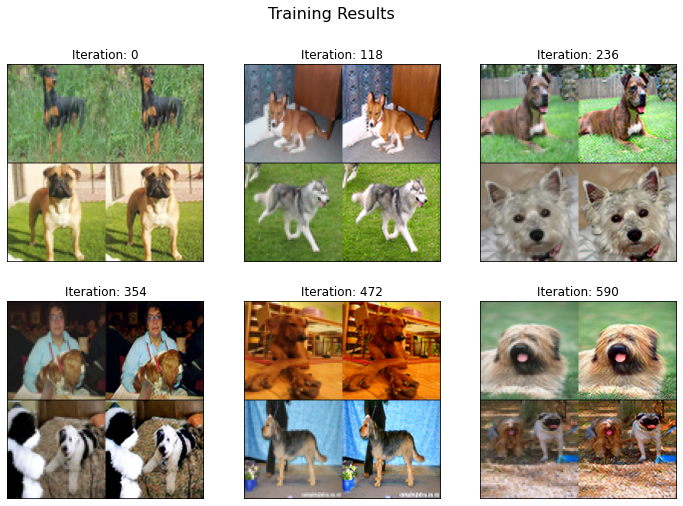

In [203]:
visualize_training_images(dataset_name, num_images=6)

# Dataset Noisy Dogs

## Creating Noisy Dogs Dataset and Saving Images

In [194]:
dataset_name = "img_noisy_dogs"
root = f"data/{dataset_name}"
os.makedirs(root, exist_ok=True)

noisy_dogs_full_data_list = []
num_digits = len(str(len(dogs_full_data_list)))
for i, image_path in enumerate(dogs_full_data_list):
    img = np.asarray(Image.open(image_path))
    noisy_img = (img + np.random.normal(0., 20, img.shape)).astype(np.uint8)
    noisy_img[noisy_img > 255] = 255
    noisy_img[noisy_img < 0] = 0
    noisy_img = Image.fromarray(noisy_img)

    img_num_str = str(i + 1)
    digits_left = num_digits - len(img_num_str)
    full_image_path = f"{root}/{'0'*digits_left + img_num_str}.jpg"
    noisy_dogs_full_data_list.append(full_image_path)
    noisy_img.save(full_image_path)

## Comparing Normal and Noisy Dogs Datasets

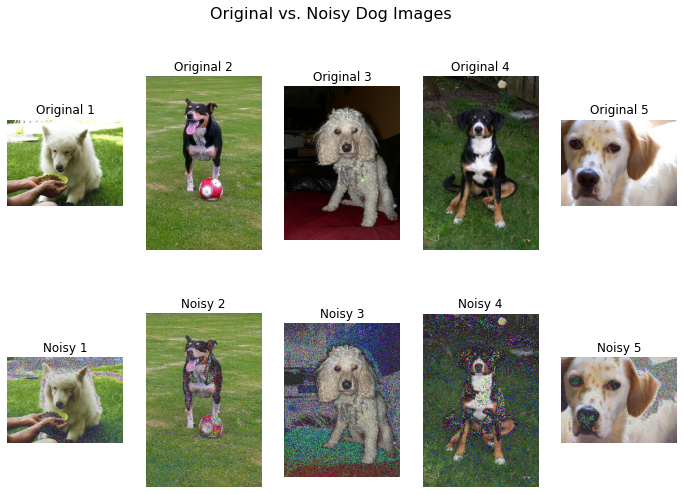

In [195]:
random_selections = np.random.choice(len(noisy_dogs_full_data_list)-1, size=5)
comparison_data_list = [dogs_full_data_list[i] for i in random_selections] + [noisy_dogs_full_data_list[i] for i in random_selections]
axis_titles = [f"Original {i}" for i in range(1,6)] + [f"Noisy {i}" for i in range(1,6)]

visualize_dataset(comparison_data_list, nrows=2, ncols=5, title='Original vs. Noisy Dog Images', axis_titles=axis_titles)

## Loading Noisy Dataset and Creating New Parameters

In [204]:
# Parameters
epoch = 0
n_epochs = 5
dataset_name ="img_dogs"
batch_size = 2
lr = 0.0002
b1 = 0.9
b2 = 0.999
decay_epoch = 5
n_cpu = 1
hr_height = 256
hr_width = 256
channels = 3
sample_interval = 10
checkpoint_interval = 50
residual_blocks = 23
warmup_batches = 500
lambda_adv = 5e-3
lambda_pixel = 1e-2
hr_shape = (256, 256)

dataset_name = "img_noisy_dogs"
TOTAL_SIZE = len(noisy_dogs_full_data_list)
TRAIN_SIZE = int(1/8 * TOTAL_SIZE)
VAL_SIZE = int(1/8 * TOTAL_SIZE)
TEST_SIZE = int(1/8 * TOTAL_SIZE)

os.makedirs(f"images/{dataset_name}/training", exist_ok=True)
os.makedirs(f"saved_models/{dataset_name}", exist_ok=True)

train_dataset = ImgDataset(noisy_dogs_full_data_list[:TRAIN_SIZE], hr_shape)
val_dataset = ImgDataset(noisy_dogs_full_data_list[TRAIN_SIZE: TRAIN_SIZE + VAL_SIZE], hr_shape)
test_dataset = ImgDataset(noisy_dogs_full_data_list[TRAIN_SIZE + VAL_SIZE: TRAIN_SIZE + VAL_SIZE + TEST_SIZE], hr_shape)

print("Training Set Size:", len(train_dataset))
print("Validation Set Size:", len(val_dataset))
print("Test Set Size:", len(test_dataset))

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=1, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=False
)

Training Set Size: 1556
Validation Set Size: 1556
Test Set Size: 1556


## Visualizing Noisy Dog Model

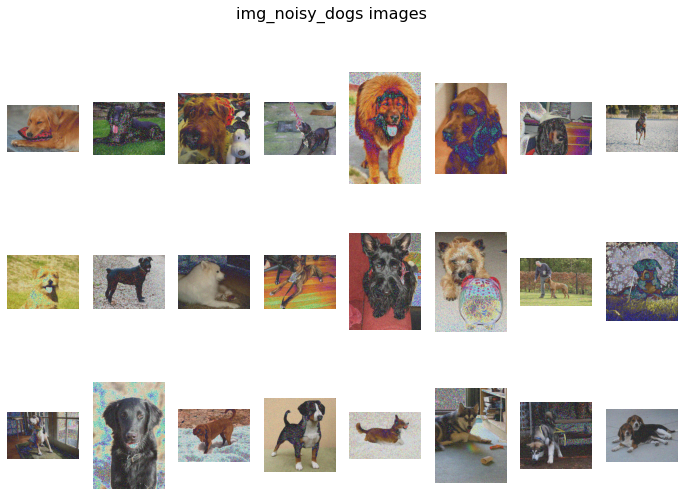

In [200]:
train_dataset.visualize_dataset(nrows=3, ncols=8, dataset_name=dataset_name)

## Training Noisy Dog Model

In [ ]:
# ----------
#  Training
# ----------
best_disc_score, best_gen_score = 5, 5
best_disc, best_gen = discriminator.state_dict(), generator.state_dict()
for epoch in range(epoch, n_epochs):
    for i, imgs in enumerate(train_loader):

        batches_done = epoch * len(train_loader) + i

        # Configure model input
        imgs_lr = Variable(imgs["lr"].type(Tensor))
        imgs_hr = Variable(imgs["hr"].type(Tensor))

        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)

        # ------------------
        #  Train Generators
        # ------------------

        optimizer_G.zero_grad()

        # Generate a high resolution image from low resolution input
        # Forward pass for generator
        gen_hr = generator(imgs_lr)

        # Measure pixel-wise loss against ground truth
        loss_pixel = criterion_pixel(gen_hr, imgs_hr)

        if batches_done < warmup_batches:
            # Warm-up (pixel-wise loss only)
            loss_pixel.backward()
            optimizer_G.step()
            print(
                "[Epoch %d/%d] [Batch %d/%d] [G pixel: %f]"
                % (epoch, n_epochs, i, len(train_loader), loss_pixel.item())
            )
            continue

        # Extract validity predictions from discriminator
        pred_real = discriminator(imgs_hr).detach()
        pred_fake = discriminator(gen_hr)

        # Adversarial loss (relativistic average GAN)
        loss_GAN = criterion_GAN(pred_fake - pred_real.mean(0, keepdim=True), valid)

        # Content loss
        gen_features = feature_extractor(gen_hr)
        real_features = feature_extractor(imgs_hr).detach()
        loss_content = criterion_content(gen_features, real_features)

        # Total generator loss
        loss_G = loss_content + lambda_adv * loss_GAN + lambda_pixel * loss_pixel

        loss_G.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        pred_real = discriminator(imgs_hr)
        pred_fake = discriminator(gen_hr.detach())

        # Adversarial loss for real and fake images (relativistic average GAN)
        loss_real = criterion_GAN(pred_real - pred_fake.mean(0, keepdim=True), valid)
        loss_fake = criterion_GAN(pred_fake - pred_real.mean(0, keepdim=True), fake)

        # Total loss
        loss_D = (loss_real + loss_fake) / 2

        loss_D.backward()
        optimizer_D.step()

        # --------------
        #  Log Progress
        # --------------

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, content: %f, adv: %f, pixel: %f]"
            % (
                epoch,
                n_epochs,
                i,
                len(train_loader),
                loss_D.item(),
                loss_G.item(),
                loss_content.item(),
                loss_GAN.item(),
                loss_pixel.item(),
            )
        )

        # Get best discriminator and best generator
        if best_disc_score > loss_D.item():
            best_disc_score = loss_D.item()
            best_disc = discriminator.state_dict()

        if best_gen_score > loss_G.item():
            best_gen_score = loss_G.item()
            best_gen = generator.state_dict()


        if batches_done % sample_interval == 0:
            # Save image grid with upsampled inputs and ESRGAN outputs
            print(f"Saving image after {batches_done} batches done")
            imgs_lr = nn.functional.interpolate(imgs_lr, scale_factor=4)
            img_grid = denormalize(torch.cat((imgs_lr, gen_hr), -1))
            save_image(img_grid, f"images/{dataset_name}/training/{batches_done}.png", nrow=1, normalize=False)

        if batches_done % checkpoint_interval == 0:
            # Save model checkpoints
            print(f"Saving model from epoch {epoch}")
            torch.save(generator.state_dict(), f"saved_models/{dataset_name}/generator_{epoch}.pth")
            torch.save(discriminator.state_dict(), f"saved_models/{dataset_name}/discriminator_{epoch}.pth")

# Save best models
torch.save(best_gen, f"saved_models/{dataset_name}/best_generator.pth")
torch.save(best_disc, f"saved_models/{dataset_name}/best_discriminator.pth")

[Epoch 0/5] [Batch 0/778] [G pixel: 0.292256]
[Epoch 0/5] [Batch 1/778] [G pixel: 0.268153]
[Epoch 0/5] [Batch 2/778] [G pixel: 0.178197]
[Epoch 0/5] [Batch 3/778] [G pixel: 0.354865]
[Epoch 0/5] [Batch 4/778] [G pixel: 0.318111]
[Epoch 0/5] [Batch 5/778] [G pixel: 0.309124]
[Epoch 0/5] [Batch 6/778] [G pixel: 0.229072]
[Epoch 0/5] [Batch 7/778] [G pixel: 0.295090]
[Epoch 0/5] [Batch 8/778] [G pixel: 0.226842]
[Epoch 0/5] [Batch 9/778] [G pixel: 0.283109]
[Epoch 0/5] [Batch 10/778] [G pixel: 0.327135]
[Epoch 0/5] [Batch 11/778] [G pixel: 0.243539]
[Epoch 0/5] [Batch 12/778] [G pixel: 0.314424]
[Epoch 0/5] [Batch 13/778] [G pixel: 0.391064]
[Epoch 0/5] [Batch 14/778] [G pixel: 0.331975]
[Epoch 0/5] [Batch 15/778] [G pixel: 0.326123]
[Epoch 0/5] [Batch 16/778] [G pixel: 0.346895]
[Epoch 0/5] [Batch 17/778] [G pixel: 0.305230]
[Epoch 0/5] [Batch 18/778] [G pixel: 0.357592]
[Epoch 0/5] [Batch 19/778] [G pixel: 0.329991]
[Epoch 0/5] [Batch 20/778] [G pixel: 0.323515]
[Epoch 0/5] [Batch 21/7

[Epoch 0/5] [Batch 173/778] [G pixel: 0.330306]
[Epoch 0/5] [Batch 174/778] [G pixel: 0.379921]
[Epoch 0/5] [Batch 175/778] [G pixel: 0.366480]
[Epoch 0/5] [Batch 176/778] [G pixel: 0.340156]
[Epoch 0/5] [Batch 177/778] [G pixel: 0.322416]
[Epoch 0/5] [Batch 178/778] [G pixel: 0.389557]
[Epoch 0/5] [Batch 179/778] [G pixel: 0.337027]
[Epoch 0/5] [Batch 180/778] [G pixel: 0.295474]
[Epoch 0/5] [Batch 181/778] [G pixel: 0.302465]
[Epoch 0/5] [Batch 182/778] [G pixel: 0.346354]
[Epoch 0/5] [Batch 183/778] [G pixel: 0.333655]
[Epoch 0/5] [Batch 184/778] [G pixel: 0.218947]
[Epoch 0/5] [Batch 185/778] [G pixel: 0.391156]
[Epoch 0/5] [Batch 186/778] [G pixel: 0.236117]
[Epoch 0/5] [Batch 187/778] [G pixel: 0.298815]
[Epoch 0/5] [Batch 188/778] [G pixel: 0.318808]
[Epoch 0/5] [Batch 189/778] [G pixel: 0.320895]
[Epoch 0/5] [Batch 190/778] [G pixel: 0.198356]
[Epoch 0/5] [Batch 191/778] [G pixel: 0.251170]
[Epoch 0/5] [Batch 192/778] [G pixel: 0.340651]
[Epoch 0/5] [Batch 193/778] [G pixel: 0.

[Epoch 0/5] [Batch 344/778] [G pixel: 0.395336]
[Epoch 0/5] [Batch 345/778] [G pixel: 0.332074]
[Epoch 0/5] [Batch 346/778] [G pixel: 0.249584]
[Epoch 0/5] [Batch 347/778] [G pixel: 0.325355]
[Epoch 0/5] [Batch 348/778] [G pixel: 0.295851]
[Epoch 0/5] [Batch 349/778] [G pixel: 0.299729]
[Epoch 0/5] [Batch 350/778] [G pixel: 0.233023]
[Epoch 0/5] [Batch 351/778] [G pixel: 0.269559]
[Epoch 0/5] [Batch 352/778] [G pixel: 0.287245]
[Epoch 0/5] [Batch 353/778] [G pixel: 0.381445]
[Epoch 0/5] [Batch 354/778] [G pixel: 0.351079]
[Epoch 0/5] [Batch 355/778] [G pixel: 0.455991]
[Epoch 0/5] [Batch 356/778] [G pixel: 0.289818]
[Epoch 0/5] [Batch 357/778] [G pixel: 0.215750]
[Epoch 0/5] [Batch 358/778] [G pixel: 0.320477]
[Epoch 0/5] [Batch 359/778] [G pixel: 0.273391]
[Epoch 0/5] [Batch 360/778] [G pixel: 0.313661]
[Epoch 0/5] [Batch 361/778] [G pixel: 0.318600]
[Epoch 0/5] [Batch 362/778] [G pixel: 0.246192]
[Epoch 0/5] [Batch 363/778] [G pixel: 0.201109]
[Epoch 0/5] [Batch 364/778] [G pixel: 0.

[Epoch 0/5] [Batch 506/778] [D loss: 0.000002] [G loss: 1.666617, content: 1.570189, adv: 18.707115, pixel: 0.289193]
[Epoch 0/5] [Batch 507/778] [D loss: 0.000004] [G loss: 1.605754, content: 1.508996, adv: 18.897926, pixel: 0.226886]
[Epoch 0/5] [Batch 508/778] [D loss: 0.000001] [G loss: 1.506768, content: 1.407336, adv: 19.168699, pixel: 0.358859]
[Epoch 0/5] [Batch 509/778] [D loss: 0.000042] [G loss: 1.516081, content: 1.447398, adv: 13.211628, pixel: 0.262456]
[Epoch 0/5] [Batch 510/778] [D loss: 0.000002] [G loss: 1.757839, content: 1.665390, adv: 17.963549, pixel: 0.263194]
Saving image after 510 batches done
[Epoch 0/5] [Batch 511/778] [D loss: 0.000007] [G loss: 1.980227, content: 1.896058, adv: 16.201370, pixel: 0.316249]
[Epoch 0/5] [Batch 512/778] [D loss: 0.000000] [G loss: 1.404355, content: 1.294931, adv: 21.237766, pixel: 0.323542]
[Epoch 0/5] [Batch 513/778] [D loss: 0.000011] [G loss: 1.714990, content: 1.637148, adv: 15.002842, pixel: 0.282823]
[Epoch 0/5] [Batch 5

[Epoch 0/5] [Batch 574/778] [D loss: 0.000001] [G loss: 1.505307, content: 1.401753, adv: 20.072056, pixel: 0.319420]
[Epoch 0/5] [Batch 575/778] [D loss: 0.000002] [G loss: 1.632912, content: 1.532128, adv: 19.421333, pixel: 0.367654]
[Epoch 0/5] [Batch 576/778] [D loss: 0.000057] [G loss: 1.715505, content: 1.647128, adv: 13.205059, pixel: 0.235159]
[Epoch 0/5] [Batch 577/778] [D loss: 0.000002] [G loss: 1.492746, content: 1.403395, adv: 17.135571, pixel: 0.367264]
[Epoch 0/5] [Batch 578/778] [D loss: 0.000002] [G loss: 1.602594, content: 1.507742, adv: 18.343555, pixel: 0.313403]
[Epoch 0/5] [Batch 579/778] [D loss: 0.000012] [G loss: 1.573196, content: 1.497854, adv: 14.524040, pixel: 0.272199]
[Epoch 0/5] [Batch 580/778] [D loss: 0.000008] [G loss: 1.819970, content: 1.729450, adv: 17.492956, pixel: 0.305585]
Saving image after 580 batches done
[Epoch 0/5] [Batch 581/778] [D loss: 0.000008] [G loss: 1.631162, content: 1.538907, adv: 17.779070, pixel: 0.335972]
[Epoch 0/5] [Batch 5

[Epoch 0/5] [Batch 642/778] [D loss: 0.000003] [G loss: 1.694708, content: 1.612493, adv: 15.822589, pixel: 0.310199]
[Epoch 0/5] [Batch 643/778] [D loss: 0.000001] [G loss: 1.501512, content: 1.406440, adv: 18.325563, pixel: 0.344344]
[Epoch 0/5] [Batch 644/778] [D loss: 0.000003] [G loss: 1.594966, content: 1.497624, adv: 18.631065, pixel: 0.418639]
[Epoch 0/5] [Batch 645/778] [D loss: 0.000007] [G loss: 1.693106, content: 1.608731, adv: 16.001953, pixel: 0.436534]
[Epoch 0/5] [Batch 646/778] [D loss: 0.000002] [G loss: 1.370940, content: 1.279688, adv: 17.709106, pixel: 0.270729]
[Epoch 0/5] [Batch 647/778] [D loss: 0.000000] [G loss: 1.519654, content: 1.410551, adv: 21.252975, pixel: 0.283826]
[Epoch 0/5] [Batch 648/778] [D loss: 0.000000] [G loss: 1.554679, content: 1.447195, adv: 20.936550, pixel: 0.280098]
[Epoch 0/5] [Batch 649/778] [D loss: 0.000001] [G loss: 1.357750, content: 1.253454, adv: 20.284847, pixel: 0.287178]
[Epoch 0/5] [Batch 650/778] [D loss: 0.000007] [G loss: 

[Epoch 0/5] [Batch 710/778] [D loss: 0.000006] [G loss: 1.561256, content: 1.479299, adv: 15.682476, pixel: 0.354466]
Saving image after 710 batches done
[Epoch 0/5] [Batch 711/778] [D loss: 0.000001] [G loss: 1.855550, content: 1.753250, adv: 19.983761, pixel: 0.238074]
[Epoch 0/5] [Batch 712/778] [D loss: 0.000001] [G loss: 1.269976, content: 1.173079, adv: 18.662197, pixel: 0.358615]
[Epoch 0/5] [Batch 713/778] [D loss: 0.000014] [G loss: 1.814197, content: 1.743046, adv: 13.679316, pixel: 0.275463]
[Epoch 0/5] [Batch 714/778] [D loss: 0.000005] [G loss: 1.478876, content: 1.395993, adv: 16.027523, pixel: 0.274554]
[Epoch 0/5] [Batch 715/778] [D loss: 0.000011] [G loss: 1.635638, content: 1.559255, adv: 14.665682, pixel: 0.305508]
[Epoch 0/5] [Batch 716/778] [D loss: 0.000001] [G loss: 1.525105, content: 1.427478, adv: 18.560196, pixel: 0.482585]
[Epoch 0/5] [Batch 717/778] [D loss: 0.000005] [G loss: 1.536188, content: 1.441658, adv: 18.257500, pixel: 0.324221]
[Epoch 0/5] [Batch 7

[Epoch 1/5] [Batch 0/778] [D loss: 0.000002] [G loss: 1.481838, content: 1.391512, adv: 17.515751, pixel: 0.274679]
[Epoch 1/5] [Batch 1/778] [D loss: 0.000001] [G loss: 1.762750, content: 1.670221, adv: 17.861576, pixel: 0.322099]
[Epoch 1/5] [Batch 2/778] [D loss: 0.000001] [G loss: 1.379663, content: 1.273728, adv: 20.660849, pixel: 0.263078]
Saving image after 780 batches done
[Epoch 1/5] [Batch 3/778] [D loss: 0.000002] [G loss: 1.670877, content: 1.584121, adv: 16.789120, pixel: 0.281005]
[Epoch 1/5] [Batch 4/778] [D loss: 0.000002] [G loss: 1.861794, content: 1.754847, adv: 20.683010, pixel: 0.353265]
[Epoch 1/5] [Batch 5/778] [D loss: 0.000001] [G loss: 1.675311, content: 1.581147, adv: 18.142164, pixel: 0.345255]
[Epoch 1/5] [Batch 6/778] [D loss: 0.000001] [G loss: 1.724596, content: 1.621628, adv: 19.903372, pixel: 0.345106]
[Epoch 1/5] [Batch 7/778] [D loss: 0.000003] [G loss: 1.797008, content: 1.703889, adv: 17.736122, pixel: 0.443777]
[Epoch 1/5] [Batch 8/778] [D loss: 0

[Epoch 1/5] [Batch 68/778] [D loss: 0.000013] [G loss: 1.305230, content: 1.221814, adv: 16.044451, pixel: 0.319321]
[Epoch 1/5] [Batch 69/778] [D loss: 0.000001] [G loss: 1.652555, content: 1.555977, adv: 18.555828, pixel: 0.379832]
[Epoch 1/5] [Batch 70/778] [D loss: 0.000001] [G loss: 1.785708, content: 1.684459, adv: 19.534578, pixel: 0.357644]
[Epoch 1/5] [Batch 71/778] [D loss: 0.000000] [G loss: 1.705240, content: 1.597423, adv: 20.900482, pixel: 0.331434]
[Epoch 1/5] [Batch 72/778] [D loss: 0.000000] [G loss: 1.403966, content: 1.300806, adv: 19.912798, pixel: 0.359637]
Saving image after 850 batches done
Saving model from epoch 1
[Epoch 1/5] [Batch 73/778] [D loss: 0.000002] [G loss: 1.607026, content: 1.508164, adv: 19.166359, pixel: 0.302964]
[Epoch 1/5] [Batch 74/778] [D loss: 0.000000] [G loss: 1.425956, content: 1.325937, adv: 19.396032, pixel: 0.303887]
[Epoch 1/5] [Batch 75/778] [D loss: 0.000010] [G loss: 1.469667, content: 1.391273, adv: 15.114929, pixel: 0.281926]
[E

[Epoch 1/5] [Batch 136/778] [D loss: 0.000000] [G loss: 1.273041, content: 1.165903, adv: 20.842659, pixel: 0.292488]
[Epoch 1/5] [Batch 137/778] [D loss: 0.000001] [G loss: 1.935503, content: 1.842567, adv: 17.890726, pixel: 0.348263]
[Epoch 1/5] [Batch 138/778] [D loss: 0.000002] [G loss: 1.637403, content: 1.545997, adv: 17.640785, pixel: 0.320213]
[Epoch 1/5] [Batch 139/778] [D loss: 0.000007] [G loss: 1.653059, content: 1.562229, adv: 17.352245, pixel: 0.406839]
[Epoch 1/5] [Batch 140/778] [D loss: 0.000002] [G loss: 1.654410, content: 1.557366, adv: 18.874250, pixel: 0.267292]
[Epoch 1/5] [Batch 141/778] [D loss: 0.000002] [G loss: 1.794693, content: 1.694025, adv: 19.385040, pixel: 0.374283]
[Epoch 1/5] [Batch 142/778] [D loss: 0.000002] [G loss: 1.510275, content: 1.423311, adv: 16.737797, pixel: 0.327511]
Saving image after 920 batches done
[Epoch 1/5] [Batch 143/778] [D loss: 0.000000] [G loss: 1.680273, content: 1.577269, adv: 20.053642, pixel: 0.273524]
[Epoch 1/5] [Batch 1

[Epoch 1/5] [Batch 204/778] [D loss: 0.000004] [G loss: 1.395250, content: 1.310354, adv: 16.492779, pixel: 0.243214]
[Epoch 1/5] [Batch 205/778] [D loss: 0.000001] [G loss: 1.685361, content: 1.585024, adv: 19.500652, pixel: 0.283336]
[Epoch 1/5] [Batch 206/778] [D loss: 0.000000] [G loss: 2.293157, content: 2.192551, adv: 19.468082, pixel: 0.326546]
[Epoch 1/5] [Batch 207/778] [D loss: 0.000002] [G loss: 1.813649, content: 1.713327, adv: 19.439381, pixel: 0.312521]
[Epoch 1/5] [Batch 208/778] [D loss: 0.000005] [G loss: 2.032210, content: 1.949549, adv: 15.949272, pixel: 0.291387]
[Epoch 1/5] [Batch 209/778] [D loss: 0.000000] [G loss: 1.499753, content: 1.383677, adv: 22.632502, pixel: 0.291332]
[Epoch 1/5] [Batch 210/778] [D loss: 0.000001] [G loss: 1.697993, content: 1.601980, adv: 18.390976, pixel: 0.405799]
[Epoch 1/5] [Batch 211/778] [D loss: 0.000001] [G loss: 1.818245, content: 1.727708, adv: 17.474964, pixel: 0.316213]
[Epoch 1/5] [Batch 212/778] [D loss: 0.000000] [G loss: 

[Epoch 1/5] [Batch 272/778] [D loss: 0.000000] [G loss: 1.981431, content: 1.874198, adv: 20.733749, pixel: 0.356404]
Saving image after 1050 batches done
Saving model from epoch 1
[Epoch 1/5] [Batch 273/778] [D loss: 0.000000] [G loss: 1.581171, content: 1.479202, adv: 19.799982, pixel: 0.296900]
[Epoch 1/5] [Batch 274/778] [D loss: 0.000003] [G loss: 1.594093, content: 1.501233, adv: 17.894981, pixel: 0.338487]
[Epoch 1/5] [Batch 275/778] [D loss: 0.000000] [G loss: 1.226830, content: 1.115995, adv: 21.608368, pixel: 0.279254]
[Epoch 1/5] [Batch 276/778] [D loss: 0.000001] [G loss: 2.060328, content: 1.960164, adv: 19.342876, pixel: 0.344975]
[Epoch 1/5] [Batch 277/778] [D loss: 0.000002] [G loss: 1.762557, content: 1.669292, adv: 17.980396, pixel: 0.336254]
[Epoch 1/5] [Batch 278/778] [D loss: 0.000005] [G loss: 1.803583, content: 1.720893, adv: 15.887515, pixel: 0.325254]
[Epoch 1/5] [Batch 279/778] [D loss: 0.000000] [G loss: 1.582307, content: 1.472029, adv: 21.563679, pixel: 0.2

[Epoch 1/5] [Batch 339/778] [D loss: 0.000004] [G loss: 1.946908, content: 1.855048, adv: 17.817911, pixel: 0.277039]
[Epoch 1/5] [Batch 340/778] [D loss: 0.000001] [G loss: 1.219526, content: 1.127846, adv: 17.883297, pixel: 0.226292]
[Epoch 1/5] [Batch 341/778] [D loss: 0.000001] [G loss: 1.331267, content: 1.223102, adv: 20.989258, pixel: 0.321964]
[Epoch 1/5] [Batch 342/778] [D loss: 0.000001] [G loss: 1.392720, content: 1.287054, adv: 20.515390, pixel: 0.308902]
Saving image after 1120 batches done
[Epoch 1/5] [Batch 343/778] [D loss: 0.000000] [G loss: 2.013024, content: 1.910556, adv: 19.913857, pixel: 0.289837]
[Epoch 1/5] [Batch 344/778] [D loss: 0.000001] [G loss: 1.845693, content: 1.747086, adv: 19.097427, pixel: 0.312001]
[Epoch 1/5] [Batch 345/778] [D loss: 0.000000] [G loss: 1.606820, content: 1.503891, adv: 20.077692, pixel: 0.254051]
[Epoch 1/5] [Batch 346/778] [D loss: 0.000001] [G loss: 1.614981, content: 1.508111, adv: 20.639931, pixel: 0.367049]
[Epoch 1/5] [Batch 

[Epoch 1/5] [Batch 407/778] [D loss: 0.000000] [G loss: 1.326858, content: 1.227447, adv: 19.371780, pixel: 0.255166]
[Epoch 1/5] [Batch 408/778] [D loss: 0.000001] [G loss: 1.579941, content: 1.483828, adv: 18.676140, pixel: 0.273150]
[Epoch 1/5] [Batch 409/778] [D loss: 0.000002] [G loss: 1.544479, content: 1.462920, adv: 15.810560, pixel: 0.250588]
[Epoch 1/5] [Batch 410/778] [D loss: 0.000003] [G loss: 1.538619, content: 1.453672, adv: 16.276148, pixel: 0.356618]
[Epoch 1/5] [Batch 411/778] [D loss: 0.000001] [G loss: 1.789873, content: 1.692630, adv: 18.687061, pixel: 0.380721]
[Epoch 1/5] [Batch 412/778] [D loss: 0.000000] [G loss: 1.640465, content: 1.527997, adv: 21.959047, pixel: 0.267361]
Saving image after 1190 batches done
[Epoch 1/5] [Batch 413/778] [D loss: 0.000001] [G loss: 1.934983, content: 1.831436, adv: 20.016823, pixel: 0.346218]
[Epoch 1/5] [Batch 414/778] [D loss: 0.000002] [G loss: 1.603309, content: 1.504802, adv: 18.952085, pixel: 0.374658]
[Epoch 1/5] [Batch 

[Epoch 1/5] [Batch 474/778] [D loss: 0.000001] [G loss: 2.064099, content: 1.972615, adv: 17.772840, pixel: 0.262030]
[Epoch 1/5] [Batch 475/778] [D loss: 0.000001] [G loss: 1.493415, content: 1.398515, adv: 18.341291, pixel: 0.319373]
[Epoch 1/5] [Batch 476/778] [D loss: 0.000000] [G loss: 1.907192, content: 1.796677, adv: 21.510508, pixel: 0.296285]
[Epoch 1/5] [Batch 477/778] [D loss: 0.000002] [G loss: 1.384400, content: 1.277562, adv: 20.831203, pixel: 0.268267]
[Epoch 1/5] [Batch 478/778] [D loss: 0.000004] [G loss: 1.378636, content: 1.296797, adv: 15.890215, pixel: 0.238738]
[Epoch 1/5] [Batch 479/778] [D loss: 0.000001] [G loss: 1.882535, content: 1.789641, adv: 17.926563, pixel: 0.326051]
[Epoch 1/5] [Batch 480/778] [D loss: 0.000000] [G loss: 1.826468, content: 1.719843, adv: 20.700401, pixel: 0.312307]
[Epoch 1/5] [Batch 481/778] [D loss: 0.000059] [G loss: 1.686775, content: 1.617234, adv: 13.393314, pixel: 0.257409]
[Epoch 1/5] [Batch 482/778] [D loss: 0.000000] [G loss: 

[Epoch 1/5] [Batch 542/778] [D loss: 0.000001] [G loss: 1.570421, content: 1.477167, adv: 18.028875, pixel: 0.310998]
Saving image after 1320 batches done
[Epoch 1/5] [Batch 543/778] [D loss: 0.000002] [G loss: 1.574680, content: 1.472650, adv: 19.900589, pixel: 0.252711]
[Epoch 1/5] [Batch 544/778] [D loss: 0.000002] [G loss: 1.547920, content: 1.461490, adv: 16.552174, pixel: 0.366882]
[Epoch 1/5] [Batch 545/778] [D loss: 0.000000] [G loss: 1.960536, content: 1.851817, adv: 21.106628, pixel: 0.318536]
[Epoch 1/5] [Batch 546/778] [D loss: 0.000000] [G loss: 1.672171, content: 1.559308, adv: 22.048611, pixel: 0.262015]
[Epoch 1/5] [Batch 547/778] [D loss: 0.000000] [G loss: 1.570734, content: 1.470360, adv: 19.233803, pixel: 0.420509]
[Epoch 1/5] [Batch 548/778] [D loss: 0.000001] [G loss: 1.407903, content: 1.308256, adv: 19.187088, pixel: 0.371192]
[Epoch 1/5] [Batch 549/778] [D loss: 0.000001] [G loss: 1.507486, content: 1.399925, adv: 20.839350, pixel: 0.336372]
[Epoch 1/5] [Batch 

[Epoch 1/5] [Batch 610/778] [D loss: 0.000001] [G loss: 1.820091, content: 1.721427, adv: 19.222618, pixel: 0.255092]
[Epoch 1/5] [Batch 611/778] [D loss: 0.000000] [G loss: 2.153436, content: 2.041489, adv: 21.763798, pixel: 0.312767]
[Epoch 1/5] [Batch 612/778] [D loss: 0.000004] [G loss: 1.697953, content: 1.612663, adv: 16.375221, pixel: 0.341391]
Saving image after 1390 batches done
[Epoch 1/5] [Batch 613/778] [D loss: 0.000000] [G loss: 2.064447, content: 1.956687, adv: 20.717762, pixel: 0.417069]
[Epoch 1/5] [Batch 614/778] [D loss: 0.000000] [G loss: 2.007938, content: 1.906984, adv: 19.588657, pixel: 0.301066]
[Epoch 1/5] [Batch 615/778] [D loss: 0.000001] [G loss: 1.763763, content: 1.675130, adv: 17.175564, pixel: 0.275516]
[Epoch 1/5] [Batch 616/778] [D loss: 0.000003] [G loss: 1.662954, content: 1.577130, adv: 16.495159, pixel: 0.334797]
[Epoch 1/5] [Batch 617/778] [D loss: 0.000002] [G loss: 1.793207, content: 1.699971, adv: 17.939140, pixel: 0.354033]
[Epoch 1/5] [Batch 

[Epoch 1/5] [Batch 677/778] [D loss: 0.000001] [G loss: 1.536468, content: 1.439000, adv: 18.757538, pixel: 0.368070]
[Epoch 1/5] [Batch 678/778] [D loss: 0.000009] [G loss: 1.360879, content: 1.282779, adv: 15.114428, pixel: 0.252766]
[Epoch 1/5] [Batch 679/778] [D loss: 0.000000] [G loss: 1.723140, content: 1.619116, adv: 20.016201, pixel: 0.394249]
[Epoch 1/5] [Batch 680/778] [D loss: 0.000001] [G loss: 1.681220, content: 1.581448, adv: 19.341515, pixel: 0.306480]
[Epoch 1/5] [Batch 681/778] [D loss: 0.000003] [G loss: 1.921766, content: 1.830449, adv: 17.612053, pixel: 0.325662]
[Epoch 1/5] [Batch 682/778] [D loss: 0.000000] [G loss: 1.512907, content: 1.411458, adv: 19.666891, pixel: 0.311367]
Saving image after 1460 batches done
[Epoch 1/5] [Batch 683/778] [D loss: 0.000003] [G loss: 1.541946, content: 1.454142, adv: 17.029381, pixel: 0.265720]
[Epoch 1/5] [Batch 684/778] [D loss: 0.000005] [G loss: 1.494013, content: 1.407108, adv: 16.653454, pixel: 0.363778]
[Epoch 1/5] [Batch 

[Epoch 1/5] [Batch 745/778] [D loss: 0.000006] [G loss: 1.532757, content: 1.442044, adv: 17.401804, pixel: 0.370340]
[Epoch 1/5] [Batch 746/778] [D loss: 0.000000] [G loss: 1.152411, content: 1.047781, adv: 20.351648, pixel: 0.287165]
[Epoch 1/5] [Batch 747/778] [D loss: 0.000000] [G loss: 1.523237, content: 1.418876, adv: 20.226734, pixel: 0.322735]
[Epoch 1/5] [Batch 748/778] [D loss: 0.000000] [G loss: 2.501387, content: 2.388368, adv: 21.997458, pixel: 0.303173]
[Epoch 1/5] [Batch 749/778] [D loss: 0.000001] [G loss: 1.554514, content: 1.462964, adv: 17.465233, pixel: 0.422386]
[Epoch 1/5] [Batch 750/778] [D loss: 0.000001] [G loss: 1.703725, content: 1.600945, adv: 19.956402, pixel: 0.299802]
[Epoch 1/5] [Batch 751/778] [D loss: 0.000000] [G loss: 1.695556, content: 1.586324, adv: 21.251270, pixel: 0.297594]
[Epoch 1/5] [Batch 752/778] [D loss: 0.000001] [G loss: 1.977303, content: 1.874173, adv: 19.928083, pixel: 0.348976]
Saving image after 1530 batches done
[Epoch 1/5] [Batch 

[Epoch 2/5] [Batch 35/778] [D loss: 0.000000] [G loss: 1.497065, content: 1.385886, adv: 21.696568, pixel: 0.269660]
[Epoch 2/5] [Batch 36/778] [D loss: 0.000001] [G loss: 1.692653, content: 1.592423, adv: 19.447426, pixel: 0.299280]
[Epoch 2/5] [Batch 37/778] [D loss: 0.000000] [G loss: 1.731318, content: 1.627006, adv: 20.218296, pixel: 0.322107]
[Epoch 2/5] [Batch 38/778] [D loss: 0.000001] [G loss: 1.991295, content: 1.886648, adv: 20.222942, pixel: 0.353217]
[Epoch 2/5] [Batch 39/778] [D loss: 0.000000] [G loss: 1.692858, content: 1.596425, adv: 18.401054, pixel: 0.442866]
[Epoch 2/5] [Batch 40/778] [D loss: 0.000000] [G loss: 1.953434, content: 1.852347, adv: 19.576641, pixel: 0.320349]
[Epoch 2/5] [Batch 41/778] [D loss: 0.000000] [G loss: 1.700868, content: 1.594805, adv: 20.581322, pixel: 0.315684]
[Epoch 2/5] [Batch 42/778] [D loss: 0.000000] [G loss: 1.496539, content: 1.395571, adv: 19.626263, pixel: 0.283675]
[Epoch 2/5] [Batch 43/778] [D loss: 0.000001] [G loss: 1.468512,

[Epoch 2/5] [Batch 103/778] [D loss: 0.000000] [G loss: 1.151529, content: 1.032782, adv: 23.362284, pixel: 0.193558]
[Epoch 2/5] [Batch 104/778] [D loss: 0.000001] [G loss: 1.622056, content: 1.529937, adv: 17.856815, pixel: 0.283535]
Saving image after 1660 batches done
[Epoch 2/5] [Batch 105/778] [D loss: 0.000000] [G loss: 1.733204, content: 1.628191, adv: 20.424675, pixel: 0.288912]
[Epoch 2/5] [Batch 106/778] [D loss: 0.000002] [G loss: 1.917936, content: 1.819839, adv: 19.006401, pixel: 0.306496]
[Epoch 2/5] [Batch 107/778] [D loss: 0.000000] [G loss: 1.774541, content: 1.667310, adv: 20.785137, pixel: 0.330547]
[Epoch 2/5] [Batch 108/778] [D loss: 0.000001] [G loss: 1.710896, content: 1.617610, adv: 18.150475, pixel: 0.253402]
[Epoch 2/5] [Batch 109/778] [D loss: 0.000000] [G loss: 1.634466, content: 1.539261, adv: 18.516918, pixel: 0.262033]
[Epoch 2/5] [Batch 110/778] [D loss: 0.000000] [G loss: 1.387503, content: 1.284769, adv: 19.936878, pixel: 0.304924]
[Epoch 2/5] [Batch 

## Check Best Noisy Model Results

In [ ]:
image_path = f"images/{dataset_name}/training/{1000}.png"
best_gen_path = f"saved_models/{dataset_name}/best_generator.pth"
best_disc_path = f"saved_models/{dataset_name}/best_discriminator.pth"
channels = 3
residual_blocks = 23

os.makedirs(f"images/{dataset_name}/outputs", exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model and load model checkpoint
generator = GeneratorRRDB(channels, filters=64, num_res_blocks=residual_blocks).to(device)
generator.load_state_dict(best_gen)
generator.eval()

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

# Prepare input
image_tensor = Variable(transform(Image.open(image_path))).to(device).unsqueeze(0)

# Upsample image
with torch.no_grad():
    sr_image = denormalize(generator(image_tensor)).cpu()

# Save image
fn = image_path.split("/")[-1]
save_image(sr_image, f"images/{dataset_name}/outputs/sr-{fn}")